<a href="https://colab.research.google.com/github/lerren144/UZH-Master-Thesis/blob/main/3.1.%20MODIS%20Land%20Cover%20Disturbed%20and%20Undisturbed%20Analysis%20(Extraction%20of%20Masks).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Master Thesis Entitled:**
**Quantifying Land Surface Temperature Changes Associated with Land Cover Changes**

Created by: Lou Lerren C. Curacha

## **1. Initializing Packages and Account Access in GEE**

In [ ]:
import ee
import google

In [ ]:
## Project ID
PROJECT_ID = 'myproject-curacha' # @param {type: 'string'}

In [ ]:
## Google Colab Authentication
## Allow Access to Google Account Information
google.colab.auth.authenticate_user()
print("Authenticated")

Authenticated


In [ ]:
## Google Earth Connection Initialization
credentials, project_id = google.auth.default()
ee.Initialize(credentials, project=PROJECT_ID)
print(ee.String('Google Earth Connection Established!').getInfo())

Google Earth Connection Established!


## **2. Accessing MODIS Land Cover Images**

In [ ]:
import ee
import geemap
import ipywidgets as widgets

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180,-59], [0, -59], [-180,-59]],
    None,
    False
)

# Define visualization parameters for LC Type 3
visualization_parameters = {
    'min': 0,
    'max': 10,
    'palette': [
        '#1c0dff', '#b6ff05', '#dcd159', '#c24f44', '#fbff13',
        '#086a10', '#78d203', '#05450a', '#54a708', '#f9ffa4',
        '#a5a5a5'
    ]
}

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type3') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Initialize the map without the layer control button
Map = geemap.Map(control_scale=False, control_layer=False)

# Create a dropdown widget to select the year
year_dropdown = widgets.Dropdown(
    options=[str(year) for year in range(2001, 2022)],
    description='Select Year',
    value='2001'
)

# Function to update the map when a year is selected
def update_map(change):
    selected_year = change['new']

    # Clear all layers
    Map.layers = []

    # Load and add the new layer for the selected year
    lc_image = load_land_cover(selected_year)
    if lc_image:
        Map.addLayer(lc_image, visualization_parameters, f'LC Cover {selected_year}')
    else:
        print(f"Failed to load land cover data for the year {selected_year}.")

# Link the dropdown to the update_map function
year_dropdown.observe(update_map, names='value')

# Display the map and the dropdown widget
display(year_dropdown)

# Center the map at (0, 0) with a zoom level of 2
Map.setCenter(0, 0, zoom=2)
Map


Dropdown(description='Select Year', options=('2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '…

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

LayerException: layer not on map: EELeafletTileLayer(attribution='Google Earth Engine', max_zoom=24, name='LC Cover 2002', options=['attribution', 'bounds', 'detect_retina', 'max_native_zoom', 'max_zoom', 'min_native_zoom', 'min_zoom', 'no_wrap', 'tile_size', 'tms', 'zoom_offset'], url='https://earthengine.googleapis.com/v1/projects/ee-llccuracha-thesis/maps/e840f6e0f534137f4e0ce5ac1cc191e2-c715487512617ee63ebb23a4060f7329/tiles/{z}/{x}/{y}')

## **3. Converting to Binary Masks - MODIS Land Cover Images**

In [ ]:
import ee
import geemap
import ipywidgets as widgets

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180,-59], [0, -59], [-180,-59]],
    None,
    False
)

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type3') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Initialize the map without the layer control button
Map = geemap.Map(control_scale=False, control_layer=False)

# Create dropdown widgets to select the year and land cover type
year_dropdown = widgets.Dropdown(
    options=[str(year) for year in range(2001, 2022)],
    description='Select Year',
    value='2001'
)

lc_type_dropdown = widgets.Dropdown(
    options=[
        ('Water Bodies', 0),
        ('Grasslands', 1),
        ('Shrublands', 2),
        ('Broadleaf Croplands', 3),
        ('Savannas', 4),
        ('Evergreen Broadleaf Forests', 5),
        ('Deciduous Broadleaf Forests', 6),
        ('Evergreen Needleleaf Forests', 7),
        ('Deciduous Needleleaf Forests', 8),
        ('Non-Vegetated Lands', 9),
        ('Urban and Built-up Lands', 10)
    ],
    description='Land Cover',
    value=0
)

# Function to update the map when a year or land cover class is selected
def update_map(change=None):
    selected_year = year_dropdown.value
    selected_class = lc_type_dropdown.value

    # Clear all layers
    Map.layers = []

    # Load the land cover image for the selected year
    lc_image = load_land_cover(selected_year)
    if lc_image:
        # Create a binary image where the selected class is 1 and others are 0
        binary_image = lc_image.eq(selected_class).selfMask()

        # Define visualization parameters for the binary image
        binary_vis_params = {
            'min': 0,
            'max': 1,
            'palette': ['white', 'red']
        }

        # Add the binary image to the map
        Map.addLayer(binary_image, binary_vis_params, f'LC {selected_year} - {lc_type_dropdown.label}')
    else:
        print(f"Failed to load land cover data for the year {selected_year}.")

# Link the dropdowns to the update_map function
year_dropdown.observe(update_map, names='value')
lc_type_dropdown.observe(update_map, names='value')

# Display the dropdown widgets and the map
display(year_dropdown)
display(lc_type_dropdown)

# Center the map at (0, 0) with a zoom level of 2
Map.setCenter(0, 0, zoom=2)
Map


Dropdown(description='Select Year', options=('2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '…

Dropdown(description='Land Cover', options=(('Water Bodies', 0), ('Grasslands', 1), ('Shrublands', 2), ('Broad…

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## **4. Undisturbed Landcover Areas (Binary Masked)**

In [ ]:
import ee
import geemap
import ipywidgets as widgets

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180,-59], [0, -59], [-180,-59]],
    None,
    False
)

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type3') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Initialize the map without the layer control button
Map = geemap.Map(control_scale=False, control_layer=False)

# Create dropdown widget to select the land cover type
lc_type_dropdown = widgets.Dropdown(
    options=[
        ('Water Bodies', 0),
        ('Grasslands', 1),
        ('Shrublands', 2),
        ('Broadleaf Croplands', 3),
        ('Savannas', 4),
        ('Evergreen Broadleaf Forests', 5),
        ('Deciduous Broadleaf Forests', 6),
        ('Evergreen Needleleaf Forests', 7),
        ('Deciduous Needleleaf Forests', 8),
        ('Non-Vegetated Lands', 9),
        ('Urban and Built-up Lands', 10)
    ],
    description='Land Cover',
    value=0
)

# Function to create and display the image that retains only the pixels consistently classified
def update_map(change=None):
    selected_class = lc_type_dropdown.value

    # Initialize an image where all pixels are set to 1
    consistent_image = ee.Image.constant(1)

    # Iterate over the years
    for year in range(2001, 2022):
        lc_image = load_land_cover(year)

        if lc_image:
            # Create a binary image for the selected class
            binary_image = lc_image.eq(selected_class).selfMask()

            # Use logical And to keep only pixels that are 1 in all years
            consistent_image = consistent_image.And(binary_image)

    # Define visualization parameters for the consistent binary image
    binary_vis_params = {
        'min': 0,
        'max': 1,
        'palette': ['white', 'red']
    }

    # Clear all layers and add the consistent image
    Map.layers = []
    Map.addLayer(consistent_image, binary_vis_params, f'Consistent LC {lc_type_dropdown.label}')

# Link the dropdown to the update_map function
lc_type_dropdown.observe(update_map, names='value')

# Display the dropdown widget and the map
display(lc_type_dropdown)

# Center the map at (0, 0) with a zoom level of 2
Map.setCenter(0, 0, zoom=2)
Map


Dropdown(description='Land Cover', options=(('Water Bodies', 0), ('Grasslands', 1), ('Shrublands', 2), ('Broad…

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
import ee
import geemap

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180,-59], [0, -59], [-180,-59]],
    None,
    False
)

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type3') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Initialize the map without the layer control button
Map = geemap.Map(control_scale=False, control_layer=False)

# List of land cover classes and descriptions
land_cover_classes = {
    0: 'Water Bodies',
    1: 'Grasslands',
    2: 'Shrublands',
    3: 'Broadleaf Croplands',
    4: 'Savannas',
    5: 'Evergreen Broadleaf Forests',
    6: 'Deciduous Broadleaf Forests',
    7: 'Evergreen Needleleaf Forests',
    8: 'Deciduous Needleleaf Forests',
    9: 'Non-Vegetated Lands',
    10: 'Urban and Built-up Lands'
}

# Function to create and display the combined binary masks
def create_combined_masks():
    combined_image = None

    # Iterate over each land cover class
    for lc_value, lc_name in land_cover_classes.items():
        consistent_image = ee.Image.constant(1)

        # Iterate over the years and create a consistent mask
        for year in range(2001, 2022):
            lc_image = load_land_cover(year)
            if lc_image:
                binary_image = lc_image.eq(lc_value).selfMask()
                consistent_image = consistent_image.And(binary_image)

        # Add the consistent mask as a band
        consistent_image = consistent_image.rename(f'{lc_name.replace(" ", "_")}_Mask')

        if combined_image is None:
            combined_image = consistent_image
        else:
            combined_image = combined_image.addBands(consistent_image)

    return combined_image

# Generate the combined masks image
combined_masks_image = create_combined_masks()

# Define visualization parameters for each band (using the same color palette)
binary_vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'red']
}

# Clear all layers and add each mask band to the map
Map.layers = []
for lc_value, lc_name in land_cover_classes.items():
    Map.addLayer(combined_masks_image.select(f'{lc_name.replace(" ", "_")}_Mask'), binary_vis_params, f'{lc_name} Mask')

# Center the map at (0, 0) with a zoom level of 2
Map.setCenter(0, 0, zoom=2)

# Display the map
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## **5. Disturbed Landcover Areas (Binary Masked)**

In [ ]:
import ee
import geemap

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180,-59], [0, -59], [-180,-59]],
    None,
    False
)

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type3') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Initialize the map without the layer control button
Map = geemap.Map(control_scale=False, control_layer=False)

# Function to create and display the inconsistent pixels mask
def create_inconsistent_mask():
    # Initialize a mask to track changes
    first_year = 2001
    initial_image = load_land_cover(first_year)
    inconsistent_mask = ee.Image.constant(0)

    # Iterate over the years and compare each year's image with the previous one
    for year in range(2002, 2022):
        current_image = load_land_cover(year)

        if current_image:
            # Identify changes between the current year and the initial year
            change_mask = initial_image.neq(current_image)

            # Update the inconsistent mask to include these changes
            inconsistent_mask = inconsistent_mask.Or(change_mask)

            # Update the initial image to the current year for the next iteration
            initial_image = current_image

    # Apply the mask to focus only on regions where changes occurred
    inconsistent_mask = inconsistent_mask.selfMask()

    return inconsistent_mask

# Generate the inconsistent mask image
inconsistent_image = create_inconsistent_mask()

# Define visualization parameters for the inconsistent image
inconsistent_vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'red']
}

# Clear all layers and add the inconsistent image to the map
Map.layers = []
Map.addLayer(inconsistent_image, inconsistent_vis_params, 'Inconsistent Pixels')

# Center the map at (0, 0) with a zoom level of 2
Map.setCenter(0, 0, zoom=2)

# Display the map
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## **6.1. Original (Type 3) Disturbed Landcover Areas (Changed Once from 2006 to 2015)**

In [ ]:
import ee
import geemap
import ipywidgets as widgets
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180,-59], [0, -59], [-180,-59]],
    None,
    False
)

# Define visualization parameters for LC Type 3
visualization_parameters = {
    'min': 0,
    'max': 10,
    'palette': [
        '#1c0dff', '#b6ff05', '#dcd159', '#c24f44', '#fbff13',
        '#086a10', '#78d203', '#05450a', '#54a708', '#f9ffa4',
        '#a5a5a5'
    ]
}

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type3') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Function to detect and mask areas with a single land cover change
def detect_single_change(lc_images):
    combined_image = ee.Image.cat(lc_images)
    diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
    change_mask = diffs.abs().gt(0)
    change_count = change_mask.reduce(ee.Reducer.sum())
    single_change_mask = change_count.eq(1)
    return single_change_mask

# Function to detect the year of the first change where exactly one change occurred
def detect_change_year_from_disturbed(lc_images, disturbed_mask):
    change_years = ee.Image(0)  # Initialize with zeros
    for i in range(1, len(lc_images)):
        change = lc_images[i].neq(lc_images[i-1])  # Detect change
        change_years = change_years.where(change.And(change_years.eq(0)), i + 2006)  # Mark the year of change
    # Mask with the disturbed areas to only keep the year of change for those areas
    change_years = change_years.updateMask(disturbed_mask)
    return change_years

# Function to create Before_Landcover and After_Landcover layers
def create_before_after_landcover_layers(lc_images, change_years):
    before_landcover = ee.Image(0)
    after_landcover = ee.Image(0)
    for i in range(1, len(lc_images)):
        current_year = i + 2006
        before_condition = change_years.eq(current_year)
        after_condition = change_years.eq(current_year)
        before_landcover = before_landcover.where(before_condition, lc_images[i-1])
        after_landcover = after_landcover.where(after_condition, lc_images[i])
    return before_landcover, after_landcover

# Initialize the ipyleaflet map with scroll zoom enabled and larger dimensions
m = Map(center=(0, 0), zoom=2, scroll_wheel_zoom=True, layout={'width': '1000px', 'height': '700px'})

# Function to add a specific year's land cover as a TileLayer
def add_land_cover_to_map(year):
    lc_image = load_land_cover(year)
    if lc_image:
        tile_layer = geemap.ee_tile_layer(lc_image, visualization_parameters, f'LC Cover {year}')
        m.add_layer(tile_layer)
    else:
        print(f"Failed to load land cover data for the year {year}.")

# Add land cover layers for years 2006 to 2015 to the map
lc_images = [load_land_cover(year) for year in range(2006, 2016)]
for year in range(2006, 2016):
    add_land_cover_to_map(year)

# Add the disturbed mask layer to the map (single change detection)
disturbed_mask = detect_single_change(lc_images)
disturbed_mask_layer = geemap.ee_tile_layer(disturbed_mask.selfMask(), {'palette': ['red']}, 'Disturbed_Mask')
m.add_layer(disturbed_mask_layer)

# Add the "Change Detected" layer to the map (year of change detection based on disturbed areas)
change_year_mask = detect_change_year_from_disturbed(lc_images, disturbed_mask)
change_year_layer = geemap.ee_tile_layer(change_year_mask.selfMask(), {'min': 2006, 'max': 2015, 'palette': ['yellow', 'orange', 'red']}, 'Change_Year_Mask')
m.add_layer(change_year_layer)

# Create and add the Before_Landcover and After_Landcover layers
before_landcover, after_landcover = create_before_after_landcover_layers(lc_images, change_year_mask)
before_landcover_layer = geemap.ee_tile_layer(before_landcover.selfMask(), visualization_parameters, 'Before_Landcover')
after_landcover_layer = geemap.ee_tile_layer(after_landcover.selfMask(), visualization_parameters, 'After_Landcover')
m.add_layer(before_landcover_layer)
m.add_layer(after_landcover_layer)

# Add layer control to toggle layers on/off
layers_control = LayersControl(position='topright')
m.add_control(layers_control)

# Create a table (widget) to display the information
output_table = widgets.HTML(value="")
output_table.layout.margin = '0px 20px 20px 20px'
output_table.layout.width = '600px'

# Function to update the GUI table
def update_table(results, disturbed_value, change_year_value):
    html_content = "<table><tr><th>Year</th>"
    for year in results.keys():
        html_content += f"<th>{year}</th>"
    html_content += "</tr><tr><td>LC</td>"
    for value in results.values():
        html_content += f"<td>{value}</td>"
    html_content += f"</tr><tr><td>Disturbed_Mask</td><td colspan='{len(results)}'>{disturbed_value}</td></tr>"
    html_content += f"<tr><td>Change_Detected_Mask (Year)</td><td colspan='{len(results)}'>{change_year_value}</td></tr>"
    html_content += "</table>"
    output_table.value = html_content

# Function to handle map click event
def handle_map_click(**kwargs):
    # Check if the event is a left-click (event type 'click')
    if kwargs.get('type') == 'click':
        lat = kwargs.get('coordinates')[0]
        lon = kwargs.get('coordinates')[1]

        # Check if coordinates are within valid bounds
        if -90 <= lat <= 90 and -180 <= lon <= 180:
            point = ee.Geometry.Point([lon, lat])

            # Extract information from each year's image at the clicked point
            results = {}
            for year, image in zip(range(2006, 2016), lc_images):
                value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('LC_Type3').getInfo()
                results[year] = value

            # Extract disturbed mask and change year values
            disturbed_value = disturbed_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('sum').getInfo()

            change_year_value = change_year_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('constant').getInfo()

            # Update the table with new information
            update_table(results, disturbed_value, change_year_value)

# Attach the click event handler to the map
m.on_interaction(handle_map_click)

# Display the map and the table below it
display(m)
display(output_table)


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

HTML(value='', layout=Layout(margin='0px 20px 20px 20px', width='600px'))

## **6.2.1. Aggregated (Type 3) Disturbed Landcover Areas (Changed Once from 2006 to 2015)**

Aggregated Categories:

*   Class 1: Water Bodies (Class 0)
*   Class 2: Low Vegetation (<2m): Grasslands, Shrublands, and Croplands (Classes 1, 2, 3)
*   Class 3: Mid Vegetation (>2m): Savannas (Class 4)
*   Class 4: Forests (Canopy >2m): Evergreen and Deciduous Broadleaf/Needleleaf Forests (Classes 5, 6, 7, 8)
*   Class 5: Non-Vegetated (Class 9)
*   Class 6: Built-up (Class 10)

In [ ]:
import ee
import geemap
import ipywidgets as widgets
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180,-59], [0, -59], [-180,-59]],
    None,
    False
)

# Define visualization parameters for the aggregated categories
aggregated_visualization_parameters = {
    'min': 1,
    'max': 6,
    'palette': [
        '#1c0dff',  # Water Bodies
        '#b6ff05',  # Low Vegetation (<2m)
        '#78d203',  # Mid Vegetation (>2m)
        '#086a10',  # Forests (Canopy >2m)
        '#f9ffa4',  # Non-Vegetated
        '#a5a5a5'   # Built-up
    ]
}

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type3') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Function to aggregate LC_Type3 into the defined categories
def aggregate_land_cover(lc_image):
    # Remap LC_Type3 values to aggregated classes
    aggregated_lc = lc_image.remap(
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],  # Original LC_Type3 values
        [1, 2, 2, 2, 3, 4, 4, 4, 4, 5, 6]   # Aggregated classes
    )
    return aggregated_lc

# Function to detect and mask areas with a single land cover change
def detect_single_change(lc_images):
    combined_image = ee.Image.cat(lc_images)
    diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
    change_mask = diffs.abs().gt(0)
    change_count = change_mask.reduce(ee.Reducer.sum())
    single_change_mask = change_count.eq(1)
    return single_change_mask

# Function to detect the year of the first change where exactly one change occurred
def detect_change_year_from_disturbed(lc_images, disturbed_mask):
    change_years = ee.Image(0)  # Initialize with zeros
    for i in range(1, len(lc_images)):
        change = lc_images[i].neq(lc_images[i-1])  # Detect change
        change_years = change_years.where(change.And(change_years.eq(0)), i + 2006)  # Mark the year of change
    change_years = change_years.updateMask(disturbed_mask)  # Mask with the disturbed areas
    return change_years

# Function to create Before_Landcover and After_Landcover layers
def create_before_after_landcover_layers(lc_images, change_years):
    before_landcover = ee.Image(0)
    after_landcover = ee.Image(0)
    for i in range(1, len(lc_images)):
        current_year = i + 2006
        before_condition = change_years.eq(current_year)
        after_condition = change_years.eq(current_year)
        before_landcover = before_landcover.where(before_condition, lc_images[i-1])
        after_landcover = after_landcover.where(after_condition, lc_images[i])
    return before_landcover, after_landcover

# Initialize the ipyleaflet map with scroll zoom enabled and larger dimensions
m = Map(center=(0, 0), zoom=2, scroll_wheel_zoom=True, layout={'width': '1000px', 'height': '700px'})

# Function to add a specific year's aggregated land cover as a TileLayer
def add_land_cover_to_map(year):
    lc_image = load_land_cover(year)
    aggregated_lc_image = aggregate_land_cover(lc_image)
    if aggregated_lc_image:
        tile_layer = geemap.ee_tile_layer(aggregated_lc_image, aggregated_visualization_parameters, f'LC Cover {year}')
        m.add_layer(tile_layer)
    else:
        print(f"Failed to load land cover data for the year {year}.")

# Load and aggregate land cover data for years 2006 to 2015
lc_images = [aggregate_land_cover(load_land_cover(year)) for year in range(2006, 2016)]
for year in range(2006, 2016):
    add_land_cover_to_map(year)

# Add the disturbed mask layer to the map (single change detection)
disturbed_mask = detect_single_change(lc_images)
disturbed_mask_layer = geemap.ee_tile_layer(disturbed_mask.selfMask(), {'palette': ['red']}, 'Disturbed_Mask')
m.add_layer(disturbed_mask_layer)

# Add the "Change Detected" layer to the map (year of change detection based on disturbed areas)
change_year_mask = detect_change_year_from_disturbed(lc_images, disturbed_mask)
change_year_layer = geemap.ee_tile_layer(change_year_mask.selfMask(), {'min': 2006, 'max': 2015, 'palette': ['yellow', 'orange', 'red']}, 'Change_Year_Mask')
m.add_layer(change_year_layer)

# Create and add the Before_Landcover and After_Landcover layers
before_landcover, after_landcover = create_before_after_landcover_layers(lc_images, change_year_mask)
before_landcover_layer = geemap.ee_tile_layer(before_landcover.selfMask(), aggregated_visualization_parameters, 'Before Landcover')
after_landcover_layer = geemap.ee_tile_layer(after_landcover.selfMask(), aggregated_visualization_parameters, 'After Landcover')
m.add_layer(before_landcover_layer)
m.add_layer(after_landcover_layer)

# Add layer control to toggle layers on/off
layers_control = LayersControl(position='topright')
m.add_control(layers_control)

# Create a table (widget) to display the information
output_table = widgets.HTML(value="")
output_table.layout.margin = '0px 20px 20px 20px'
output_table.layout.width = '600px'

# Function to update the GUI table
def update_table(results, disturbed_value, change_year_value):
    html_content = "<table><tr><th>Year</th>"
    for year in results.keys():
        html_content += f"<th>{year}</th>"
    html_content += "</tr><tr><td>LC</td>"
    for value in results.values():
        html_content += f"<td>{value}</td>"
    html_content += f"</tr><tr><td>Disturbed_Mask</td><td colspan='{len(results)}'>{disturbed_value}</td></tr>"
    html_content += f"<tr><td>Change_Detected_Mask (Year)</td><td colspan='{len(results)}'>{change_year_value}</td></tr>"
    html_content += "</table>"
    output_table.value = html_content

# Function to handle map click event and retrieve aggregated land cover values
def handle_map_click(**kwargs):
    if kwargs.get('type') == 'click':
        lat = kwargs.get('coordinates')[0]
        lon = kwargs.get('coordinates')[1]

        # Check if coordinates are within valid bounds
        if -90 <= lat <= 90 and -180 <= lon <= 180:
            point = ee.Geometry.Point([lon, lat])

            # Extract aggregated land cover information from each year's image at the clicked point
            results = {}
            for year, image in zip(range(2006, 2016), lc_images):
                value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('remapped').getInfo()  # Use 'remapped' instead of 'LC_Type3'
                results[year] = value

            # Extract disturbed mask and change year values
            disturbed_value = disturbed_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('sum').getInfo()
            change_year_value = change_year_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('constant').getInfo()

            # Update the table with new information
            update_table(results, disturbed_value, change_year_value)

# Attach the click event handler to the map
m.on_interaction(handle_map_click)

# Display the map and the table below it
display(m)
display(output_table)

def print_classifications():
    classifications = [
        "Class 1: Water Bodies (Class 0)",
        "Class 2: Low Vegetation (<2m): Grasslands, Shrublands, and Croplands (Classes 1, 2, 3)",
        "Class 3: Mid Vegetation (>2m): Savannas (Class 4)",
        "Class 4: Forests (Canopy >2m): Evergreen and Deciduous Broadleaf/Needleleaf Forests (Classes 5, 6, 7, 8)",
        "Class 5: Non-Vegetated (Class 9)",
        "Class 6: Built-up (Class 10)"
    ]

    for classification in classifications:
        print(classification)

# Call the function to print classifications
print_classifications()


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

HTML(value='', layout=Layout(margin='0px 20px 20px 20px', width='600px'))

Class 1: Water Bodies (Class 0)
Class 2: Low Vegetation (<2m): Grasslands, Shrublands, and Croplands (Classes 1, 2, 3)
Class 3: Mid Vegetation (>2m): Savannas (Class 4)
Class 4: Forests (Canopy >2m): Evergreen and Deciduous Broadleaf/Needleleaf Forests (Classes 5, 6, 7, 8)
Class 5: Non-Vegetated (Class 9)
Class 6: Built-up (Class 10)


## **6.2.2. Exporting Aggregated (Type 3) Disturbed Landcover Areas (Changed Once from 2006 to 2015)**

In [ ]:
# Define export parameters for the disturbed mask
export_disturbed_mask = disturbed_mask.selfMask()

# Export the disturbed mask as a GeoTIFF to the specified folder in Google Drive
task = ee.batch.Export.image.toDrive(
    image=export_disturbed_mask,
    description='disturbed_mask',
    folder='Disturbed_Mask',  # This specifies the target folder in Google Drive
    scale=500,
    region=roi_geometry,
    fileFormat='GeoTIFF',
    crs='EPSG:4326',  # Export to EPSG:4326
    maxPixels=1e13
)

# Start the export task
task.start()

print("Disturbed mask export initiated to 'My Drive/Disturbed_Shapefile'. Check your Google Drive for the file when the task completes.")

Disturbed mask export initiated to 'My Drive/Disturbed_Shapefile'. Check your Google Drive for the file when the task completes.


In [ ]:
# Function to export transition masks
def export_transition_masks(before_landcover, after_landcover):
    # for before_class in range(1, 7):  # Classes 1 to 6
    # for before_class in range(1, 3):  # Classes 1 to 2
    # for before_class in range(3, 5):  # Classes 3 to 4
    # for before_class in range(5, 7):  # Classes 5 to 6
    for before_class in range(1, 7):
        for after_class in range(1, 7):  # Classes 1 to 6
            # Create a mask for each combination of before and after classes
            transition_mask = before_landcover.eq(before_class).And(after_landcover.eq(after_class))

            # Name the mask based on the transition (e.g., Class1_to_Class2_Mask)
            mask_name = f"Class{before_class}_to_Class{after_class}_Mask"

            # Export the mask to Google Drive in the specified folder "Disturbed_Mask"
            export_task = ee.batch.Export.image.toDrive(
                image=transition_mask,
                description=mask_name,
                folder='Disturbed_Mask',  # Folder in 'My Drive' > 'Disturbed_Mask'
                scale=500,
                region=roi_geometry,
                fileFormat='GeoTIFF',
                crs='EPSG:4326',  # Export to EPSG:4326
                maxPixels=1e13
            )
            export_task.start()
            print(f"Exporting {mask_name} to Disturbed_Mask folder...")

# Call the function to export all transition masks
export_transition_masks(before_landcover, after_landcover)


Exporting Class1_to_Class1_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class2_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class3_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class4_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class5_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class6_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class1_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class2_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class3_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class4_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class5_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class6_Mask to Disturbed_Mask folder...
Exporting Class3_to_Class1_Mask to Disturbed_Mask folder...
Exporting Class3_to_Class2_Mask to Disturbed_Mask folder...
Exporting Class3_to_Class3_Mask to Disturbed_Mask folder...
Exporting Class3_to_Class4_Mask to Disturbed_Mask folder...
Exporting Class3_to_Class5_Mask to Distu

## **6.3. Original (Type 1) Disturbed Landcover Areas (Changed Once from 2006 to 2015)**

In [ ]:
import ee
import geemap
import ipywidgets as widgets
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180,-59], [0, -59], [-180,-59]],
    None,
    False
)

# Define visualization parameters for LC_Type1
visualization_parameters = {
    'min': 1,
    'max': 17,
    'palette': [
        '#05450a', '#086a10', '#54a708', '#78d203', '#009900', '#c6b044',
        '#dcd159', '#dade48', '#fbff13', '#b6ff05', '#27ff87', '#c24f44',
        '#a5a5a5', '#ff6d4c', '#69fff8', '#f9ffa4', '#1c0dff'
    ]
}

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type1') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Function to detect and mask areas with a single land cover change
def detect_single_change(lc_images):
    combined_image = ee.Image.cat(lc_images)
    diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
    change_mask = diffs.abs().gt(0)
    change_count = change_mask.reduce(ee.Reducer.sum())
    single_change_mask = change_count.eq(1)
    return single_change_mask

# Function to detect the year of the first change where exactly one change occurred
def detect_change_year_from_disturbed(lc_images, disturbed_mask):
    change_years = ee.Image(0)  # Initialize with zeros
    for i in range(1, len(lc_images)):
        change = lc_images[i].neq(lc_images[i-1])  # Detect change
        change_years = change_years.where(change.And(change_years.eq(0)), i + 2006)  # Mark the year of change
    # Mask with the disturbed areas to only keep the year of change for those areas
    change_years = change_years.updateMask(disturbed_mask)
    return change_years

# Function to create Before_Landcover and After_Landcover layers
def create_before_after_landcover_layers(lc_images, change_years):
    before_landcover = ee.Image(0)
    after_landcover = ee.Image(0)
    for i in range(1, len(lc_images)):
        current_year = i + 2006
        before_condition = change_years.eq(current_year)
        after_condition = change_years.eq(current_year)
        before_landcover = before_landcover.where(before_condition, lc_images[i-1])
        after_landcover = after_landcover.where(after_condition, lc_images[i])
    return before_landcover, after_landcover

# Initialize the ipyleaflet map with scroll zoom enabled and larger dimensions
m = Map(center=(0, 0), zoom=2, scroll_wheel_zoom=True, layout={'width': '1000px', 'height': '700px'})

# Function to add a specific year's land cover as a TileLayer
def add_land_cover_to_map(year):
    lc_image = load_land_cover(year)
    if lc_image:
        tile_layer = geemap.ee_tile_layer(lc_image, visualization_parameters, f'LC Cover {year}')
        m.add_layer(tile_layer)
    else:
        print(f"Failed to load land cover data for the year {year}.")

# Add land cover layers for years 2006 to 2015 to the map
lc_images = [load_land_cover(year) for year in range(2006, 2016)]
for year in range(2006, 2016):
    add_land_cover_to_map(year)

# Add the disturbed mask layer to the map (single change detection)
disturbed_mask = detect_single_change(lc_images)
disturbed_mask_layer = geemap.ee_tile_layer(disturbed_mask.selfMask(), {'palette': ['red']}, 'Disturbed_Mask')
m.add_layer(disturbed_mask_layer)

# Add the "Change Detected" layer to the map (year of change detection based on disturbed areas)
change_year_mask = detect_change_year_from_disturbed(lc_images, disturbed_mask)
change_year_layer = geemap.ee_tile_layer(change_year_mask.selfMask(), {'min': 2006, 'max': 2015, 'palette': ['yellow', 'orange', 'red']}, 'Change_Year_Mask')
m.add_layer(change_year_layer)

# Create and add the Before_Landcover and After_Landcover layers
before_landcover, after_landcover = create_before_after_landcover_layers(lc_images, change_year_mask)
before_landcover_layer = geemap.ee_tile_layer(before_landcover.selfMask(), visualization_parameters, 'Before_Landcover')
after_landcover_layer = geemap.ee_tile_layer(after_landcover.selfMask(), visualization_parameters, 'After_Landcover')
m.add_layer(before_landcover_layer)
m.add_layer(after_landcover_layer)

# Add layer control to toggle layers on/off
layers_control = LayersControl(position='topright')
m.add_control(layers_control)

# Create a table (widget) to display the information
output_table = widgets.HTML(value="")
output_table.layout.margin = '0px 20px 20px 20px'
output_table.layout.width = '600px'

# Function to update the GUI table
def update_table(results, disturbed_value, change_year_value):
    html_content = "<table><tr><th>Year</th>"
    for year in results.keys():
        html_content += f"<th>{year}</th>"
    html_content += "</tr><tr><td>LC</td>"
    for value in results.values():
        html_content += f"<td>{value}</td>"
    html_content += f"</tr><tr><td>Disturbed_Mask</td><td colspan='{len(results)}'>{disturbed_value}</td></tr>"
    html_content += f"<tr><td>Change_Detected_Mask (Year)</td><td colspan='{len(results)}'>{change_year_value}</td></tr>"
    html_content += "</table>"
    output_table.value = html_content

# Function to handle map click event
def handle_map_click(**kwargs):
    # Check if the event is a left-click (event type 'click')
    if kwargs.get('type') == 'click':
        lat = kwargs.get('coordinates')[0]
        lon = kwargs.get('coordinates')[1]

        # Check if coordinates are within valid bounds
        if -90 <= lat <= 90 and -180 <= lon <= 180:
            point = ee.Geometry.Point([lon, lat])

            # Extract information from each year's image at the clicked point
            results = {}
            for year, image in zip(range(2006, 2016), lc_images):
                value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('LC_Type1').getInfo()
                results[year] = value

            # Extract disturbed mask and change year values
            disturbed_value = disturbed_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('sum').getInfo()

            change_year_value = change_year_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('constant').getInfo()

            # Update the table with new information
            update_table(results, disturbed_value, change_year_value)

# Attach the click event handler to the map
m.on_interaction(handle_map_click)

# Display the map and the table below it
display(m)
display(output_table)


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

HTML(value='', layout=Layout(margin='0px 20px 20px 20px', width='600px'))

## **6.3.1. Aggregated (Type 1) Disturbed Landcover Areas (Changed Once from 2006 to 2015)**

Aggregated Categories:

*   Class 1: Forests: Evergreen Needleleaf Forests, Evergreen Broadleaf Forests, Deciduous Needleleaf Forests, Deciduous Broadleaf Forests, Mixed Forests (Class 1,2,3,4,5)
*   Class 2: Shrublands: Closed Shrublands, Open Shrublands (Classes 6, 7)
*   Class 3: Savannas: Woody Savannas, Savannas (Class 8, 9)
*   Class 4: Grasslands: Grasslands (Classes 10)
*   Class 5: Permanent Wetlands: Permanent Wetlands (Class 11)
*   Class 6: Croplands: Croplands, Croplands/Natural Vegetation (Class 12, 14)
*   Class 7: Urban and Built-up Lands (Class 13)
*   Class 8: Permanent Snow and Ice (Class 15)
*   Class 9: Barren (Class 16)
*   Class 10: Water Bodies (Class 17)

In [ ]:
import ee
import geemap
import ipywidgets as widgets
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180,-59], [0, -59], [-180,-59]],
    None,
    False
)

# Define visualization parameters for the revised LC_Type 1 categories
aggregated_visualization_parameters = {
    'min': 1,
    'max': 10,
    'palette': [
        '#05450a',  # Class 1
        '#c6b044',  # Class 2
        '#fbff13',  # Class 3
        '#b6ff05',  # Class 4
        '#27ff87',  # Class 5
        '#c24f44',  # Class 6
        '#a5a5a5',  # Class 7
        '#69fff8',  # Class 8
        '#f9ffa4',  # Class 9
        '#1c0dff'   # Class 10
    ]
}

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type1') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Function to aggregate LC_Type1 into the new classes
def aggregate_land_cover(lc_image):
    # Remap LC_Type1 values to the revised classes
    aggregated_lc = lc_image.remap(
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],  # Original LC_Type1 values
        [1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 6, 8, 9, 10]         # Revised classes
    )
    return aggregated_lc

# Function to detect and mask areas with a single land cover change
def detect_single_change(lc_images):
    combined_image = ee.Image.cat(lc_images)
    diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
    change_mask = diffs.abs().gt(0)
    change_count = change_mask.reduce(ee.Reducer.sum())
    single_change_mask = change_count.eq(1)
    return single_change_mask

# Function to detect the year of the first change where exactly one change occurred
def detect_change_year_from_disturbed(lc_images, disturbed_mask):
    change_years = ee.Image(0)  # Initialize with zeros
    for i in range(1, len(lc_images)):
        change = lc_images[i].neq(lc_images[i-1])  # Detect change
        change_years = change_years.where(change.And(change_years.eq(0)), i + 2006)  # Mark the year of change
    change_years = change_years.updateMask(disturbed_mask)  # Mask with the disturbed areas
    return change_years

# Function to create Before_Landcover and After_Landcover layers
def create_before_after_landcover_layers(lc_images, change_years):
    before_landcover = ee.Image(0)
    after_landcover = ee.Image(0)
    for i in range(1, len(lc_images)):
        current_year = i + 2006
        before_condition = change_years.eq(current_year)
        after_condition = change_years.eq(current_year)
        before_landcover = before_landcover.where(before_condition, lc_images[i-1])
        after_landcover = after_landcover.where(after_condition, lc_images[i])
    return before_landcover, after_landcover

# Initialize the ipyleaflet map with scroll zoom enabled and larger dimensions
m = Map(center=(0, 0), zoom=2, scroll_wheel_zoom=True, layout={'width': '1000px', 'height': '700px'})

# Function to add a specific year's aggregated land cover as a TileLayer
def add_land_cover_to_map(year):
    lc_image = load_land_cover(year)
    aggregated_lc_image = aggregate_land_cover(lc_image)
    if aggregated_lc_image:
        tile_layer = geemap.ee_tile_layer(aggregated_lc_image, aggregated_visualization_parameters, f'LC Cover {year}')
        m.add_layer(tile_layer)
    else:
        print(f"Failed to load land cover data for the year {year}.")

# Load and aggregate land cover data for years 2006 to 2015
lc_images = [aggregate_land_cover(load_land_cover(year)) for year in range(2006, 2016)]
for year in range(2006, 2016):
    add_land_cover_to_map(year)

# Add the disturbed mask layer to the map (single change detection)
disturbed_mask = detect_single_change(lc_images)
disturbed_mask_layer = geemap.ee_tile_layer(disturbed_mask.selfMask(), {'palette': ['red']}, 'Disturbed_Mask')
m.add_layer(disturbed_mask_layer)

# Add the "Change Detected" layer to the map (year of change detection based on disturbed areas)
change_year_mask = detect_change_year_from_disturbed(lc_images, disturbed_mask)
change_year_layer = geemap.ee_tile_layer(change_year_mask.selfMask(), {'min': 2006, 'max': 2015, 'palette': ['yellow', 'orange', 'red']}, 'Change_Year_Mask')
m.add_layer(change_year_layer)

# Create and add the Before_Landcover and After_Landcover layers
before_landcover, after_landcover = create_before_after_landcover_layers(lc_images, change_year_mask)
before_landcover_layer = geemap.ee_tile_layer(before_landcover.selfMask(), aggregated_visualization_parameters, 'Before Landcover')
after_landcover_layer = geemap.ee_tile_layer(after_landcover.selfMask(), aggregated_visualization_parameters, 'After Landcover')
m.add_layer(before_landcover_layer)
m.add_layer(after_landcover_layer)

# Add layer control to toggle layers on/off
layers_control = LayersControl(position='topright')
m.add_control(layers_control)

# Create a table (widget) to display the information
output_table = widgets.HTML(value="")
output_table.layout.margin = '0px 20px 20px 20px'
output_table.layout.width = '600px'

# Function to update the GUI table
def update_table(results, disturbed_value, change_year_value):
    html_content = "<table><tr><th>Year</th>"
    for year in results.keys():
        html_content += f"<th>{year}</th>"
    html_content += "</tr><tr><td>LC</td>"
    for value in results.values():
        html_content += f"<td>{value}</td>"
    html_content += f"</tr><tr><td>Disturbed_Mask</td><td colspan='{len(results)}'>{disturbed_value}</td></tr>"
    html_content += f"<tr><td>Change_Detected_Mask (Year)</td><td colspan='{len(results)}'>{change_year_value}</td></tr>"
    html_content += "</table>"
    output_table.value = html_content

# Function to handle map click event and retrieve aggregated land cover values
def handle_map_click(**kwargs):
    if kwargs.get('type') == 'click':
        lat = kwargs.get('coordinates')[0]
        lon = kwargs.get('coordinates')[1]

        # Check if coordinates are within valid bounds
        if -90 <= lat <= 90 and -180 <= lon <= 180:
            point = ee.Geometry.Point([lon, lat])

            # Extract aggregated land cover information from each year's image at the clicked point
            results = {}
            for year, image in zip(range(2006, 2016), lc_images):
                value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('remapped').getInfo()
                results[year] = value

            # Extract disturbed mask and change year values
            disturbed_value = disturbed_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('sum').getInfo()
            change_year_value = change_year_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('constant').getInfo()

            # Update the table with new information
            update_table(results, disturbed_value, change_year_value)

# Attach the click event handler to the map
m.on_interaction(handle_map_click)

# Display the map and the table below it
display(m)
display(output_table)


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

HTML(value='', layout=Layout(margin='0px 20px 20px 20px', width='600px'))

## **6.3.2. Exporting Aggregated (Type 1) Disturbed Landcover Areas (Changed Once from 2006 to 2015)**

In [ ]:
# Function to export before and after land cover images
def export_before_after_landcover(before_landcover, after_landcover):
    # Export Before Landcover
    ee.batch.Export.image.toDrive(
        image=before_landcover,
        description='Before_Landcover',
        folder='Landcover_Exports',  # Folder name in Google Drive
        scale=500,
        region=roi_geometry,
        fileFormat='GeoTIFF',
        crs='EPSG:4326',
        maxPixels=1e13
    ).start()
    print("Exporting Before_Landcover to Landcover_Exports folder...")

    # Export After Landcover
    ee.batch.Export.image.toDrive(
        image=after_landcover,
        description='After_Landcover',
        folder='Landcover_Exports',
        scale=500,
        region=roi_geometry,
        fileFormat='GeoTIFF',
        crs='EPSG:4326',
        maxPixels=1e13
    ).start()
    print("Exporting After_Landcover to Landcover_Exports folder...")

# Call the function
export_before_after_landcover(before_landcover, after_landcover)


Exporting Before_Landcover to Landcover_Exports folder...
Exporting After_Landcover to Landcover_Exports folder...


In [ ]:
# # Function to export disturbed and undisturbed masks
# def export_disturbed_and_undisturbed(disturbed_mask, no_change_mask):
#     # Export Disturbed Mask
#     ee.batch.Export.image.toDrive(
#         image=disturbed_mask,
#         description='Disturbed_Mask',
#         folder='Landcover_Exports',  # Folder name in Google Drive
#         scale=500,
#         region=roi_geometry,
#         fileFormat='GeoTIFF',
#         crs='EPSG:4326',
#         maxPixels=1e13
#     ).start()
#     print("Exporting Disturbed_Mask to Landcover_Exports folder...")

#     # Export Undisturbed (No Change) Mask
#     ee.batch.Export.image.toDrive(
#         image=no_change_mask,
#         description='Undisturbed_Mask',
#         folder='Landcover_Exports',
#         scale=500,
#         region=roi_geometry,
#         fileFormat='GeoTIFF',
#         crs='EPSG:4326',
#         maxPixels=1e13
#     ).start()
#     print("Exporting Undisturbed_Mask to Landcover_Exports folder...")

# # Call the function
# export_disturbed_and_undisturbed(disturbed_mask, no_change_mask)


NameError: name 'no_change_mask' is not defined

In [ ]:
# Define export parameters for the disturbed mask
export_disturbed_mask = disturbed_mask.selfMask()

# Export the disturbed mask as a GeoTIFF to the specified folder in Google Drive
task = ee.batch.Export.image.toDrive(
    image=export_disturbed_mask,
    description='disturbed_mask',
    folder='Disturbed_Mask',  # This specifies the target folder in Google Drive
    scale=500,
    region=roi_geometry,
    fileFormat='GeoTIFF',
    crs='EPSG:4326',  # Export to EPSG:4326
    maxPixels=1e13
)

# Start the export task
task.start()

print("Disturbed mask export initiated to 'My Drive/Disturbed_Shapefile'. Check your Google Drive for the file when the task completes.")

Disturbed mask export initiated to 'My Drive/Disturbed_Shapefile'. Check your Google Drive for the file when the task completes.


In [ ]:
# Function to export transition masks
def export_transition_masks(before_landcover, after_landcover):
    # for before_class in range(1, 11):  # Classes 1 to 12
    # for before_class in range(1, 3):  # Classes 1 to 2
    # for before_class in range(3, 5):  # Classes 3 to 4
    # for before_class in range(5, 7):  # Classes 5 to 6
    # for before_class in range(7, 9):  # Classes 7 to 8
    for before_class in range(9, 11):  # Classes 9 to 10
    # for before_class in range(1, 11):
        for after_class in range(1, 11):  # Classes 1 to 10
            # Create a mask for each combination of before and after classes
            transition_mask = before_landcover.eq(before_class).And(after_landcover.eq(after_class))

            # Name the mask based on the transition (e.g., Class1_to_Class2_Mask)
            mask_name = f"Class{before_class}_to_Class{after_class}_Mask"

            # Export the mask to Google Drive in the specified folder "Disturbed_Mask"
            export_task = ee.batch.Export.image.toDrive(
                image=transition_mask,
                description=mask_name,
                folder='Disturbed_Mask',  # Folder in 'My Drive' > 'Disturbed_Mask'
                scale=500,
                region=roi_geometry,
                fileFormat='GeoTIFF',
                crs='EPSG:4326',  # Export to EPSG:4326
                maxPixels=1e13
            )
            export_task.start()
            print(f"Exporting {mask_name} to Disturbed_Mask folder...")

# Call the function to export all transition masks
export_transition_masks(before_landcover, after_landcover)


Exporting Class9_to_Class1_Mask to Disturbed_Mask folder...
Exporting Class9_to_Class2_Mask to Disturbed_Mask folder...
Exporting Class9_to_Class3_Mask to Disturbed_Mask folder...
Exporting Class9_to_Class4_Mask to Disturbed_Mask folder...
Exporting Class9_to_Class5_Mask to Disturbed_Mask folder...
Exporting Class9_to_Class6_Mask to Disturbed_Mask folder...
Exporting Class9_to_Class7_Mask to Disturbed_Mask folder...
Exporting Class9_to_Class8_Mask to Disturbed_Mask folder...
Exporting Class9_to_Class9_Mask to Disturbed_Mask folder...
Exporting Class9_to_Class10_Mask to Disturbed_Mask folder...
Exporting Class9_to_Class11_Mask to Disturbed_Mask folder...
Exporting Class10_to_Class1_Mask to Disturbed_Mask folder...
Exporting Class10_to_Class2_Mask to Disturbed_Mask folder...
Exporting Class10_to_Class3_Mask to Disturbed_Mask folder...
Exporting Class10_to_Class4_Mask to Disturbed_Mask folder...
Exporting Class10_to_Class5_Mask to Disturbed_Mask folder...
Exporting Class10_to_Class6_Mask 

## **7.1. Original (Type 3) Landcover Change Analysis**

In [ ]:
import ee
import geemap
import pandas as pd
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180, -59], [0, -59], [-180, -59]],
    None,
    False
)

# Define land cover types (based on the table provided)
land_cover_types = {
    0: 'Water Bodies',
    1: 'Grasslands',
    2: 'Shrublands',
    3: 'Broadleaf Croplands',
    4: 'Savannas',
    5: 'Evergreen Broadleaf Forests',
    6: 'Deciduous Broadleaf Forests',
    7: 'Evergreen Needleleaf Forests',
    8: 'Deciduous Needleleaf Forests',
    9: 'Non-Vegetated Lands',
    10: 'Urban and Built-up Lands',
}

# Function to calculate the transition matrix between two land cover maps
def calculate_transition_matrix(map1, map2):
    # Use pixel math to create a unique transition key
    # Ensure classes are treated as 3-digit strings by encoding them properly
    transition = map1.multiply(1000).add(map2).rename('transitions')

    # Reduce to get frequency histogram of transitions
    transition_matrix = transition.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=roi_geometry,
        scale=500,  # Adjust scale to reduce computation load
        maxPixels=1e13,
        bestEffort=True
    )

    return transition_matrix

# Assuming before_landcover and after_landcover are already created and available
# Calculate the transition matrix between the Before_Landcover and After_Landcover
transition_matrix_before_after = calculate_transition_matrix(before_landcover, after_landcover)

# Export the transition matrix to Google Drive in the "eeExports" folder as a CSV file
task = ee.batch.Export.table.toDrive(
    collection=ee.FeatureCollection([ee.Feature(None, transition_matrix_before_after)]),
    description='export_transition_matrix',
    fileFormat='CSV',
    folder='eeExports',  # Change this to export to the "eeExports" folder
    fileNamePrefix='Original_Landcover_Type3_Changes'
)
task.start()

# Print message that export has started
print('Export started. Check your Google Drive folder "eeExports" for the CSV file.')


Export started. Check your Google Drive folder "eeExports" for the CSV file.


In [ ]:
import pandas as pd
import numpy as np
import re

# Sample land cover types based on your table
land_cover_types = {
    0: 'Water Bodies',
    1: 'Grasslands',
    2: 'Shrublands',
    3: 'Broadleaf Croplands',
    4: 'Savannas',
    5: 'Evergreen Broadleaf Forests',
    6: 'Deciduous Broadleaf Forests',
    7: 'Evergreen Needleleaf Forests',
    8: 'Deciduous Needleleaf Forests',
    9: 'Non-Vegetated Lands',
    10: 'Urban and Built-up Lands',
}

# Function to parse the transition data from the string
def parse_transition_data(transition_data):
    transition_dict = {}
    # Regex pattern to match 1 to 4 digit numbers (representing transitions) and their values
    pattern = re.compile(r'(\d+)=([\d.E+-]+)')
    for match in re.finditer(pattern, transition_data):
        key = int(match.group(1))  # Get the key as an integer to apply map1 * 1000 + map2
        value = float(match.group(2).replace('}', '').replace(',', ''))  # Clean value by removing '}' and any commas

        # Calculate the before and after classes using map1 * 1000 + map2 rule
        before_class = key // 1000  # Integer division to get the "before" class
        after_class = key % 1000    # Modulo to get the "after" class

        # Add the parsed value to the dictionary using the parsed before and after classes
        transition_dict[(before_class, after_class)] = value

    return transition_dict

# Function to construct the transition matrix
def construct_transition_matrix(transition_dict, land_cover_types):
    matrix_size = len(land_cover_types)
    transition_matrix = pd.DataFrame(0.0, index=land_cover_types.keys(), columns=land_cover_types.keys())

    for (before_class, after_class), value in transition_dict.items():
        # Check if before_class and after_class exist in land_cover_types
        if before_class in land_cover_types and after_class in land_cover_types:
            # Set the transition from 0 to 0 to 0 explicitly
            if before_class == 0 and after_class == 0:
                transition_matrix.at[before_class, after_class] = 0.0
            else:
                transition_matrix.at[before_class, after_class] = value

    # Replace index and column labels with land cover types
    transition_matrix.index = [land_cover_types[i] for i in transition_matrix.index]
    transition_matrix.columns = [land_cover_types[i] for i in transition_matrix.columns]

    return transition_matrix

# Function to display the transition matrix and highlight top 5 largest transitions
def display_transition_matrix(transition_matrix_df, land_cover_types):
    # Multiply the values by 0.25 to convert to area in km²
    transition_matrix_df = transition_matrix_df * 0.25

    # Flatten the DataFrame, exclude diagonal values by setting them to NaN, identify top 5 largest changes.
    flat_matrix = transition_matrix_df.where(~np.eye(len(transition_matrix_df), dtype=bool)).stack()
    top5_values = flat_matrix.nlargest(5)
    top5_indices = top5_values.index

    # Initialize an empty style DataFrame with the same shape as transition_matrix_df.
    style_array = pd.DataFrame('', index=transition_matrix_df.index, columns=transition_matrix_df.columns)
    np.fill_diagonal(style_array.values, 'background-color: lightblue')  # Apply blue background to diagonal elements.

    # Highlight the top 5 largest changes.
    for row, col in top5_indices:
        style_array.at[row, col] = 'background-color: yellow'  # Apply yellow background to top 5 changes.

    # Create a styled DataFrame
    styled_df = transition_matrix_df.style.apply(lambda x: style_array, axis=None).format("{:.2f}")

    # Print land cover classifications
    print("Land Cover Classifications:")
    for code, desc in land_cover_types.items():
        print(f"{code}: {desc}")

    print("\nTransition Matrix (Area in km²):")
    display(styled_df)  # Display styled DataFrame in Colab

    return transition_matrix_df

# Function to compute and print total area of transitions
def compute_total_area(transition_matrix_df):
    total_area = transition_matrix_df.sum().sum()
    print(f"\nTotal Area of Transitions: {total_area:.2f} km²")

# Directly input the transition data as a string
data = "{1006=53082.0, 4007=2880455.0, 4006=2892947.0, 3001=1977998.0, 9004=37790.49411764706, 9003=503.0, 3002=19665.0, 9002=783405.5921568627, 9005=11.0, 3000=30.0, 4008=1341898.0, 4009=24354.0, 4005=1711739.0, 7006=608678.0, 8000=583.0, 7008=287737.0, 5000=997.0, 7005=80167.0, 6005=186971.0, 6004=1744692.0, 6001=48186.0, 6000=195.0, 6002=10140.0, 7009=76.0, 7010=28.0, 6003=1597.0, 4003=353263.0, 5009=9.0, 7004=2061414.0, 9008=7.0, 3005=259.0, 5001=144629.0, 8002=2224.0, 2007=3189.0, 9000=170149.8705882353, 9006=28.0, 3007=4.0, 2001=4392617.552941177, 10004=16.0, 2005=7086.0, 1005=87057.49411764706, 1009=1696940.8431372547, 1=70831.29803921568, 3=1.0, 2009=511679.6078431373, 7=3352.0, 1003=2544523.0, 5=475.2470588235294, 1007=60453.49411764706, 8006=227837.0, 5004=2577639.0, 3010=5941.0, 2003=84701.0, 3009=374.0, 10001=18.0, 8=14.0, 9=132109.50980392157, 7000=1729.0, 2004=3911214.0, 8007=205949.0, 4000=14512.0, 8005=405.0, 7002=7180.0, 8004=743052.0, 4001=5459964.011764706, 9010=1663.0, 5003=203.0, 5007=144487.0, 5006=201260.0, 7001=55084.0, 7003=2.0, 5002=6147.0, 6008=105947.0, 6007=346276.0, 1010=31520.0, 2008=5283.0, 4=66533.0, 1002=4195620.968627451, 2000=8062.0, 4002=1613605.0, 5010=15.0, 5008=52.0, 8001=2462.0, 3006=4702.0, 9001=2619584.4980392153, 3004=559713.0, 9007=481.0, 4010=46182.0, 1008=6125.0, 1000=41623.521568627446, 1004=5991211.0, 2=30277.0, 2010=1285.0, 6=236.0, 2006=14911.0, 10=3.0, 0=2.4954877781568694E9}"

# Parse the transition data
transition_dict = parse_transition_data(data)

# Construct the transition matrix with labeled rows/columns
transition_matrix_df = construct_transition_matrix(transition_dict, land_cover_types)

# Display the transition matrix with highlights in Colab
updated_matrix_df = display_transition_matrix(transition_matrix_df, land_cover_types)

# Compute and print the total area of transitions
compute_total_area(updated_matrix_df)


Land Cover Classifications:
0: Water Bodies
1: Grasslands
2: Shrublands
3: Broadleaf Croplands
4: Savannas
5: Evergreen Broadleaf Forests
6: Deciduous Broadleaf Forests
7: Evergreen Needleleaf Forests
8: Deciduous Needleleaf Forests
9: Non-Vegetated Lands
10: Urban and Built-up Lands

Transition Matrix (Area in km²):


,Water Bodies,Grasslands,Shrublands,Broadleaf Croplands,Savannas,Evergreen Broadleaf Forests,Deciduous Broadleaf Forests,Evergreen Needleleaf Forests,Deciduous Needleleaf Forests,Non-Vegetated Lands,Urban and Built-up Lands
Water Bodies,0.00,17707.82,7569.25,0.25,16633.25,118.81,59.00,838.00,3.50,33027.38,0.75
Grasslands,10405.88,0.00,1048905.24,636130.75,1497802.75,21764.37,13270.50,15113.37,1531.25,424235.21,7880.00
Shrublands,2015.50,1098154.39,0.00,21175.25,977803.50,1771.50,3727.75,797.25,1320.75,127919.90,321.25
Broadleaf Croplands,7.50,494499.50,4916.25,0.00,139928.25,64.75,1175.50,1.00,0.00,93.50,1485.25
Savannas,3628.00,1364991.00,403401.25,88315.75,0.00,427934.75,723236.75,720113.75,335474.50,6088.50,11545.50
Evergreen Broadleaf Forests,249.25,36157.25,1536.75,50.75,644409.75,0.00,50315.00,36121.75,13.00,2.25,3.75
Deciduous Broadleaf Forests,48.75,12046.50,2535.00,399.25,436173.00,46742.75,0.00,86569.00,26486.75,0.00,0.00
Evergreen Needleleaf Forests,432.25,13771.00,1795.00,0.50,515353.50,20041.75,152169.50,0.00,71934.25,19.00,7.00
Deciduous Needleleaf Forests,145.75,615.50,556.00,0.00,185763.00,101.25,56959.25,51487.25,0.00,0.00,0.00
Non-Vegetated Lands,42537.47,654896.12,195851.40,125.75,9447.62,2.75,7.00,120.25,1.75,0.00,415.75



Total Area of Transitions: 14069332.25 km²


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Generate source, target, values, and percentage values for the Sankey diagram
link_labels = []  # To hold labels for links
source_area_dict = {label: 0 for label in labels[:len(transition_matrix_df.index)]}  # Initialize source area
target_area_dict = {label: 0 for label in labels[len(transition_matrix_df.index):]}  # Initialize target area

for (from_lc, to_lc), area in flat_matrix_all.items():
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Update total area for each source and target
    source_area_dict[from_lc] += area
    target_area_dict[f"{to_lc}*"] += area

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Print total area for each source (outgoing transitions)
print("Total Area for each Source (Initial State):")
for source_label, area in source_area_dict.items():
    print(f"{source_label}: {area:.2f} sq km")

# Print total area for each target (incoming transitions)
print("\nTotal Area for each Target (Final State):")
for target_label, area in target_area_dict.items():
    print(f"{target_label}: {area:.2f} sq km")

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color='rgba(128,128,128,0.5)',  # Optional: can adjust color for better visibility
      label=link_labels
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Sankey Diagram of Land Cover Classification Areas",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


Total Area for each Source (Initial State):
Water Bodies: 75958.01 sq km
Grasslands: 3677039.33 sq km
Shrublands: 2235007.04 sq km
Broadleaf Croplands: 642171.50 sq km
Savannas: 4084729.75 sq km
Evergreen Broadleaf Forests: 768859.50 sq km
Deciduous Broadleaf Forests: 611001.00 sq km
Evergreen Needleleaf Forests: 775523.75 sq km
Deciduous Needleleaf Forests: 295628.00 sq km
Non-Vegetated Lands: 903405.86 sq km
Urban and Built-up Lands: 8.50 sq km

Total Area for each Target (Final State):
Water Bodies*: 59470.35 sq km
Grasslands*: 3692843.59 sq km
Shrublands*: 1667066.14 sq km
Broadleaf Croplands*: 746198.25 sq km
Savannas*: 4423318.62 sq km
Evergreen Broadleaf Forests*: 518542.69 sq km
Deciduous Broadleaf Forests*: 1000920.25 sq km
Evergreen Needleleaf Forests*: 911161.62 sq km
Deciduous Needleleaf Forests*: 436765.75 sq km
Non-Vegetated Lands*: 591385.74 sq km
Urban and Built-up Lands*: 21659.25 sq km


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Visualization parameters
visualization_parameters = {
    'min': 0,
    'max': 10,
    'palette': [
        '#1c0dff', '#b6ff05', '#dcd159', '#c24f44', '#fbff13',
        '#086a10', '#78d203', '#05450a', '#54a708', '#f9ffa4',
        '#a5a5a5'
    ]
}

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Assign colors to nodes
node_colors = visualization_parameters['palette'][:len(labels) // 2] * 2  # Repeat palette for initial and final states

# Generate source, target, values, and percentage values for the Sankey diagram
link_labels = []  # To hold labels for links
source_area_dict = {label: 0 for label in labels[:len(transition_matrix_df.index)]}  # Initialize source area
target_area_dict = {label: 0 for label in labels[len(transition_matrix_df.index):]}  # Initialize target area

for (from_lc, to_lc), area in flat_matrix_all.items():
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Update total area for each source and target
    source_area_dict[from_lc] += area
    target_area_dict[f"{to_lc}*"] += area

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Print total area for each source (outgoing transitions)
print("Total Area for each Source (Initial State):")
for source_label, area in source_area_dict.items():
    print(f"{source_label}: {area:.2f} sq km")

# Print total area for each target (incoming transitions)
print("\nTotal Area for each Target (Final State):")
for target_label, area in target_area_dict.items():
    print(f"{target_label}: {area:.2f} sq km")

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
      color=node_colors  # Assign colors to nodes
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color='rgba(128,128,128,0.5)',  # Optional: can adjust color for better visibility
      label=link_labels
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Sankey Diagram of Land Cover Classification Areas",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


Total Area for each Source (Initial State):
Water Bodies: 18989.50 sq km
Grasslands: 919259.83 sq km
Shrublands: 558751.76 sq km
Broadleaf Croplands: 160542.88 sq km
Savannas: 1021182.44 sq km
Evergreen Broadleaf Forests: 192214.88 sq km
Deciduous Broadleaf Forests: 152750.25 sq km
Evergreen Needleleaf Forests: 193880.94 sq km
Deciduous Needleleaf Forests: 73907.00 sq km
Non-Vegetated Lands: 225851.47 sq km
Urban and Built-up Lands: 2.12 sq km

Total Area for each Target (Final State):
Water Bodies*: 14867.59 sq km
Grasslands*: 923210.90 sq km
Shrublands*: 416766.54 sq km
Broadleaf Croplands*: 186549.56 sq km
Savannas*: 1105829.66 sq km
Evergreen Broadleaf Forests*: 129635.67 sq km
Deciduous Broadleaf Forests*: 250230.06 sq km
Evergreen Needleleaf Forests*: 227790.41 sq km
Deciduous Needleleaf Forests*: 109191.44 sq km
Non-Vegetated Lands*: 147846.44 sq km
Urban and Built-up Lands*: 5414.81 sq km


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Visualization parameters
visualization_parameters = {
    'min': 0,
    'max': 10,
    'palette': [
        '#1c0dff', '#b6ff05', '#dcd159', '#c24f44', '#fbff13',
        '#086a10', '#78d203', '#05450a', '#54a708', '#f9ffa4',
        '#a5a5a5'
    ]
}

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Assign colors to nodes
node_colors = visualization_parameters['palette'][:len(labels) // 2] * 2  # Repeat palette for initial and final states

# Sort transitions by area and select top 5
top_transitions = flat_matrix_all.nlargest(10)

# Generate data for the Sankey diagram
link_labels = []  # To hold labels for links
for (from_lc, to_lc), area in top_transitions.items():
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Create the Sankey diagram for top 5 transitions only
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
      color=node_colors  # Assign colors to nodes
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color='rgba(128,128,128,0.5)',  # Optional: can adjust color for better visibility
      label=link_labels
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Top 10 Land Cover Changes",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


In [ ]:
# Script to print list of land cover transitions from source to target with area and percentage

# Flatten the DataFrame to get all transitions, including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Sort transitions by area and select top 10
top_transitions = flat_matrix_all.nlargest(10)

# Print header
print("Land Cover Transitions (Top 10):")
print("Rank | Source -> Target | Area (sq km) | Percentage of Total Area")

# Loop through the top transitions, add numbering, and print the details
for rank, ((from_lc, to_lc), area) in enumerate(top_transitions.items(), start=1):
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    print(f"{rank}. {from_lc} -> {to_lc} | {area:.2f} sq km | {percentage_area:.2f}%")


Land Cover Transitions (Top 10):
Rank | Source -> Target | Area (sq km) | Percentage of Total Area
1. Grasslands -> Savannas | 0.00 sq km | 10.65%
2. Savannas -> Grasslands | 0.00 sq km | 9.70%
3. Shrublands -> Grasslands | 0.00 sq km | 7.81%
4. Grasslands -> Shrublands | 0.00 sq km | 7.46%
5. Shrublands -> Savannas | 0.00 sq km | 6.95%
6. Savannas -> Deciduous Broadleaf Forests | 0.00 sq km | 5.14%
7. Savannas -> Evergreen Needleleaf Forests | 0.00 sq km | 5.12%
8. Non-Vegetated Lands -> Grasslands | 0.00 sq km | 4.65%
9. Evergreen Broadleaf Forests -> Savannas | 0.00 sq km | 4.58%
10. Grasslands -> Broadleaf Croplands | 0.00 sq km | 4.52%


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Visualization parameters
visualization_parameters = {
    'min': 0,
    'max': 10,
    'palette': [
        '#1c0dff', '#b6ff05', '#dcd159', '#c24f44', '#fbff13',
        '#086a10', '#78d203', '#05450a', '#54a708', '#f9ffa4',
        '#a5a5a5'
    ]
}

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
link_colors = []  # List to store colors for each link
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Assign colors to nodes
node_colors = visualization_parameters['palette'][:len(labels) // 2] * 2  # Repeat palette for initial and final states

# Sort transitions by area and select top 10
top_transitions = flat_matrix_all.nlargest(10)

# Generate data for the Sankey diagram with temperature gradient colors
link_labels = []  # To hold labels for links
for i, ((from_lc, to_lc), area) in enumerate(top_transitions.items(), start=1):
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Assign softened color with gray shade based on the index
    if i in [1, 2, 3, 4, 5]:  # Top 5 as lighter blue tones
        link_colors.append(f'rgba(50, 50, 230, 0.4)')  # Softer blue with 30% opacity
    elif i in [6, 7, 8, 9, 10]:  # Next 5 as lighter red tones
        link_colors.append(f'rgba(230, 50, 50, 0.4)')  # Softer red with 30% opacity

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Create the Sankey diagram for top 10 transitions only
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=1),  # Remove the outline by setting width to 0
      label=labels,
      color=node_colors  # Assign colors to nodes
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color=link_colors,  # Assign temperature colors to the top 10 links
      label=link_labels
    ))])

# Update layout for better visualization with bold text by specifying a bold font family
fig.update_layout(
    title_text="Top 10 Land Cover Changes",
    font=dict(size=18, family="Arial Black", color="black"),  # Use a bold font family
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


## **7.2. Aggregated (Type 3) Landcover Change Analysis**

In [ ]:
import ee
import geemap
import pandas as pd
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180, -59], [0, -59], [-180, -59]],
    None,
    False
)

# Define land cover types (based on the table provided)
land_cover_types = {
    1: 'Water Bodies',
    2: 'Low Vegetation (<2m)',  # Grasslands, Shrublands, Broadleaf Croplands
    3: 'Mid Vegetation (>2m)',  # Savannas
    4: 'Forests (Canopy >2m)',  # Broadleaf/Needleleaf Forests
    5: 'Non-Vegetated Lands',
    6: 'Urban and Built-up Lands'
}

# Function to calculate the transition matrix between two land cover maps
def calculate_transition_matrix(map1, map2):
    # Use pixel math to create a unique transition key
    # Ensure classes are treated as 3-digit strings by encoding them properly
    transition = map1.multiply(1000).add(map2).rename('transitions')

    # Reduce to get frequency histogram of transitions
    transition_matrix = transition.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=roi_geometry,
        scale=500,  # Adjust scale to reduce computation load
        maxPixels=1e13,
        bestEffort=True
    )

    return transition_matrix

# Assuming before_landcover and after_landcover are already created and available
# Calculate the transition matrix between the Before_Landcover and After_Landcover
transition_matrix_before_after = calculate_transition_matrix(before_landcover, after_landcover)

# Export the transition matrix to Google Drive in the "eeExports" folder as a CSV file
task = ee.batch.Export.table.toDrive(
    collection=ee.FeatureCollection([ee.Feature(None, transition_matrix_before_after)]),
    description='export_transition_matrix',
    fileFormat='CSV',
    folder='eeExports',  # Change this to export to the "eeExports" folder
    fileNamePrefix='Aggregated_Landcover_Type3_Changes'
)
task.start()

# Print message that export has started
print('Export started. Check your Google Drive folder "eeExports" for the CSV file.')


Export started. Check your Google Drive folder "eeExports" for the CSV file.


In [ ]:
import pandas as pd
import numpy as np
import re

# Sample land cover types based on your table
land_cover_types = {
    1: 'Water Bodies',
    2: 'Low Vegetation (<2m)',  # Grasslands, Shrublands, Broadleaf Croplands
    3: 'Mid Vegetation (>2m)',  # Savannas
    4: 'Forests (Canopy >2m)',  # Broadleaf/Needleleaf Forests
    5: 'Non-Vegetated Lands',
    6: 'Urban and Built-up Lands'
}

# Function to parse the transition data from the string
def parse_transition_data(transition_data):
    transition_dict = {}
    # Regex pattern to match 1 to 4 digit numbers (representing transitions) and their values
    pattern = re.compile(r'(\d+)=([\d.E+-]+)')
    for match in re.finditer(pattern, transition_data):
        key = int(match.group(1))  # Get the key as an integer to apply map1 * 1000 + map2
        value = float(match.group(2).replace('}', '').replace(',', ''))  # Clean value by removing '}' and any commas

        # Calculate the before and after classes using map1 * 1000 + map2 rule
        before_class = key // 1000  # Integer division to get the "before" class
        after_class = key % 1000    # Modulo to get the "after" class

        # Add the parsed value to the dictionary using the parsed before and after classes
        transition_dict[(before_class, after_class)] = value

    return transition_dict

# Function to construct the transition matrix
def construct_transition_matrix(transition_dict, land_cover_types):
    matrix_size = len(land_cover_types)
    transition_matrix = pd.DataFrame(0.0, index=land_cover_types.keys(), columns=land_cover_types.keys())

    for (before_class, after_class), value in transition_dict.items():
        # Check if before_class and after_class exist in land_cover_types
        if before_class in land_cover_types and after_class in land_cover_types:
            # Set the transition from 0 to 0 to 0 explicitly
            if before_class == 0 and after_class == 0:
                transition_matrix.at[before_class, after_class] = 0.0
            else:
                transition_matrix.at[before_class, after_class] = value

    # Replace index and column labels with land cover types
    transition_matrix.index = [land_cover_types[i] for i in transition_matrix.index]
    transition_matrix.columns = [land_cover_types[i] for i in transition_matrix.columns]

    return transition_matrix

# Function to display the transition matrix and highlight top 5 largest transitions
def display_transition_matrix(transition_matrix_df, land_cover_types):
    # Multiply the values by 0.25 to convert to area in km²
    transition_matrix_df = transition_matrix_df * 0.25

    # Flatten the DataFrame, exclude diagonal values by setting them to NaN, identify top 5 largest changes.
    flat_matrix = transition_matrix_df.where(~np.eye(len(transition_matrix_df), dtype=bool)).stack()
    top5_values = flat_matrix.nlargest(5)
    top5_indices = top5_values.index

    # Initialize an empty style DataFrame with the same shape as transition_matrix_df.
    style_array = pd.DataFrame('', index=transition_matrix_df.index, columns=transition_matrix_df.columns)
    np.fill_diagonal(style_array.values, 'background-color: lightblue')  # Apply blue background to diagonal elements.

    # Highlight the top 5 largest changes.
    for row, col in top5_indices:
        style_array.at[row, col] = 'background-color: yellow'  # Apply yellow background to top 5 changes.

    # Create a styled DataFrame
    styled_df = transition_matrix_df.style.apply(lambda x: style_array, axis=None).format("{:.2f}")

    # Print land cover classifications
    print("Land Cover Classifications:")
    for code, desc in land_cover_types.items():
        print(f"{code}: {desc}")

    print("\nTransition Matrix (Area in km²):")
    display(styled_df)  # Display styled DataFrame in Colab

    return transition_matrix_df

# Function to compute and print total area of transitions
def compute_total_area(transition_matrix_df):
    total_area = transition_matrix_df.sum().sum()
    print(f"\nTotal Area of Transitions: {total_area:.2f} km²")

# Directly input the transition data as a string
data = "{4003=7415924.0, 1006=3.0, 3005=24363.0, 5001=170150.8705882353, 1002=104787.29803921569, 2003=1.1044428E7, 5004=549.0, 2004=267674.9882352941, 4002=318351.0, 4006=43.0, 3006=46184.0, 3004=9325094.0, 3002=7834364.011764706, 3001=14514.0, 4005=86.0, 1004=4295.247058823529, 4001=3918.0, 2001=51890.52156862745, 2006=42328.0, 5003=37798.49411764706, 2005=2299737.905882353, 5006=1663.0, 1005=132111.50980392157, 1003=66533.0, 5002=3603477.3019607845, 6002=18.0, 6003=16.0, 0=2.5089554002431445E9}"

# Parse the transition data
transition_dict = parse_transition_data(data)

# Construct the transition matrix with labeled rows/columns
transition_matrix_df = construct_transition_matrix(transition_dict, land_cover_types)

# Display the transition matrix with highlights in Colab
updated_matrix_df = display_transition_matrix(transition_matrix_df, land_cover_types)

# Compute and print the total area of transitions
compute_total_area(updated_matrix_df)


Land Cover Classifications:
1: Water Bodies
2: Low Vegetation (<2m)
3: Mid Vegetation (>2m)
4: Forests (Canopy >2m)
5: Non-Vegetated Lands
6: Urban and Built-up Lands

Transition Matrix (Area in km²):


,Water Bodies,Low Vegetation (<2m),Mid Vegetation (>2m),Forests (Canopy >2m),Non-Vegetated Lands,Urban and Built-up Lands
Water Bodies,0.00,26196.82,16633.25,1073.81,33027.88,0.75
Low Vegetation (<2m),12972.63,0.00,2761107.00,66918.75,574934.48,10582.00
Mid Vegetation (>2m),3628.50,1958591.00,0.00,2331273.50,6090.75,11546.00
Forests (Canopy >2m),979.50,79587.75,1853981.00,0.00,21.50,10.75
Non-Vegetated Lands,42537.72,900869.33,9449.62,137.25,0.00,415.75
Urban and Built-up Lands,0.00,4.50,4.00,0.00,0.00,0.00



Total Area of Transitions: 10702575.79 km²


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Generate source, target, values, and percentage values for the Sankey diagram
link_labels = []  # To hold labels for links
source_area_dict = {label: 0 for label in labels[:len(transition_matrix_df.index)]}  # Initialize source area
target_area_dict = {label: 0 for label in labels[len(transition_matrix_df.index):]}  # Initialize target area

for (from_lc, to_lc), area in flat_matrix_all.items():
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Update total area for each source and target
    source_area_dict[from_lc] += area
    target_area_dict[f"{to_lc}*"] += area

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Print total area for each source (outgoing transitions)
print("Total Area for each Source (Initial State):")
for source_label, area in source_area_dict.items():
    print(f"{source_label}: {area:.2f} sq km")

# Print total area for each target (incoming transitions)
print("\nTotal Area for each Target (Final State):")
for target_label, area in target_area_dict.items():
    print(f"{target_label}: {area:.2f} sq km")

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color='rgba(128,128,128,0.5)',  # Optional: can adjust color for better visibility
      label=link_labels
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Sankey Diagram of Land Cover Classification Areas",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


Total Area for each Source (Initial State):
Water Bodies: 76932.51 sq km
Low Vegetation (<2m): 3426514.85 sq km
Mid Vegetation (>2m): 4311129.75 sq km
Forests (Canopy >2m): 1934580.50 sq km
Non-Vegetated Lands: 953409.67 sq km
Urban and Built-up Lands: 8.50 sq km

Total Area for each Target (Final State):
Water Bodies*: 60118.35 sq km
Low Vegetation (<2m)*: 2965249.40 sq km
Mid Vegetation (>2m)*: 4641174.87 sq km
Forests (Canopy >2m)*: 2399403.31 sq km
Non-Vegetated Lands*: 614074.60 sq km
Urban and Built-up Lands*: 22555.25 sq km


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Define visualization parameters for the aggregated categories
aggregated_visualization_parameters = {
    'min': 1,
    'max': 6,
    'palette': [
        '#1c0dff',  # Water Bodies
        '#b6ff05',  # Low Vegetation (<2m)
        '#78d203',  # Mid Vegetation (>2m)
        '#086a10',  # Forests (Canopy >2m)
        '#f9ffa4',  # Non-Vegetated
        '#a5a5a5'   # Built-up
    ]
}

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Assign colors to nodes based on the new aggregated palette
node_colors = aggregated_visualization_parameters['palette'] * 2  # Repeat palette for initial and final states

# Generate source, target, values, and percentage values for the Sankey diagram
link_labels = []  # To hold labels for links
source_area_dict = {label: 0 for label in labels[:len(transition_matrix_df.index)]}  # Initialize source area
target_area_dict = {label: 0 for label in labels[len(transition_matrix_df.index):]}  # Initialize target area

for (from_lc, to_lc), area in flat_matrix_all.items():
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Update total area for each source and target
    source_area_dict[from_lc] += area
    target_area_dict[f"{to_lc}*"] += area

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Print total area for each source (outgoing transitions)
print("Total Area for each Source (Initial State):")
for source_label, area in source_area_dict.items():
    print(f"{source_label}: {area:.2f} sq km")

# Print total area for each target (incoming transitions)
print("\nTotal Area for each Target (Final State):")
for target_label, area in target_area_dict.items():
    print(f"{target_label}: {area:.2f} sq km")

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
      color=node_colors  # Assign colors to nodes from aggregated palette
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color='rgba(128,128,128,0.5)',  # Optional: can adjust color for better visibility
      label=link_labels
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Sankey Diagram of Aggregated Land Cover Classification Areas",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


Total Area for each Source (Initial State):
Water Bodies: 19233.13 sq km
Low Vegetation (<2m): 856628.71 sq km
Mid Vegetation (>2m): 1077782.44 sq km
Forests (Canopy >2m): 483645.12 sq km
Non-Vegetated Lands: 238352.42 sq km
Urban and Built-up Lands: 2.12 sq km

Total Area for each Target (Final State):
Water Bodies*: 15029.59 sq km
Low Vegetation (<2m)*: 741312.35 sq km
Mid Vegetation (>2m)*: 1160293.72 sq km
Forests (Canopy >2m)*: 599850.83 sq km
Non-Vegetated Lands*: 153518.65 sq km
Urban and Built-up Lands*: 5638.81 sq km


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Visualization parameters
visualization_parameters = {
    'min': 1,
    'max': 6,
    'palette': [
        '#1c0dff',  # Water Bodies
        '#b6ff05',  # Low Vegetation (<2m)
        '#78d203',  # Mid Vegetation (>2m)
        '#086a10',  # Forests (Canopy >2m)
        '#f9ffa4',  # Non-Vegetated
        '#a5a5a5'   # Built-up
    ]
}

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Assign colors to nodes
node_colors = visualization_parameters['palette'][:len(labels) // 2] * 2  # Repeat palette for initial and final states

# Sort transitions by area and select top 5
top_transitions = flat_matrix_all.nlargest(10)

# Generate data for the Sankey diagram
link_labels = []  # To hold labels for links
for (from_lc, to_lc), area in top_transitions.items():
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Create the Sankey diagram for top 5 transitions only
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
      color=node_colors  # Assign colors to nodes
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color='rgba(128,128,128,0.5)',  # Optional: can adjust color for better visibility
      label=link_labels
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Top 10 Land Cover Changes",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


## **7.3. Original (Type 1) Landcover Change Analysis**

In [ ]:
import ee
import geemap
import pandas as pd
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180, -59], [0, -59], [-180, -59]],
    None,
    False
)

# Define land cover types (based on the table provided)
land_cover_types = {
    1: 'Evergreen Needleleaf Forests',
    2: 'Evergreen Broadleaf Forests',
    3: 'Deciduous Needleleaf Forests',
    4: 'Deciduous Broadleaf Forests',
    5: 'Mixed Forests',
    6: 'Closed Shrublands',
    7: 'Open Shrublands',
    8: 'Woody Savannas',
    9: 'Savannas',
    10: 'Grasslands',
    11: 'Permanent Wetlands',
    12: 'Croplands',
    13: 'Urban and Built-up Lands',
    14: 'Cropland/Natural Vegetation Mosaics',
    15: 'Permanent Snow and Ice',
    16: 'Barren',
    17: 'Water Bodies',
}

# Function to calculate the transition matrix between two land cover maps
def calculate_transition_matrix(map1, map2):
    # Use pixel math to create a unique transition key
    # Ensure classes are treated as 3-digit strings by encoding them properly
    transition = map1.multiply(1000).add(map2).rename('transitions')

    # Reduce to get frequency histogram of transitions
    transition_matrix = transition.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=roi_geometry,
        scale=500,  # Adjust scale to reduce computation load
        maxPixels=1e13,
        bestEffort=True
    )

    return transition_matrix

# Assuming before_landcover and after_landcover are already created and available
# Calculate the transition matrix between the Before_Landcover and After_Landcover
transition_matrix_before_after = calculate_transition_matrix(before_landcover, after_landcover)

# Export the transition matrix to Google Drive in the "eeExports" folder as a CSV file
task = ee.batch.Export.table.toDrive(
    collection=ee.FeatureCollection([ee.Feature(None, transition_matrix_before_after)]),
    description='export_transition_matrix',
    fileFormat='CSV',
    folder='eeExports',  # Change this to export to the "eeExports" folder
    fileNamePrefix='Original_Landcover_Type1_Changes'
)
task.start()

# Print message that export has started
print('Export started. Check your Google Drive folder "eeExports" for the CSV file.')


Export started. Check your Google Drive folder "eeExports" for the CSV file.


In [ ]:
import pandas as pd
import numpy as np
import re

# Sample land cover types based on your table
land_cover_types = {
    1: 'Evergreen Needleleaf Forests',
    2: 'Evergreen Broadleaf Forests',
    3: 'Deciduous Needleleaf Forests',
    4: 'Deciduous Broadleaf Forests',
    5: 'Mixed Forests',
    6: 'Closed Shrublands',
    7: 'Open Shrublands',
    8: 'Woody Savannas',
    9: 'Savannas',
    10: 'Grasslands',
    11: 'Permanent Wetlands',
    12: 'Croplands',
    13: 'Urban and Built-up Lands',
    14: 'Cropland/Natural Vegetation Mosaics',
    15: 'Permanent Snow and Ice',
    16: 'Barren',
    17: 'Water Bodies',
}

# Function to parse the transition data from the string
def parse_transition_data(transition_data):
    transition_dict = {}
    # Regex pattern to match 1 to 4 digit numbers (representing transitions) and their values
    pattern = re.compile(r'(\d+)=([\d.E+-]+)')
    for match in re.finditer(pattern, transition_data):
        key = int(match.group(1))  # Get the key as an integer to apply map1 * 1000 + map2
        value = float(match.group(2).replace('}', '').replace(',', ''))  # Clean value by removing '}' and any commas

        # Calculate the before and after classes using map1 * 1000 + map2 rule
        before_class = key // 1000  # Integer division to get the "before" class
        after_class = key % 1000    # Modulo to get the "after" class

        # Add the parsed value to the dictionary using the parsed before and after classes
        transition_dict[(before_class, after_class)] = value

    return transition_dict

# Function to construct the transition matrix
def construct_transition_matrix(transition_dict, land_cover_types):
    matrix_size = len(land_cover_types)
    transition_matrix = pd.DataFrame(0.0, index=land_cover_types.keys(), columns=land_cover_types.keys())

    for (before_class, after_class), value in transition_dict.items():
        # Check if before_class and after_class exist in land_cover_types
        if before_class in land_cover_types and after_class in land_cover_types:
            # Set the transition from 0 to 0 to 0 explicitly
            if before_class == 0 and after_class == 0:
                transition_matrix.at[before_class, after_class] = 0.0
            else:
                transition_matrix.at[before_class, after_class] = value

    # Replace index and column labels with land cover types
    transition_matrix.index = [land_cover_types[i] for i in transition_matrix.index]
    transition_matrix.columns = [land_cover_types[i] for i in transition_matrix.columns]

    return transition_matrix

# Function to display the transition matrix and highlight top 5 largest transitions
def display_transition_matrix(transition_matrix_df, land_cover_types):
    # Multiply the values by 0.25 to convert to area in km²
    transition_matrix_df = transition_matrix_df * 0.25

    # Flatten the DataFrame, exclude diagonal values by setting them to NaN, identify top 5 largest changes.
    flat_matrix = transition_matrix_df.where(~np.eye(len(transition_matrix_df), dtype=bool)).stack()
    top5_values = flat_matrix.nlargest(5)
    top5_indices = top5_values.index

    # Initialize an empty style DataFrame with the same shape as transition_matrix_df.
    style_array = pd.DataFrame('', index=transition_matrix_df.index, columns=transition_matrix_df.columns)
    np.fill_diagonal(style_array.values, 'background-color: lightblue')  # Apply blue background to diagonal elements.

    # Highlight the top 5 largest changes.
    for row, col in top5_indices:
        style_array.at[row, col] = 'background-color: yellow'  # Apply yellow background to top 5 changes.

    # Create a styled DataFrame
    styled_df = transition_matrix_df.style.apply(lambda x: style_array, axis=None).format("{:.2f}")

    # Print land cover classifications
    print("Land Cover Classifications:")
    for code, desc in land_cover_types.items():
        print(f"{code}: {desc}")

    print("\nTransition Matrix (Area in km²):")
    display(styled_df)  # Display styled DataFrame in Colab

    return transition_matrix_df

# Function to compute and print total area of transitions
def compute_total_area(transition_matrix_df):
    total_area = transition_matrix_df.sum().sum()
    print(f"\nTotal Area of Transitions: {total_area:.2f} km²")

# Directly input the transition data as a string
data = "{5013=3.0, 2012=262.0, 8014=69528.0, 11015=1643.0, 15007=22.266666666666666, 5012=59.0, 5014=80.0, 11014=116.0, 9003=123751.0, 11017=36930.0, 11016=34339.0, 9002=255499.0, 3002=10.0, 9004=300892.0, 9005=185540.0, 3001=19483.0, 5015=78.0, 17016=67197.0, 8012=18001.0, 5011=5264.0, 17015=47134.0, 8011=82124.0, 8015=101.0, 8013=1277.0, 6005=1007.0, 6004=9776.0, 6001=767.0, 8017=2795.0, 8016=912.0, 6002=3395.0, 6003=5.0, 8010=649280.0, 5009=107687.0, 15010=132840.29019607842, 9008=5247356.0, 3005=120286.0, 15002=6.0, 14012=635017.0, 2007=803.0, 11012=2304.0, 9006=66463.0, 5017=1607.0, 15008=9.0, 3007=1192.0, 4017=56.0, 2013=9.0, 1017=671.0, 11010=378798.6274509804, 2005=114357.0, 14010=96794.0, 2011=70087.0, 2017=834.0, 12010=2280538.0, 12008=24604.0, 1015=71.0, 2009=192732.0, 12002=422.0, 14016=21.0, 12004=7519.0, 2015=39.0, 12006=441.0, 12013=20791.0, 8006=19734.0, 1014=36.0, 3010=1534.0, 3009=63662.0, 14008=106624.0, 17009=12898.0, 7017=5264.0, 6010=334046.0, 10002=66032.0, 10001=24301.0, 14009=448869.0, 16004=15.0, 9013=37262.0, 8005=2058340.0, 15013=3.0, 4014=2092.0, 10017=14195.521568627451, 7002=2649.0, 4001=7753.0, 6009=179483.0, 9010=3070219.0, 16001=250.0, 17008=9151.0, 16005=26.0, 6013=8.0, 17012=33.0, 9014=560864.0, 5006=154.0, 8009=3142037.0, 7001=273.0, 5002=107430.0, 7014=570.0, 7013=1291.0, 12009=343843.0, 1010=29518.0, 12001=14.0, 1002=36123.0, 6014=65.0, 10005=6399.0, 14013=2370.0, 17013=5.0, 4002=60364.0, 12017=691.0, 16017=70706.0, 5010=9809.0, 15009=2.0, 8001=1835888.0, 16009=9562.0, 14005=455.0, 15001=63.0, 9001=56715.0, 10013=13479.0, 4010=38102.0, 11005=6777.0, 11001=41476.0, 2010=120500.0, 11013=668.0, 13009=22.0, 2006=4588.0, 15017=65451.78431372549, 11009=693683.0, 14017=2.0, 12005=597.0, 2014=172.0, 16012=1220.0, 1006=1251.0, 4007=3435.0, 16013=1784.0, 4006=4613.0, 16011=135819.0, 10011=229029.55686274508, 10009=3660092.0, 10008=628856.0, 14001=25.0, 4008=607150.0, 4009=499241.0, 4005=577705.0, 7006=418951.0, 6017=23.0, 16010=2160697.3254901962, 9017=5604.0, 17003=10.0, 17004=106.0, 7005=715.0, 17005=513.0, 7012=110879.0, 7010=3881302.733333333, 7008=253528.0, 17001=2132.0, 7009=2873120.0, 7011=73592.01960784313, 17002=118.0, 4003=12378.0, 9016=10122.0, 7004=2361.0, 16008=815.0, 14004=6476.0, 5001=786273.0, 8002=951730.0, 6015=6.0, 10006=190863.0, 10014=113051.0, 4011=2829.0, 10012=2530641.0, 14002=945.0, 14006=32.0, 2001=64321.0, 3011=753.0, 13008=8.0, 10004=41030.0, 15016=998490.5647058823, 12016=1820.0, 1005=527947.0, 11002=56477.0, 1009=32461.0, 1011=22238.0, 11006=1266.0, 12014=706693.0, 1013=25.0, 1003=8389.0, 11004=2285.0, 3017=13.0, 13010=18.0, 1007=3562.0, 9012=273932.0, 11007=208355.0, 17010=24788.796078431373, 7016=509452.12941176473, 2003=4.0, 16003=7.0, 6011=434.0, 5004=500624.0, 11008=127513.0, 2004=76849.0, 8007=92261.0, 9011=437397.0, 14007=139.0, 8004=1201632.0, 10016=1555561.0666666667, 17007=13630.0, 16002=51.0, 17011=107347.0, 6012=67.0, 5003=114951.0, 5007=1776.0, 16006=238.0, 7003=2597.0, 17006=6.0, 6008=59561.0, 7015=365.28235294117644, 6007=120581.0, 11003=2764.0, 2016=8.0, 2008=1988364.0, 16007=775660.0431372549, 9015=27.0, 5008=1008127.0, 15011=6966.0, 6016=306.0, 4012=3197.0, 8003=791296.0, 9007=1143864.0, 10015=43338.47450980392, 3004=13261.0, 5016=65.0, 16015=714161.7568627452, 1008=1356350.0, 12015=19.0, 1004=6486.0, 1012=3.0, 3016=8.0, 10007=3806674.439215686, 12011=4563.0, 14015=1.0, 3008=412340.0, 1016=36.0, 10003=5247.0, 14011=196.0, 12007=38230.26666666666, 0=2.4858591387333393E9}"

# Parse the transition data
transition_dict = parse_transition_data(data)

# Construct the transition matrix with labeled rows/columns
transition_matrix_df = construct_transition_matrix(transition_dict, land_cover_types)

# Display the transition matrix with highlights in Colab
updated_matrix_df = display_transition_matrix(transition_matrix_df, land_cover_types)

# Compute and print the total area of transitions
compute_total_area(updated_matrix_df)


Land Cover Classifications:
1: Evergreen Needleleaf Forests
2: Evergreen Broadleaf Forests
3: Deciduous Needleleaf Forests
4: Deciduous Broadleaf Forests
5: Mixed Forests
6: Closed Shrublands
7: Open Shrublands
8: Woody Savannas
9: Savannas
10: Grasslands
11: Permanent Wetlands
12: Croplands
13: Urban and Built-up Lands
14: Cropland/Natural Vegetation Mosaics
15: Permanent Snow and Ice
16: Barren
17: Water Bodies

Transition Matrix (Area in km²):


,Evergreen Needleleaf Forests,Evergreen Broadleaf Forests,Deciduous Needleleaf Forests,Deciduous Broadleaf Forests,Mixed Forests,Closed Shrublands,Open Shrublands,Woody Savannas,Savannas,Grasslands,Permanent Wetlands,Croplands,Urban and Built-up Lands,Cropland/Natural Vegetation Mosaics,Permanent Snow and Ice,Barren,Water Bodies
Evergreen Needleleaf Forests,0.00,9030.75,2097.25,1621.50,131986.75,312.75,890.50,339087.50,8115.25,7379.50,5559.50,0.75,6.25,9.00,17.75,9.00,167.75
Evergreen Broadleaf Forests,16080.25,0.00,1.00,19212.25,28589.25,1147.00,200.75,497091.00,48183.00,30125.00,17521.75,65.50,2.25,43.00,9.75,2.00,208.50
Deciduous Needleleaf Forests,4870.75,2.50,0.00,3315.25,30071.50,0.00,298.00,103085.00,15915.50,383.50,188.25,0.00,0.00,0.00,0.00,2.00,3.25
Deciduous Broadleaf Forests,1938.25,15091.00,3094.50,0.00,144426.25,1153.25,858.75,151787.50,124810.25,9525.50,707.25,799.25,0.00,523.00,0.00,0.00,14.00
Mixed Forests,196568.25,26857.50,28737.75,125156.00,0.00,38.50,444.00,252031.75,26921.75,2452.25,1316.00,14.75,0.75,20.00,19.50,16.25,401.75
Closed Shrublands,191.75,848.75,1.25,2444.00,251.75,0.00,30145.25,14890.25,44870.75,83511.50,108.50,16.75,2.00,16.25,1.50,76.50,5.75
Open Shrublands,68.25,662.25,649.25,590.25,178.75,104737.75,0.00,63382.00,718280.00,970325.68,18398.00,27719.75,322.75,142.50,91.32,127363.03,1316.00
Woody Savannas,458972.00,237932.50,197824.00,300408.00,514585.00,4933.50,23065.25,0.00,785509.25,162320.00,20531.00,4500.25,319.25,17382.00,25.25,228.00,698.75
Savannas,14178.75,63874.75,30937.75,75223.00,46385.00,16615.75,285966.00,1311839.00,0.00,767554.75,109349.25,68483.00,9315.50,140216.00,6.75,2530.50,1401.00
Grasslands,6075.25,16508.00,1311.75,10257.50,1599.75,47715.75,951668.61,157214.00,915023.00,0.00,57257.39,632660.25,3369.75,28262.75,10834.62,388890.27,3548.88



Total Area of Transitions: 16476585.49 km²


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Generate source, target, values, and percentage values for the Sankey diagram
link_labels = []  # To hold labels for links
source_area_dict = {label: 0 for label in labels[:len(transition_matrix_df.index)]}  # Initialize source area
target_area_dict = {label: 0 for label in labels[len(transition_matrix_df.index):]}  # Initialize target area

for (from_lc, to_lc), area in flat_matrix_all.items():
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Update total area for each source and target
    source_area_dict[from_lc] += area
    target_area_dict[f"{to_lc}*"] += area

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Print total area for each source (outgoing transitions)
print("Total Area for each Source (Initial State):")
for source_label, area in source_area_dict.items():
    print(f"{source_label}: {area:.2f} sq km")

# Print total area for each target (incoming transitions)
print("\nTotal Area for each Target (Final State):")
for target_label, area in target_area_dict.items():
    print(f"{target_label}: {area:.2f} sq km")

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color='rgba(128,128,128,0.5)',  # Optional: can adjust color for better visibility
      label=link_labels
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Sankey Diagram of Land Cover Classification Areas",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


Total Area for each Source (Initial State):
Evergreen Needleleaf Forests: 506291.75 sq km
Evergreen Broadleaf Forests: 658482.25 sq km
Deciduous Needleleaf Forests: 158135.50 sq km
Deciduous Broadleaf Forests: 454728.75 sq km
Mixed Forests: 660996.75 sq km
Closed Shrublands: 177382.50 sq km
Open Shrublands: 2034227.54 sq km
Woody Savannas: 2729234.00 sq km
Savannas: 2943876.75 sq km
Grasslands: 3232197.51 sq km
Permanent Wetlands: 398848.66 sq km
Croplands: 857696.32 sq km
Urban and Built-up Lands: 12.00 sq km
Cropland/Natural Vegetation Mosaics: 324491.50 sq km
Permanent Snow and Ice: 300963.48 sq km
Barren: 967753.03 sq km
Water Bodies: 71267.20 sq km

Total Area for each Target (Final State):
Evergreen Needleleaf Forests*: 709933.50 sq km
Evergreen Broadleaf Forests*: 385312.75 sq km
Deciduous Needleleaf Forests*: 265349.75 sq km
Deciduous Broadleaf Forests*: 542328.00 sq km
Mixed Forests*: 900166.00 sq km
Closed Shrublands*: 177150.00 sq km
Open Shrublands*: 1552546.25 sq km
Woody 

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Define visualization parameters for LC_Type1
visualization_parameters = {
    'min': 1,
    'max': 17,
    'palette': [
        '#05450a', '#086a10', '#54a708', '#78d203', '#009900', '#c6b044',
        '#dcd159', '#dade48', '#fbff13', '#b6ff05', '#27ff87', '#c24f44',
        '#a5a5a5', '#ff6d4c', '#69fff8', '#f9ffa4', '#1c0dff'
    ]
}

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Assign colors to nodes using the updated LC_Type1 palette
node_colors = visualization_parameters['palette'][:len(labels) // 2] * 2  # Repeat palette for initial and final states

# Generate source, target, values, and percentage values for the Sankey diagram
link_labels = []  # To hold labels for links
source_area_dict = {label: 0 for label in labels[:len(transition_matrix_df.index)]}  # Initialize source area
target_area_dict = {label: 0 for label in labels[len(transition_matrix_df.index):]}  # Initialize target area

for (from_lc, to_lc), area in flat_matrix_all.items():
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Update total area for each source and target
    source_area_dict[from_lc] += area
    target_area_dict[f"{to_lc}*"] += area

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Print total area for each source (outgoing transitions)
print("Total Area for each Source (Initial State):")
for source_label, area in source_area_dict.items():
    print(f"{source_label}: {area:.2f} sq km")

# Print total area for each target (incoming transitions)
print("\nTotal Area for each Target (Final State):")
for target_label, area in target_area_dict.items():
    print(f"{target_label}: {area:.2f} sq km")

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
      color=node_colors  # Assign colors to nodes
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color='rgba(128,128,128,0.5)',  # Optional: can adjust color for better visibility
      label=link_labels
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Sankey Diagram of Land Cover Classification Areas",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the updated figure
fig.show()


Total Area for each Source (Initial State):
Evergreen Needleleaf Forests: 126572.94 sq km
Evergreen Broadleaf Forests: 164620.56 sq km
Deciduous Needleleaf Forests: 39533.88 sq km
Deciduous Broadleaf Forests: 113682.19 sq km
Mixed Forests: 165249.19 sq km
Closed Shrublands: 44345.62 sq km
Open Shrublands: 508556.89 sq km
Woody Savannas: 682308.50 sq km
Savannas: 735969.19 sq km
Grasslands: 808049.38 sq km
Permanent Wetlands: 99712.16 sq km
Croplands: 214424.08 sq km
Urban and Built-up Lands: 3.00 sq km
Cropland/Natural Vegetation Mosaics: 81122.88 sq km
Permanent Snow and Ice: 75240.87 sq km
Barren: 241938.26 sq km
Water Bodies: 17816.80 sq km

Total Area for each Target (Final State):
Evergreen Needleleaf Forests*: 177483.38 sq km
Evergreen Broadleaf Forests*: 96328.19 sq km
Deciduous Needleleaf Forests*: 66337.44 sq km
Deciduous Broadleaf Forests*: 135582.00 sq km
Mixed Forests*: 225041.50 sq km
Closed Shrublands*: 44287.50 sq km
Open Shrublands*: 388136.56 sq km
Woody Savannas*: 739

In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Visualization parameters
visualization_parameters = {
    'min': 1,
    'max': 17,
    'palette': [
        '#05450a', '#086a10', '#54a708', '#78d203', '#009900', '#c6b044',
        '#dcd159', '#dade48', '#fbff13', '#b6ff05', '#27ff87', '#c24f44',
        '#a5a5a5', '#ff6d4c', '#69fff8', '#f9ffa4', '#1c0dff'
    ]
}

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Assign colors to nodes
node_colors = visualization_parameters['palette'][:len(labels) // 2] * 2  # Repeat palette for initial and final states

# Sort transitions by area and select top 5
top_transitions = flat_matrix_all.nlargest(10)

# Generate data for the Sankey diagram
link_labels = []  # To hold labels for links
for (from_lc, to_lc), area in top_transitions.items():
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Create the Sankey diagram for top 5 transitions only
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
      color=node_colors  # Assign colors to nodes
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color='rgba(128,128,128,0.5)',  # Optional: can adjust color for better visibility
      label=link_labels
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Top 10 Land Cover Changes",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


## **7.4. Aggregated (Type 1) Landcover Change Analysis**

In [ ]:
import ee
import geemap
import pandas as pd
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180, -59], [0, -59], [-180, -59]],
    None,
    False
)

# Define land cover types (based on the table provided)
land_cover_types = {
    1: 'Forests',  # Classes 1, 2, 3, 4, 5
    2: 'Shrublands',  # Classes 6, 7
    3: 'Savannas',  # Classes 8, 9
    4: 'Grasslands',  # Class 10
    5: 'Permanent Wetlands',  # Class 11
    6: 'Croplands',  # Classes 12, 14
    7: 'Urban and Built-up Lands',  # Class 13
    8: 'Permanent Snow and Ice',  # Class 15
    9: 'Barren',  # Class 16
    10: 'Water Bodies'  # Class 17
}

# Function to calculate the transition matrix between two land cover maps
def calculate_transition_matrix(map1, map2):
    # Use pixel math to create a unique transition key
    # Ensure classes are treated as 3-digit strings by encoding them properly
    transition = map1.multiply(1000).add(map2).rename('transitions')

    # Reduce to get frequency histogram of transitions
    transition_matrix = transition.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=roi_geometry,
        scale=500,  # Adjust scale to reduce computation load
        maxPixels=1e13,
        bestEffort=True
    )

    return transition_matrix

# Assuming before_landcover and after_landcover are already created and available
# Calculate the transition matrix between the Before_Landcover and After_Landcover
transition_matrix_before_after = calculate_transition_matrix(before_landcover, after_landcover)

# Export the transition matrix to Google Drive in the "eeExports" folder as a CSV file
task = ee.batch.Export.table.toDrive(
    collection=ee.FeatureCollection([ee.Feature(None, transition_matrix_before_after)]),
    description='export_transition_matrix',
    fileFormat='CSV',
    folder='eeExports',  # Change this to export to the "eeExports" folder
    fileNamePrefix='Aggregated_Landcover_Type1_Changes'
)
task.start()

# Print message that export has started
print('Export started. Check your Google Drive folder "eeExports" for the CSV file.')


Export started. Check your Google Drive folder "eeExports" for the CSV file.


In [ ]:
import pandas as pd
import numpy as np
import re

# Sample land cover types based on your table
land_cover_types = {
    1: 'Forests',  # Classes 1, 2, 3, 4, 5
    2: 'Shrublands',  # Classes 6, 7
    3: 'Savannas',  # Classes 8, 9
    4: 'Grasslands',  # Class 10
    5: 'Permanent Wetlands',  # Class 11
    6: 'Croplands',  # Classes 12, 14
    7: 'Urban and Built-up Lands',  # Class 13
    8: 'Permanent Snow and Ice',  # Class 15
    9: 'Barren',  # Class 16
    10: 'Water Bodies'  # Class 17
}


# Function to parse the transition data from the string
def parse_transition_data(transition_data):
    transition_dict = {}
    # Regex pattern to match 1 to 4 digit numbers (representing transitions) and their values
    pattern = re.compile(r'(\d+)=([\d.E+-]+)')
    for match in re.finditer(pattern, transition_data):
        key = int(match.group(1))  # Get the key as an integer to apply map1 * 1000 + map2
        value = float(match.group(2).replace('}', '').replace(',', ''))  # Clean value by removing '}' and any commas

        # Calculate the before and after classes using map1 * 1000 + map2 rule
        before_class = key // 1000  # Integer division to get the "before" class
        after_class = key % 1000    # Modulo to get the "after" class

        # Add the parsed value to the dictionary using the parsed before and after classes
        transition_dict[(before_class, after_class)] = value

    return transition_dict

# Function to construct the transition matrix
def construct_transition_matrix(transition_dict, land_cover_types):
    matrix_size = len(land_cover_types)
    transition_matrix = pd.DataFrame(0.0, index=land_cover_types.keys(), columns=land_cover_types.keys())

    for (before_class, after_class), value in transition_dict.items():
        # Check if before_class and after_class exist in land_cover_types
        if before_class in land_cover_types and after_class in land_cover_types:
            # Set the transition from 0 to 0 to 0 explicitly
            if before_class == 0 and after_class == 0:
                transition_matrix.at[before_class, after_class] = 0.0
            else:
                transition_matrix.at[before_class, after_class] = value

    # Replace index and column labels with land cover types
    transition_matrix.index = [land_cover_types[i] for i in transition_matrix.index]
    transition_matrix.columns = [land_cover_types[i] for i in transition_matrix.columns]

    return transition_matrix

# Function to display the transition matrix and highlight top 5 largest transitions
def display_transition_matrix(transition_matrix_df, land_cover_types):
    # Multiply the values by 0.25 to convert to area in km²
    transition_matrix_df = transition_matrix_df * 0.25

    # Flatten the DataFrame, exclude diagonal values by setting them to NaN, identify top 5 largest changes.
    flat_matrix = transition_matrix_df.where(~np.eye(len(transition_matrix_df), dtype=bool)).stack()
    top5_values = flat_matrix.nlargest(5)
    top5_indices = top5_values.index

    # Initialize an empty style DataFrame with the same shape as transition_matrix_df.
    style_array = pd.DataFrame('', index=transition_matrix_df.index, columns=transition_matrix_df.columns)
    np.fill_diagonal(style_array.values, 'background-color: lightblue')  # Apply blue background to diagonal elements.

    # Highlight the top 5 largest changes.
    for row, col in top5_indices:
        style_array.at[row, col] = 'background-color: yellow'  # Apply yellow background to top 5 changes.

    # Create a styled DataFrame
    styled_df = transition_matrix_df.style.apply(lambda x: style_array, axis=None).format("{:.2f}")

    # Print land cover classifications
    print("Land Cover Classifications:")
    for code, desc in land_cover_types.items():
        print(f"{code}: {desc}")

    print("\nTransition Matrix (Area in km²):")
    display(styled_df)  # Display styled DataFrame in Colab

    return transition_matrix_df

# Function to compute and print total area of transitions
def compute_total_area(transition_matrix_df):
    total_area = transition_matrix_df.sum().sum()
    print(f"\nTotal Area of Transitions: {total_area:.2f} km²")

# Directly input the transition data as a string
data = "{1006=7157.0, 4007=13479.0, 6010=693.0, 10002=13644.0, 3010=9160.0, 2003=3599076.0, 5004=378798.62745098036, 3009=12620.0, 10001=3026.0, 2004=4250443.733333333, 8007=3.0, 8005=6966.0, 4006=2697669.0, 3001=9194601.0, 10009=67197.0, 10008=47134.0, 9003=10878.0, 9004=2160697.3254901962, 9002=775928.0431372549, 3002=1460114.0, 9005=135819.0, 4008=43338.47450980392, 4009=1555561.0666666667, 4005=229029.55686274508, 8004=132840.29019607842, 4001=153714.0, 6009=1845.0, 9010=70706.0, 5003=904923.0, 5007=668.0, 5006=2507.0, 8009=998490.5647058823, 7003=30.0, 5002=209875.0, 6005=4837.0, 6008=20.0, 6007=24448.0, 6004=2438120.0, 6001=19253.0, 7004=18.0, 8002=22.266666666666666, 6002=39102.26666666666, 2008=371.2823529411765, 6003=1146991.0, 4003=4712616.0, 8010=65451.78431372549, 5009=34339.0, 1010=3383.0, 9008=714161.7568627452, 3005=570041.0, 5001=113572.0, 1002=23584.0, 10005=107347.0, 2007=1299.0, 4002=4016755.439215686, 5010=36930.0, 5008=1643.0, 10006=33.0, 8001=69.0, 8003=11.0, 3006=1123870.0, 9001=363.0, 9007=1784.0, 3004=4060702.0, 9006=1223.0, 4010=14195.521568627451, 1008=188.0, 1004=215570.0, 2010=5294.0, 3007=40346.0, 10007=5.0, 2001=25631.0, 3008=130.0, 2006=113474.0, 10004=24788.796078431373, 10003=24543.0, 2005=74059.01960784313, 1009=118.0, 1005=104484.0, 2009=509781.1294117647, 1003=7326859.0, 1007=39.0, 0=2.4948749827333403E9}"

# Parse the transition data
transition_dict = parse_transition_data(data)

# Construct the transition matrix with labeled rows/columns
transition_matrix_df = construct_transition_matrix(transition_dict, land_cover_types)

# Display the transition matrix with highlights in Colab
updated_matrix_df = display_transition_matrix(transition_matrix_df, land_cover_types)

# Compute and print the total area of transitions
compute_total_area(updated_matrix_df)


Land Cover Classifications:
1: Forests
2: Shrublands
3: Savannas
4: Grasslands
5: Permanent Wetlands
6: Croplands
7: Urban and Built-up Lands
8: Permanent Snow and Ice
9: Barren
10: Water Bodies

Transition Matrix (Area in km²):


,Forests,Shrublands,Savannas,Grasslands,Permanent Wetlands,Croplands,Urban and Built-up Lands,Permanent Snow and Ice,Barren,Water Bodies
Forests,0.00,5896.00,1831714.75,53892.50,26121.00,1789.25,9.75,47.00,29.50,845.75
Shrublands,6407.75,0.00,899769.00,1062610.93,18514.75,28368.50,324.75,92.82,127445.28,1323.50
Savannas,2298650.25,365028.50,0.00,1015175.50,142510.25,280967.50,10086.50,32.50,3155.00,2290.00
Grasslands,38428.50,1004188.86,1178154.00,0.00,57257.39,674417.25,3369.75,10834.62,388890.27,3548.88
Permanent Wetlands,28393.00,52468.75,226230.75,94699.66,0.00,626.75,167.00,410.75,8584.75,9232.50
Croplands,4813.25,9775.57,286747.75,609530.00,1209.25,0.00,6112.00,5.00,461.25,173.25
Urban and Built-up Lands,0.00,0.00,7.50,4.50,0.00,0.00,0.00,0.00,0.00,0.00
Permanent Snow and Ice,17.25,5.57,2.75,33210.07,1741.50,0.00,0.75,0.00,249622.64,16362.95
Barren,90.75,193982.01,2719.50,540174.33,33954.75,305.75,446.00,178540.44,0.00,17676.50
Water Bodies,756.50,3411.00,6135.75,6197.20,26836.75,8.25,1.25,11783.50,16799.25,0.00



Total Area of Transitions: 14222624.49 km²


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Generate source, target, values, and percentage values for the Sankey diagram
link_labels = []  # To hold labels for links
source_area_dict = {label: 0 for label in labels[:len(transition_matrix_df.index)]}  # Initialize source area
target_area_dict = {label: 0 for label in labels[len(transition_matrix_df.index):]}  # Initialize target area

for (from_lc, to_lc), area in flat_matrix_all.items():
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Update total area for each source and target
    source_area_dict[from_lc] += area
    target_area_dict[f"{to_lc}*"] += area

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Print total area for each source (outgoing transitions)
print("Total Area for each Source (Initial State):")
for source_label, area in source_area_dict.items():
    print(f"{source_label}: {area:.2f} sq km")

# Print total area for each target (incoming transitions)
print("\nTotal Area for each Target (Final State):")
for target_label, area in target_area_dict.items():
    print(f"{target_label}: {area:.2f} sq km")

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color='rgba(128,128,128,0.5)',  # Optional: can adjust color for better visibility
      label=link_labels
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Sankey Diagram of Land Cover Classification Areas",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


Total Area for each Source (Initial State):
Forests: 1920345.50 sq km
Shrublands: 2144857.29 sq km
Savannas: 4117896.00 sq km
Grasslands: 3359089.51 sq km
Permanent Wetlands: 420813.91 sq km
Croplands: 918827.32 sq km
Urban and Built-up Lands: 12.00 sq km
Permanent Snow and Ice: 300963.48 sq km
Barren: 967890.03 sq km
Water Bodies: 71929.45 sq km

Total Area for each Target (Final State):
Forests*: 2377557.25 sq km
Shrublands*: 1634756.25 sq km
Savannas*: 4431481.75 sq km
Grasslands*: 3415494.69 sq km
Permanent Wetlands*: 308145.64 sq km
Croplands*: 986483.25 sq km
Urban and Built-up Lands*: 20517.75 sq km
Permanent Snow and Ice*: 201746.63 sq km
Barren*: 794987.94 sq km
Water Bodies*: 51453.33 sq km


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Define visualization parameters for the revised LC_Type 1 categories
aggregated_visualization_parameters = {
    'min': 1,
    'max': 10,
    'palette': [
        '#05450a',  # Class 1
        '#c6b044',  # Class 2
        '#fbff13',  # Class 3
        '#b6ff05',  # Class 4
        '#27ff87',  # Class 5
        '#c24f44',  # Class 6
        '#a5a5a5',  # Class 7
        '#69fff8',  # Class 8
        '#f9ffa4',  # Class 9
        '#1c0dff'   # Class 10
    ]
}

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Assign colors to nodes using the revised palette
node_colors = aggregated_visualization_parameters['palette'][:len(labels) // 2] * 2  # Repeat palette for initial and final states

# Generate source, target, values, and percentage values for the Sankey diagram
link_labels = []  # To hold labels for links
source_area_dict = {label: 0 for label in labels[:len(transition_matrix_df.index)]}  # Initialize source area
target_area_dict = {label: 0 for label in labels[len(transition_matrix_df.index):]}  # Initialize target area

for (from_lc, to_lc), area in flat_matrix_all.items():
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Update total area for each source and target
    source_area_dict[from_lc] += area
    target_area_dict[f"{to_lc}*"] += area

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Print total area for each source (outgoing transitions)
print("Total Area for each Source (Initial State):")
for source_label, area in source_area_dict.items():
    print(f"{source_label}: {area:.2f} sq km")

# Print total area for each target (incoming transitions)
print("\nTotal Area for each Target (Final State):")
for target_label, area in target_area_dict.items():
    print(f"{target_label}: {area:.2f} sq km")

# Create the Sankey diagram with updated node colors
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
      color=node_colors  # Assign updated colors to nodes
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color='rgba(128,128,128,0.5)',  # Optional: can adjust color for better visibility
      label=link_labels
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Sankey Diagram of Land Cover Classification Areas",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


Total Area for each Source (Initial State):
Forests: 480086.38 sq km
Shrublands: 536214.32 sq km
Savannas: 1029474.00 sq km
Grasslands: 839772.38 sq km
Permanent Wetlands: 105203.48 sq km
Croplands: 229706.83 sq km
Urban and Built-up Lands: 3.00 sq km
Permanent Snow and Ice: 75240.87 sq km
Barren: 241972.51 sq km
Water Bodies: 17982.36 sq km

Total Area for each Target (Final State):
Forests*: 594389.31 sq km
Shrublands*: 408689.06 sq km
Savannas*: 1107870.44 sq km
Grasslands*: 853873.67 sq km
Permanent Wetlands*: 77036.41 sq km
Croplands*: 246620.81 sq km
Urban and Built-up Lands*: 5129.44 sq km
Permanent Snow and Ice*: 50436.66 sq km
Barren*: 198746.99 sq km
Water Bodies*: 12863.33 sq km


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Visualization parameters
visualization_parameters = {
    'min': 1,
    'max': 10,
    'palette': [
        '#05450a',  # Class 1
        '#c6b044',  # Class 2
        '#fbff13',  # Class 3
        '#b6ff05',  # Class 4
        '#27ff87',  # Class 5
        '#c24f44',  # Class 6
        '#a5a5a5',  # Class 7
        '#69fff8',  # Class 8
        '#f9ffa4',  # Class 9
        '#1c0dff'   # Class 10
    ]
}

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Assign colors to nodes
node_colors = visualization_parameters['palette'][:len(labels) // 2] * 2  # Repeat palette for initial and final states

# Sort transitions by area and select top 5
top_transitions = flat_matrix_all.nlargest(10)

# Generate data for the Sankey diagram
link_labels = []  # To hold labels for links
for (from_lc, to_lc), area in top_transitions.items():
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Create the Sankey diagram for top 5 transitions only
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
      color=node_colors  # Assign colors to nodes
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color='rgba(128,128,128,0.5)',  # Optional: can adjust color for better visibility
      label=link_labels
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Top 10 Land Cover Changes",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


In [ ]:
# Script to print list of land cover transitions from source to target with area and percentage

# Flatten the DataFrame to get all transitions, including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Sort transitions by area and select top 10
top_transitions = flat_matrix_all.nlargest(10)

# Print header
print("Land Cover Transitions (Top 10):")
print("Rank | Source -> Target | Area (sq km) | Percentage of Total Area")

# Loop through the top transitions, add numbering, and print the details
for rank, ((from_lc, to_lc), area) in enumerate(top_transitions.items(), start=1):
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    print(f"{rank}. {from_lc} -> {to_lc} | {area:.2f} sq km | {percentage_area:.2f}%")


Land Cover Transitions (Top 10):
Rank | Source -> Target | Area (sq km) | Percentage of Total Area
1. Savannas -> Forests | 143665.64 sq km | 16.16%
2. Forests -> Savannas | 114482.17 sq km | 12.88%
3. Grasslands -> Savannas | 73634.62 sq km | 8.28%
4. Shrublands -> Grasslands | 66413.18 sq km | 7.47%
5. Savannas -> Grasslands | 63448.47 sq km | 7.14%
6. Grasslands -> Shrublands | 62761.80 sq km | 7.06%
7. Shrublands -> Savannas | 56235.56 sq km | 6.33%
8. Grasslands -> Croplands | 42151.08 sq km | 4.74%
9. Croplands -> Grasslands | 38095.62 sq km | 4.29%
10. Barren -> Grasslands | 33760.90 sq km | 3.80%


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Ensure the transition matrix values are correctly multiplied by 0.25 km²
transition_matrix_df = transition_matrix_df * 0.25

# Flatten the DataFrame to get all transitions including diagonal (no change) values
flat_matrix_all = transition_matrix_df.stack()

# Calculate the total area for normalization to compute percentages
total_area_all = flat_matrix_all.sum()

# Visualization parameters
visualization_parameters = {
    'min': 1,
    'max': 10,
    'palette': [
        '#05450a',  # Class 1
        '#c6b044',  # Class 2
        '#fbff13',  # Class 3
        '#b6ff05',  # Class 4
        '#27ff87',  # Class 5
        '#c24f44',  # Class 6
        '#a5a5a5',  # Class 7
        '#69fff8',  # Class 8
        '#f9ffa4',  # Class 9
        '#1c0dff'   # Class 10
    ]
}

# Prepare data for the Sankey diagram
source = []
target = []
values = []
percentage_values = []
link_colors = []  # List to store colors for each link
labels = list(transition_matrix_df.index)  # Initial state labels from the land cover types
final_state_labels = [f"{lc}*" for lc in transition_matrix_df.columns]  # Final state labels
labels.extend(final_state_labels)  # Combine initial and final state labels

# Assign colors to nodes
node_colors = visualization_parameters['palette'][:len(labels) // 2] * 2  # Repeat palette for initial and final states

# Sort transitions by area and select top 10
top_transitions = flat_matrix_all.nlargest(10)

# Generate data for the Sankey diagram with temperature gradient colors
link_labels = []  # To hold labels for links
for i, ((from_lc, to_lc), area) in enumerate(top_transitions.items(), start=1):
    source_index = labels.index(from_lc)  # Find the index for the source label
    target_index = labels.index(f"{to_lc}*")  # Find the index for the target label
    source.append(source_index)
    target.append(target_index)
    values.append(area)  # Absolute area (already multiplied by 0.25 km²)
    percentage_area = (area / total_area_all) * 100  # Calculate percentage of total transitions
    percentage_values.append(percentage_area)

    # Assign softened color with gray shade based on the index
    if i in [1, 2, 3, 4, 5]:  # Top 5 as lighter red tones
        link_colors.append(f'rgba(230, 50, 50, 0.4)')  # Softer red with 30% opacity
    elif i in [6, 7, 8, 9, 10]:  # Next 5 as lighter red tones
        link_colors.append(f'rgba(230, 50, 50, 0.4)')  # Softer red with 30% opacity

    # Generate a label for each link showing both the absolute area and the percentage
    link_label = f"{area:.2f} sq km ({percentage_area:.2f}%)"
    link_labels.append(link_label)

# Create the Sankey diagram for top 10 transitions only
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=1),  # Remove the outline by setting width to 0
      label=labels,
      color=node_colors  # Assign colors to nodes
    ),
    link=dict(
      source=source,  # Indices of the source nodes
      target=target,  # Indices of the target nodes
      value=percentage_values,  # Transition values as percentages of total transitions
      color=link_colors,  # Assign temperature colors to the top 10 links
      label=link_labels
    ))])

# Update layout for better visualization with bold text by specifying a bold font family
fig.update_layout(
    title_text="Top 10 Land Cover Changes",
    font=dict(size=18, family="Arial Black", color="black"),  # Use a bold font family
    height=800,
    width=1200,
    title_x=0.5,  # Centers the title horizontally
    title_y=0.9   # Centers the title vertically
)

# Display the figure
fig.show()


## **7.5. Copernicus Landcover Change Analysis**

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Classification information with updated labels
classes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220]
class_labels = {
    10: "Cropland rainfed",
    20: "Cropland irrigated or post-flooding",
    30: "Mosaic cropland (>50%) / natural vegetation (<50%)",
    40: "Mosaic natural vegetation (>50%) / cropland (<50%)",
    50: "Tree cover, broadleaved, evergreen, closed to open (>15%)",
    60: "Tree cover, broadleaved, deciduous, closed to open (>15%)",
    70: "Tree cover, needleleaved, evergreen, closed to open (>15%)",
    80: "Tree cover, needleleaved, deciduous, closed to open (>15%)",
    90: "Tree cover mixed leaf type (broadleaved and needleleaved)",
    100: "Mosaic tree and shrub (>50%) / herbaceous cover (<50%)",
    110: "Mosaic herbaceous cover (>50%) / tree and shrub (<50%)",
    120: "Shrubland",
    130: "Grassland",
    140: "Lichens and mosses",
    150: "Sparse vegetation (tree shrub)",
    160: "Tree cover, flooded, fresh or brackish water",
    170: "Tree cover, flooded, saline water",
    180: "Shrub or herbaceous cover flooded",
    190: "Urban areas",
    200: "Bare areas",
    210: "Water bodies",
    220: "Permanent snow and ice"
}

class_colors = {
    10: "rgb(255, 255, 100)",
    20: "rgb(170, 240, 240)",
    30: "rgb(220, 240, 100)",
    40: "rgb(200, 200, 100)",
    50: "rgb(0, 100, 0)",
    60: "rgb(0, 160, 0)",
    70: "rgb(0, 60, 0)",
    80: "rgb(40, 80, 0)",
    90: "rgb(120, 130, 0)",
    100: "rgb(140, 160, 0)",
    110: "rgb(190, 150, 0)",
    120: "rgb(150, 100, 0)",
    130: "rgb(255, 180, 50)",
    140: "rgb(255, 220, 210)",
    150: "rgb(255, 235, 175)",
    160: "rgb(0, 120, 90)",
    170: "rgb(0, 150, 120)",
    180: "rgb(0, 220, 130)",
    190: "rgb(195, 20, 0)",
    200: "rgb(255, 245, 215)",
    210: "rgb(0, 70, 200)",
    220: "rgb(255, 255, 255)"
}

# Define the data for the transition matrix
data = {
    10: [0, 0, 0, 0, 8591.49, 19219.95, 3486.87, 670.59, 1665.18, 7395.57, 422.37, 5304.06, 10263.96, 0, 1874.97, 673.38, 355.68, 95.4, 82763.91, 1149.57, 2174.85, 0],
    20: [0, 0, 0, 0, 239.04, 734.85, 92.61, 28.53, 9.63, 530.19, 29.16, 200.16, 1192.77, 0, 1318.59, 5.67, 223.83, 0.18, 30471.3, 287.19, 757.98, 0],
    30: [0, 0, 0, 0, 45100.62, 21141.63, 2755.44, 875.16, 3758.13, 10112.58, 225.09, 5148.99, 7144.47, 0, 618.03, 1026.54, 516.87, 11.7, 8608.5, 119.43, 881.28, 0],
    40: [0, 0, 0, 0, 24498.99, 42084.63, 8303.31, 1710.63, 3632.31, 25529.58, 298.53, 5962.5, 13842.36, 0, 1574.46, 1573.56, 425.97, 57.96, 6622.2, 361.98, 1014.21, 0],
    50: [28734.39, 623.61, 39110.13, 37903.68, 0, 0, 0, 0, 0, 22627.62, 1115.91, 25210.17, 3998.07, 0, 1691.64, 0, 0, 4261.68, 711.45, 60.93, 1724.76, 0],
    60: [26146.53, 1535.94, 13914.09, 19989.72, 0, 0, 0, 0, 0, 25928.91, 2911.77, 76838.85, 11996.46, 0, 645.57, 0, 0, 6373.26, 3067.92, 464.49, 1140.48, 0],
    70: [15702.12, 505.62, 9252.72, 13329.54, 0, 0, 0, 0, 0, 81287.19, 9533.79, 66906.9, 18072.63, 0, 40558.77, 0, 0, 26457.93, 3447.45, 8816.85, 17947.71, 0],
    80: [2654.01, 32.67, 1390.68, 5151.33, 0, 0, 0, 0, 0, 28923.66, 14709.87, 41378.13, 9470.52, 0, 6825.42, 0, 0, 5224.68, 244.08, 5908.5, 1205.37, 0],
    90: [4563.36, 151.29, 1145.61, 1410.66, 0, 0, 0, 0, 0, 11133.9, 862.83, 5217.75, 1792.35, 0, 1002.42, 0, 0, 2857.05, 208.62, 250.02, 339.21, 0],
    100: [2559.15, 193.86, 1541.25, 3236.31, 3867.57, 8061.3, 10831.77, 9589.05, 1600.56, 0, 2923.47, 15329.16, 5311.53, 0, 3276.81, 621.9, 20.88, 2279.79, 6261.93, 414.72, 350.46, 0],
    110: [3467.7, 933.66, 712.26, 2719.89, 501.39, 4912.65, 7732.44, 7374.06, 170.64, 8435.07, 0, 912.51, 0, 0, 6034.77, 162.09, 18, 52.74, 1191.51, 1141.2, 154.26, 0],
    120: [30876.3, 1008.45, 11729.52, 9396.36, 19275.12, 54939.96, 14758.29, 13125.6, 2109.33, 30870.36, 953.28, 0, 3759.03, 0, 933.3, 1425.33, 261.63, 181.44, 7863.21, 539.64, 1312.74, 0],
    130: [23897.07, 9485.37, 10119.42, 23189.85, 2249.55, 13876.65, 6448.05, 6028.92, 954.81, 16168.86, 0, 3767.22, 0, 0, 61534.08, 497.16, 47.16, 221.85, 16296.93, 13342.77, 2802.15, 0],
    140: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.89, 0, 0, 0],
    150: [25648.47, 2601.9, 8086.05, 12874.05, 132.57, 2566.35, 24732.99, 26624.25, 848.16, 21922.83, 11359.71, 2504.79, 105638.4, 0, 0, 1041.57, 41.76, 926.19, 2657.97, 26765.37, 1600.56, 0],
    160: [2359.35, 26.37, 1978.56, 1289.7, 0, 0, 0, 0, 0, 3752.01, 46.53, 2239.02, 482.04, 0, 1007.64, 0, 0, 1536.3, 167.58, 131.76, 855.45, 0],
    170: [344.79, 103.23, 226.98, 206.19, 0, 0, 0, 0, 0, 145.8, 16.38, 142.11, 99.63, 0, 19.89, 0, 0, 122.85, 284.49, 11.07, 779.22, 0],
    180: [246.33, 10.62, 76.05, 152.64, 2222.1, 7876.62, 45201.24, 6534.99, 3497.94, 23520.15, 361.71, 1702.53, 544.14, 0, 572.13, 3545.55, 159.84, 0, 1081.08, 23.49, 4237.11, 0],
    190: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    200: [6712.65, 8485.29, 893.43, 2043.99, 28.89, 293.31, 465.12, 495.18, 23.04, 461.34, 1201.68, 150.21, 63978.3, 0, 141416.37, 28.35, 14.76, 2.79, 7703.91, 0, 3818.52, 0],
    210: [2859.48, 611.46, 442.53, 461.61, 1443.33, 909.54, 9558.09, 1730.16, 501.75, 1094.94, 368.28, 2280.87, 3473.28, 0, 4465.62, 1379.25, 4128.93, 19467, 1802.79, 15731.37, 0, 0],
    220: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.54, 0, 0, 0]
}

# Convert data into a DataFrame with classes as both rows and columns
transition_matrix_df = pd.DataFrame(data, index=classes, columns=classes)

# Flatten the matrix and find the top 10 largest transitions
flat_matrix = transition_matrix_df.stack().reset_index()
flat_matrix.columns = ['From_Class', 'To_Class', 'Area']
top_transitions = flat_matrix.nlargest(10, 'Area')

# Prepare data for Sankey diagram
labels = [class_labels[cls] for cls in classes]
final_state_labels = [f"{class_labels[cls]}*" for cls in classes]
labels.extend(final_state_labels)  # Combine initial and final state labels

node_colors = [class_colors[cls] for cls in classes] * 2  # Repeat colors for initial and final states

source = []
target = []
values = []
link_labels = []

total_area_all = flat_matrix['Area'].sum()

for _, row in top_transitions.iterrows():
    from_class = row['From_Class']
    to_class = row['To_Class']
    area = row['Area']

    # Swapping source and target classes to fix direction
    source_index = labels.index(class_labels[to_class])
    target_index = labels.index(f"{class_labels[from_class]}*")
    source.append(source_index)
    target.append(target_index)
    values.append(area)

    percentage_area = (area / total_area_all) * 100
    link_labels.append(f"{area:.2f} sq km ({percentage_area:.2f}%)")

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels,
      color=node_colors
    ),
    link=dict(
      source=source,
      target=target,
      value=values,
      label=link_labels,
      color='rgba(128,128,128,0.5)'
    ))])

# Update layout for better visualization
fig.update_layout(
    title_text="Top 10 Land Cover Changes",
    font_size=18,
    height=800,
    width=1200,
    title_x=0.5,
    title_y=0.9
)

# Display the figure
fig.show()

In [ ]:
# Calculate total area for percentage calculation
total_area = flat_matrix['Area'].sum()

# Print the top 10 largest transitions with area and percentage of the total area
print("Top 10 Land Cover Transitions:")
for i, row in top_transitions.iterrows():
    from_class = row['To_Class']  # Switched to `To_Class`
    to_class = row['From_Class']  # Switched to `From_Class`
    area = row['Area']
    percentage = (area / total_area) * 100
    print(f"Class {from_class} ({class_labels[from_class]}) -> Class {to_class} ({class_labels[to_class]}): {area:.2f} sq km ({percentage:.2f}%)")


Top 10 Land Cover Transitions:
Class 200.0 (Bare areas) -> Class 150.0 (Sparse vegetation (tree shrub)): 141416.37 sq km (5.65%)
Class 150.0 (Sparse vegetation (tree shrub)) -> Class 130.0 (Grassland): 105638.40 sq km (4.22%)
Class 10.0 (Cropland rainfed) -> Class 190.0 (Urban areas): 82763.91 sq km (3.31%)
Class 70.0 (Tree cover, needleleaved, evergreen, closed to open (>15%)) -> Class 100.0 (Mosaic tree and shrub (>50%) / herbaceous cover (<50%)): 81287.19 sq km (3.25%)
Class 60.0 (Tree cover, broadleaved, deciduous, closed to open (>15%)) -> Class 120.0 (Shrubland): 76838.85 sq km (3.07%)
Class 70.0 (Tree cover, needleleaved, evergreen, closed to open (>15%)) -> Class 120.0 (Shrubland): 66906.90 sq km (2.67%)
Class 200.0 (Bare areas) -> Class 130.0 (Grassland): 63978.30 sq km (2.56%)
Class 130.0 (Grassland) -> Class 150.0 (Sparse vegetation (tree shrub)): 61534.08 sq km (2.46%)
Class 120.0 (Shrubland) -> Class 60.0 (Tree cover, broadleaved, deciduous, closed to open (>15%)): 54939.9

## **8. Final - 2001 to 2020**

In [ ]:
import ee
import geemap
import ipywidgets as widgets
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180, -59], [0, -59], [-180, -59]],
    None,
    False
)

# Define visualization parameters for the revised LC_Type 1 categories
aggregated_visualization_parameters = {
    'min': 1,
    'max': 10,
    'palette': [
        '#05450a',  # Class 1
        '#c6b044',  # Class 2
        '#fbff13',  # Class 3
        '#b6ff05',  # Class 4
        '#27ff87',  # Class 5
        '#c24f44',  # Class 6
        '#a5a5a5',  # Class 7
        '#69fff8',  # Class 8
        '#f9ffa4',  # Class 9
        '#1c0dff'   # Class 10
    ]
}

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type1') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Function to aggregate LC_Type1 into the new classes
def aggregate_land_cover(lc_image):
    # Remap LC_Type1 values to the revised classes
    aggregated_lc = lc_image.remap(
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],  # Original LC_Type1 values
        [1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 6, 8, 9, 10]         # Revised classes
    )
    return aggregated_lc

# Function to detect and mask areas with a single land cover change
def detect_single_change(lc_images):
    combined_image = ee.Image.cat(lc_images)
    diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
    change_mask = diffs.abs().gt(0)
    change_count = change_mask.reduce(ee.Reducer.sum())
    single_change_mask = change_count.eq(1)
    return single_change_mask

# Function to detect the year of the first change where exactly one change occurred
def detect_change_year_from_disturbed(lc_images, disturbed_mask):
    change_years = ee.Image(0)  # Initialize with zeros
    for i in range(1, len(lc_images)):
        change = lc_images[i].neq(lc_images[i-1])  # Detect change
        change_years = change_years.where(change.And(change_years.eq(0)), i + 2000)  # Mark the year of change
    change_years = change_years.updateMask(disturbed_mask)  # Mask with the disturbed areas
    return change_years

# Function to create Before_Landcover and After_Landcover layers
def create_before_after_landcover_layers(lc_images, change_years):
    before_landcover = ee.Image(0)
    after_landcover = ee.Image(0)
    for i in range(1, len(lc_images)):
        current_year = i + 2000
        before_condition = change_years.eq(current_year)
        after_condition = change_years.eq(current_year)
        before_landcover = before_landcover.where(before_condition, lc_images[i-1])
        after_landcover = after_landcover.where(after_condition, lc_images[i])
    return before_landcover, after_landcover

# Initialize the ipyleaflet map with scroll zoom enabled and larger dimensions
m = Map(center=(0, 0), zoom=2, scroll_wheel_zoom=True, layout={'width': '1000px', 'height': '700px'})

# Function to add a specific year's aggregated land cover as a TileLayer
def add_land_cover_to_map(year):
    lc_image = load_land_cover(year)
    aggregated_lc_image = aggregate_land_cover(lc_image)
    if aggregated_lc_image:
        tile_layer = geemap.ee_tile_layer(aggregated_lc_image, aggregated_visualization_parameters, f'LC Cover {year}')
        m.add_layer(tile_layer)
    else:
        print(f"Failed to load land cover data for the year {year}.")

# Load and aggregate land cover data for years 2001 to 2020
lc_images = [aggregate_land_cover(load_land_cover(year)) for year in range(2001, 2021)]
for year in range(2001, 2021):
    add_land_cover_to_map(year)

# Add the disturbed mask layer to the map (single change detection)
disturbed_mask = detect_single_change(lc_images)
disturbed_mask_layer = geemap.ee_tile_layer(disturbed_mask.selfMask(), {'palette': ['red']}, 'Disturbed_Mask')
m.add_layer(disturbed_mask_layer)

# Add the "Change Detected" layer to the map (year of change detection based on disturbed areas)
change_year_mask = detect_change_year_from_disturbed(lc_images, disturbed_mask)
change_year_layer = geemap.ee_tile_layer(change_year_mask.selfMask(), {'min': 2001, 'max': 2020, 'palette': ['yellow', 'orange', 'red']}, 'Change_Year_Mask')
m.add_layer(change_year_layer)

# Create and add the Before_Landcover and After_Landcover layers
before_landcover, after_landcover = create_before_after_landcover_layers(lc_images, change_year_mask)
before_landcover_layer = geemap.ee_tile_layer(before_landcover.selfMask(), aggregated_visualization_parameters, 'Before Landcover')
after_landcover_layer = geemap.ee_tile_layer(after_landcover.selfMask(), aggregated_visualization_parameters, 'After Landcover')
m.add_layer(before_landcover_layer)
m.add_layer(after_landcover_layer)

# Add layer control to toggle layers on/off
layers_control = LayersControl(position='topright')
m.add_control(layers_control)

# Create a table (widget) to display the information
output_table = widgets.HTML(value="")
output_table.layout.margin = '0px 20px 20px 20px'
output_table.layout.width = '600px'

# Function to update the GUI table
def update_table(results, disturbed_value, change_year_value):
    html_content = "<table><tr><th>Year</th>"
    for year in results.keys():
        html_content += f"<th>{year}</th>"
    html_content += "</tr><tr><td>LC</td>"
    for value in results.values():
        html_content += f"<td>{value}</td>"
    html_content += f"</tr><tr><td>Disturbed_Mask</td><td colspan='{len(results)}'>{disturbed_value}</td></tr>"
    html_content += f"<tr><td>Change_Detected_Mask (Year)</td><td colspan='{len(results)}'>{change_year_value}</td></tr>"
    html_content += "</table>"
    output_table.value = html_content

# Function to handle map click event and retrieve aggregated land cover values
def handle_map_click(**kwargs):
    if kwargs.get('type') == 'click':
        lat = kwargs.get('coordinates')[0]
        lon = kwargs.get('coordinates')[1]

        # Check if coordinates are within valid bounds
        if -90 <= lat <= 90 and -180 <= lon <= 180:
            point = ee.Geometry.Point([lon, lat])

            # Extract aggregated land cover information from each year's image at the clicked point
            results = {}
            for year, image in zip(range(2001, 2021), lc_images):
                value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('remapped').getInfo()
                results[year] = value

            # Extract disturbed mask and change year values
            disturbed_value = disturbed_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('sum').getInfo()
            change_year_value = change_year_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('constant').getInfo()

            # Update the table with new information
            update_table(results, disturbed_value, change_year_value)

# Attach the click event handler to the map
m.on_interaction(handle_map_click)

# Display the map and the table below it
display(m)
display(output_table)


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

HTML(value='', layout=Layout(margin='0px 20px 20px 20px', width='600px'))

In [ ]:
# Function to calculate pixel counts and areas for each class
def calculate_class_areas(image, class_name):
    # Retrieve the band names to ensure we use the correct one
    band_name = image.bandNames().get(0).getInfo()

    # Count pixels of each class using a frequency histogram
    class_counts = image.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=roi_geometry,
        scale=500,
        bestEffort=True
    ).get(band_name).getInfo()

    # Calculate areas in square meters
    pixel_areas = {}
    for lc_class, count in class_counts.items():
        pixel_areas[lc_class] = count * 500 * 500 / 1e6  # Convert to square kilometers

    print(f"{class_name} - Area (sq meters) per class:")
    for lc_class, area in pixel_areas.items():
        print(f"Class {lc_class}: {area:,} m²")

# Calculate and print areas for Before and After Landcover
calculate_class_areas(before_landcover, "Before Landcover")
calculate_class_areas(after_landcover, "After Landcover")


Before Landcover - Area (sq meters) per class:
Class 0: 2,453,483.9372548456 m²
Class 1: 7,198.490196078432 m²
Class 10: 977.7147058823531 m²
Class 2: 6,752.699019607842 m²
Class 3: 10,561.25 m²
Class 4: 8,888.644117647058 m²
Class 5: 3,819.4441176470596 m²
Class 6: 3,069.25 m²
Class 7: 102.75 m²
Class 8: 440.7931372549019 m²
Class 9: 4,718.801960784314 m²
After Landcover - Area (sq meters) per class:
Class 0: 2,453,483.9372548456 m²
Class 1: 5,700.75 m²
Class 10: 689.1970588235295 m²
Class 2: 6,314.64411764706 m²
Class 3: 13,654.0 m²
Class 4: 13,800.246078431373 m²
Class 5: 146.25 m²
Class 6: 3,950.0 m²
Class 7: 164.75 m²
Class 8: 521.0 m²
Class 9: 1,589.0 m²


In [ ]:
import ee

# Initialize the Earth Engine module
ee.Initialize()

# Define the region of interest (ROI) - adjust as necessary, or use global
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180, -59], [0, -59], [-180, -59]],
    None,
    False
)

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'
    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type1') \
        .filterBounds(roi_geometry) \
        .first()
    return lc_period

# Function to aggregate LC_Type1 classes into the new classifications
def aggregate_land_cover(lc_image):
    aggregated_lc = lc_image.remap(
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],  # Original LC_Type1 values
        [1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 6, 8, 9, 10]         # Revised classes
    )
    return aggregated_lc

# Function to compute area per class for a specific year
def compute_area_per_class(year):
    lc_image = load_land_cover(year)
    aggregated_lc = aggregate_land_cover(lc_image)

    # Calculate frequency of each class in the region of interest
    class_counts = aggregated_lc.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=roi_geometry,
        scale=500,  # MODIS scale (500m per pixel)
        maxPixels=1e13
    )

    # Extract the frequency histogram and convert counts to area (square kilometers)
    class_areas = class_counts.get('remapped').getInfo()
    pixel_area_sq_km = 500 * 500 / 1e6  # Each MODIS pixel represents 0.25 square kilometers

    # Convert pixel count to area in square kilometers
    result = {str(lc_class): count * pixel_area_sq_km for lc_class, count in class_areas.items()}

    return result

# Compute areas for 2001 and 2020
area_2001 = compute_area_per_class(2001)
area_2020 = compute_area_per_class(2020)

# Display results
print("Land Cover Areas for 2001 (in sq km):")
for lc_class, area in area_2001.items():
    print(f"Class {lc_class}: {area:.2f} sq km")

print("\nLand Cover Areas for 2020 (in sq km):")
for lc_class, area in area_2020.items():
    print(f"Class {lc_class}: {area:.2f} sq km")


Land Cover Areas for 2001 (in sq km):
Class 1: 22781540.49 sq km
Class 10: 202015341.79 sq km
Class 2: 13777310.37 sq km
Class 3: 26604257.15 sq km
Class 4: 28885481.82 sq km
Class 5: 2879525.80 sq km
Class 6: 13332595.49 sq km
Class 7: 826285.22 sq km
Class 8: 2465053.34 sq km
Class 9: 21276907.04 sq km

Land Cover Areas for 2020 (in sq km):
Class 1: 22567703.94 sq km
Class 10: 202042791.56 sq km
Class 2: 13832130.37 sq km
Class 3: 27489789.25 sq km
Class 4: 30575627.56 sq km
Class 5: 1515566.94 sq km
Class 6: 13266533.42 sq km
Class 7: 873939.25 sq km
Class 8: 2433015.28 sq km
Class 9: 20247200.95 sq km


## **8. Final - 2006 to 2016**

In [ ]:
import ee
import geemap
import ipywidgets as widgets
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180, -59], [0, -59], [-180, -59]],
    None,
    False
)

# Define visualization parameters for the revised LC_Type 1 categories
aggregated_visualization_parameters = {
    'min': 1,
    'max': 10,
    'palette': [
        '#05450a',  # Class 1
        '#c6b044',  # Class 2
        '#fbff13',  # Class 3
        '#b6ff05',  # Class 4
        '#27ff87',  # Class 5
        '#c24f44',  # Class 6
        '#a5a5a5',  # Class 7
        '#69fff8',  # Class 8
        '#f9ffa4',  # Class 9
        '#1c0dff'   # Class 10
    ]
}

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type1') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Function to aggregate LC_Type1 into the new classes
def aggregate_land_cover(lc_image):
    # Remap LC_Type1 values to the revised classes
    aggregated_lc = lc_image.remap(
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],  # Original LC_Type1 values
        [1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 6, 8, 9, 10]         # Revised classes
    )
    return aggregated_lc

# Function to detect and mask areas with a single land cover change
def detect_single_change(lc_images):
    combined_image = ee.Image.cat(lc_images)
    diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
    change_mask = diffs.abs().gt(0)
    change_count = change_mask.reduce(ee.Reducer.sum())
    single_change_mask = change_count.eq(1)
    return single_change_mask

# Function to detect the year of the first change where exactly one change occurred
def detect_change_year_from_disturbed(lc_images, disturbed_mask):
    change_years = ee.Image(0)  # Initialize with zeros
    for i in range(1, len(lc_images)):
        change = lc_images[i].neq(lc_images[i-1])  # Detect change
        change_years = change_years.where(change.And(change_years.eq(0)), i + 2000)  # Mark the year of change
    change_years = change_years.updateMask(disturbed_mask)  # Mask with the disturbed areas
    return change_years

# Function to create Before_Landcover and After_Landcover layers
def create_before_after_landcover_layers(lc_images, change_years):
    before_landcover = ee.Image(0)
    after_landcover = ee.Image(0)
    for i in range(1, len(lc_images)):
        current_year = i + 2000
        before_condition = change_years.eq(current_year)
        after_condition = change_years.eq(current_year)
        before_landcover = before_landcover.where(before_condition, lc_images[i-1])
        after_landcover = after_landcover.where(after_condition, lc_images[i])
    return before_landcover, after_landcover

# Initialize the ipyleaflet map with scroll zoom enabled and larger dimensions
m = Map(center=(0, 0), zoom=2, scroll_wheel_zoom=True, layout={'width': '1000px', 'height': '700px'})

# Function to add a specific year's aggregated land cover as a TileLayer
def add_land_cover_to_map(year):
    lc_image = load_land_cover(year)
    aggregated_lc_image = aggregate_land_cover(lc_image)
    if aggregated_lc_image:
        tile_layer = geemap.ee_tile_layer(aggregated_lc_image, aggregated_visualization_parameters, f'LC Cover {year}')
        m.add_layer(tile_layer)
    else:
        print(f"Failed to load land cover data for the year {year}.")

# Load and aggregate land cover data for years 2001 to 2020
lc_images = [aggregate_land_cover(load_land_cover(year)) for year in range(2006, 2016)]
for year in range(2006, 2016):
    add_land_cover_to_map(year)

# Add the disturbed mask layer to the map (single change detection)
disturbed_mask = detect_single_change(lc_images)
disturbed_mask_layer = geemap.ee_tile_layer(disturbed_mask.selfMask(), {'palette': ['red']}, 'Disturbed_Mask')
m.add_layer(disturbed_mask_layer)

# Add the "Change Detected" layer to the map (year of change detection based on disturbed areas)
change_year_mask = detect_change_year_from_disturbed(lc_images, disturbed_mask)
change_year_layer = geemap.ee_tile_layer(change_year_mask.selfMask(), {'min': 2006, 'max': 2016, 'palette': ['yellow', 'orange', 'red']}, 'Change_Year_Mask')
m.add_layer(change_year_layer)

# Create and add the Before_Landcover and After_Landcover layers
before_landcover, after_landcover = create_before_after_landcover_layers(lc_images, change_year_mask)
before_landcover_layer = geemap.ee_tile_layer(before_landcover.selfMask(), aggregated_visualization_parameters, 'Before Landcover')
after_landcover_layer = geemap.ee_tile_layer(after_landcover.selfMask(), aggregated_visualization_parameters, 'After Landcover')
m.add_layer(before_landcover_layer)
m.add_layer(after_landcover_layer)

# Add layer control to toggle layers on/off
layers_control = LayersControl(position='topright')
m.add_control(layers_control)

# Create a table (widget) to display the information
output_table = widgets.HTML(value="")
output_table.layout.margin = '0px 20px 20px 20px'
output_table.layout.width = '600px'

# Function to update the GUI table
def update_table(results, disturbed_value, change_year_value):
    html_content = "<table><tr><th>Year</th>"
    for year in results.keys():
        html_content += f"<th>{year}</th>"
    html_content += "</tr><tr><td>LC</td>"
    for value in results.values():
        html_content += f"<td>{value}</td>"
    html_content += f"</tr><tr><td>Disturbed_Mask</td><td colspan='{len(results)}'>{disturbed_value}</td></tr>"
    html_content += f"<tr><td>Change_Detected_Mask (Year)</td><td colspan='{len(results)}'>{change_year_value}</td></tr>"
    html_content += "</table>"
    output_table.value = html_content

# Function to handle map click event and retrieve aggregated land cover values
def handle_map_click(**kwargs):
    if kwargs.get('type') == 'click':
        lat = kwargs.get('coordinates')[0]
        lon = kwargs.get('coordinates')[1]

        # Check if coordinates are within valid bounds
        if -90 <= lat <= 90 and -180 <= lon <= 180:
            point = ee.Geometry.Point([lon, lat])

            # Extract aggregated land cover information from each year's image at the clicked point
            results = {}
            for year, image in zip(range(2006, 2016), lc_images):
                value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('remapped').getInfo()
                results[year] = value

            # Extract disturbed mask and change year values
            disturbed_value = disturbed_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('sum').getInfo()
            change_year_value = change_year_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('constant').getInfo()

            # Update the table with new information
            update_table(results, disturbed_value, change_year_value)

# Attach the click event handler to the map
m.on_interaction(handle_map_click)

# Display the map and the table below it
display(m)
display(output_table)


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

HTML(value='', layout=Layout(margin='0px 20px 20px 20px', width='600px'))

In [ ]:
# Function to calculate pixel counts and areas for each class
def calculate_class_areas(image, class_name):
    # Retrieve the band names to ensure we use the correct one
    band_name = image.bandNames().get(0).getInfo()

    # Count pixels of each class using a frequency histogram
    class_counts = image.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=roi_geometry,
        scale=500,
        bestEffort=True
    ).get(band_name).getInfo()

    # Calculate areas in square meters
    pixel_areas = {}
    for lc_class, count in class_counts.items():
        pixel_areas[lc_class] = count * 500 * 500 / 1e6  # Convert to square kilometers

    print(f"{class_name} - Area (sq meters) per class:")
    for lc_class, area in pixel_areas.items():
        print(f"Class {lc_class}: {area:,} m²")

# Calculate and print areas for Before and After Landcover
calculate_class_areas(before_landcover, "Before Landcover")
calculate_class_areas(after_landcover, "After Landcover")


Before Landcover - Area (sq meters) per class:
Class 0: 2,459,684.737254846 m²
Class 1: 6,086.25 m²
Class 10: 806.25 m²
Class 2: 6,047.46862745098 m²
Class 3: 11,463.0 m²
Class 4: 9,003.295098039214 m²
Class 5: 768.5 m²
Class 6: 2,633.75 m²
Class 7: 102.0 m²
Class 8: 780.75 m²
Class 9: 2,639.504901960784 m²
After Landcover - Area (sq meters) per class:
Class 0: 2,459,684.737254846 m²
Class 1: 7,265.75 m²
Class 10: 690.75 m²
Class 2: 4,396.692156862745 m²
Class 3: 12,463.25 m²
Class 4: 9,340.973529411764 m²
Class 5: 552.5 m²
Class 6: 2,907.5 m²
Class 7: 183.75 m²
Class 8: 359.0 m²
Class 9: 2,170.6029411764707 m²


In [ ]:
import ee

# Initialize the Earth Engine module
ee.Initialize()

# Define the region of interest (ROI) - adjust as necessary, or use global
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180, -59], [0, -59], [-180, -59]],
    None,
    False
)

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'
    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type1') \
        .filterBounds(roi_geometry) \
        .first()
    return lc_period

# Function to aggregate LC_Type1 classes into the new classifications
def aggregate_land_cover(lc_image):
    aggregated_lc = lc_image.remap(
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],  # Original LC_Type1 values
        [1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 6, 8, 9, 10]         # Revised classes
    )
    return aggregated_lc

# Function to compute area per class for a specific year
def compute_area_per_class(year):
    lc_image = load_land_cover(year)
    aggregated_lc = aggregate_land_cover(lc_image)

    # Calculate frequency of each class in the region of interest
    class_counts = aggregated_lc.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=roi_geometry,
        scale=500,  # MODIS scale (500m per pixel)
        maxPixels=1e13
    )

    # Extract the frequency histogram and convert counts to area (square kilometers)
    class_areas = class_counts.get('remapped').getInfo()
    pixel_area_sq_km = 500 * 500 / 1e6  # Each MODIS pixel represents 0.25 square kilometers

    # Convert pixel count to area in square kilometers
    result = {str(lc_class): count * pixel_area_sq_km for lc_class, count in class_areas.items()}

    return result

# Compute areas for 2006 and 2015
area_2006 = compute_area_per_class(2006)
area_2015 = compute_area_per_class(2015)

# Display results
print("Land Cover Areas for 2006 (in sq km):")
for lc_class, area in area_2005.items():
    print(f"Class {lc_class}: {area:.2f} sq km")

print("\nLand Cover Areas for 2020 (in sq km):")
for lc_class, area in area_2015.items():
    print(f"Class {lc_class}: {area:.2f} sq km")


Land Cover Areas for 2006 (in sq km):
Class 1: 22532324.87 sq km
Class 10: 202050144.07 sq km
Class 2: 13888965.47 sq km
Class 3: 27239447.75 sq km
Class 4: 30534124.67 sq km
Class 5: 1589393.19 sq km
Class 6: 13094523.36 sq km
Class 7: 837158.31 sq km
Class 8: 2458403.62 sq km
Class 9: 20619813.21 sq km

Land Cover Areas for 2015 (in sq km):
Class 1: 22702147.11 sq km
Class 10: 202034304.29 sq km
Class 2: 13686228.79 sq km
Class 3: 27564547.72 sq km
Class 4: 30383489.41 sq km
Class 5: 1551404.82 sq km
Class 6: 13225519.54 sq km
Class 7: 860539.56 sq km
Class 8: 2417982.03 sq km
Class 9: 20418135.24 sq km


## **8. Final - 2001 to 2020 Aggregated LC Type 1 Extraction**

In [ ]:
# import ee
# import geemap
# import ipywidgets as widgets
# from ipyleaflet import Map, LayersControl
# from IPython.display import display

# # Initialize the Earth Engine module.
# ee.Initialize()

# # Define the region of interest (ROI) - global area of interest
# roi_geometry = ee.Geometry.Polygon(
#     [[-180, 84], [0, 84], [180, 84], [180, -59], [0, -59], [-180, -59]],
#     None,
#     False
# )

# # Define visualization parameters for the revised LC_Type 1 categories
# aggregated_visualization_parameters = {
#     'min': 1,
#     'max': 10,
#     'palette': [
#         '#05450a',  # Class 1
#         '#c6b044',  # Class 2
#         '#fbff13',  # Class 3
#         '#b6ff05',  # Class 4
#         '#27ff87',  # Class 5
#         '#c24f44',  # Class 6
#         '#a5a5a5',  # Class 7
#         '#69fff8',  # Class 8
#         '#f9ffa4',  # Class 9
#         '#1c0dff'   # Class 10
#     ]
# }

# # Function to load MODIS land cover data for a specific year
# def load_land_cover(year):
#     period_start = f'{year}-01-01'
#     period_end = f'{year}-12-31'
#     lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
#         .filterDate(period_start, period_end) \
#         .select('LC_Type1') \
#         .filterBounds(roi_geometry) \
#         .first()
#     return lc_period

# # Function to aggregate LC_Type1 into the new classes
# def aggregate_land_cover(lc_image):
#     # Remap LC_Type1 values to the revised classes
#     aggregated_lc = lc_image.remap(
#         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],  # Original LC_Type1 values
#         [1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 6, 8, 9, 10]         # Revised classes
#     )
#     return aggregated_lc

# # Function to detect and mask areas with a single land cover change
# def detect_single_change(lc_images):
#     combined_image = ee.Image.cat(lc_images)
#     diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
#     change_mask = diffs.abs().gt(0)
#     change_count = change_mask.reduce(ee.Reducer.sum())
#     single_change_mask = change_count.eq(1)
#     return single_change_mask

# # Function to detect the year of the first change where exactly one change occurred
# def detect_change_year_from_disturbed(lc_images, disturbed_mask):
#     change_years = ee.Image(0)  # Initialize with zeros
#     for i in range(1, len(lc_images)):
#         change = lc_images[i].neq(lc_images[i-1])  # Detect change
#         change_years = change_years.where(change.And(change_years.eq(0)), i + 2000)  # Mark the year of change
#     change_years = change_years.updateMask(disturbed_mask)  # Mask with the disturbed areas
#     return change_years

# # Function to create Before_Landcover and After_Landcover layers
# def create_before_after_landcover_layers(lc_images, change_years):
#     before_landcover = ee.Image(0)
#     after_landcover = ee.Image(0)
#     for i in range(1, len(lc_images)):
#         current_year = i + 2000
#         before_condition = change_years.eq(current_year)
#         after_condition = change_years.eq(current_year)
#         before_landcover = before_landcover.where(before_condition, lc_images[i-1])
#         after_landcover = after_landcover.where(after_condition, lc_images[i])
#     return before_landcover, after_landcover

# # Initialize the ipyleaflet map with scroll zoom enabled and larger dimensions
# m = Map(center=(0, 0), zoom=2, scroll_wheel_zoom=True, layout={'width': '1000px', 'height': '700px'})

# # Function to add a specific year's aggregated land cover as a TileLayer
# def add_land_cover_to_map(year):
#     lc_image = load_land_cover(year)
#     aggregated_lc_image = aggregate_land_cover(lc_image)
#     if aggregated_lc_image:
#         tile_layer = geemap.ee_tile_layer(aggregated_lc_image, aggregated_visualization_parameters, f'LC Cover {year}')
#         m.add_layer(tile_layer)
#     else:
#         print(f"Failed to load land cover data for the year {year}.")

# # Load and aggregate land cover data for years 2001 to 2020
# lc_images = [aggregate_land_cover(load_land_cover(year)) for year in range(2001, 2021)]
# for year in range(2001, 2021):
#     add_land_cover_to_map(year)

# # Add the disturbed mask layer to the map (single change detection)
# disturbed_mask = detect_single_change(lc_images)
# disturbed_mask_layer = geemap.ee_tile_layer(disturbed_mask.selfMask(), {'palette': ['red']}, 'Disturbed_Mask')
# m.add_layer(disturbed_mask_layer)

# # Add the "Change Detected" layer to the map (year of change detection based on disturbed areas)
# change_year_mask = detect_change_year_from_disturbed(lc_images, disturbed_mask)
# change_year_layer = geemap.ee_tile_layer(change_year_mask.selfMask(), {'min': 2001, 'max': 2020, 'palette': ['yellow', 'orange', 'red']}, 'Change_Year_Mask')
# m.add_layer(change_year_layer)

# # Create and add the Before_Landcover and After_Landcover layers
# before_landcover, after_landcover = create_before_after_landcover_layers(lc_images, change_year_mask)
# before_landcover_layer = geemap.ee_tile_layer(before_landcover.selfMask(), aggregated_visualization_parameters, 'Before Landcover')
# after_landcover_layer = geemap.ee_tile_layer(after_landcover.selfMask(), aggregated_visualization_parameters, 'After Landcover')
# m.add_layer(before_landcover_layer)
# m.add_layer(after_landcover_layer)

# # Add layer control to toggle layers on/off
# layers_control = LayersControl(position='topright')
# m.add_control(layers_control)

# # Create a table (widget) to display the information
# output_table = widgets.HTML(value="")
# output_table.layout.margin = '0px 20px 20px 20px'
# output_table.layout.width = '600px'

# # Function to update the GUI table
# def update_table(results, disturbed_value, change_year_value):
#     html_content = "<table><tr><th>Year</th>"
#     for year in results.keys():
#         html_content += f"<th>{year}</th>"
#     html_content += "</tr><tr><td>LC</td>"
#     for value in results.values():
#         html_content += f"<td>{value}</td>"
#     html_content += f"</tr><tr><td>Disturbed_Mask</td><td colspan='{len(results)}'>{disturbed_value}</td></tr>"
#     html_content += f"<tr><td>Change_Detected_Mask (Year)</td><td colspan='{len(results)}'>{change_year_value}</td></tr>"
#     html_content += "</table>"
#     output_table.value = html_content

# # Function to handle map click event and retrieve aggregated land cover values
# def handle_map_click(**kwargs):
#     if kwargs.get('type') == 'click':
#         lat = kwargs.get('coordinates')[0]
#         lon = kwargs.get('coordinates')[1]

#         # Check if coordinates are within valid bounds
#         if -90 <= lat <= 90 and -180 <= lon <= 180:
#             point = ee.Geometry.Point([lon, lat])

#             # Extract aggregated land cover information from each year's image at the clicked point
#             results = {}
#             for year, image in zip(range(2001, 2021), lc_images):
#                 value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('remapped').getInfo()
#                 results[year] = value

#             # Extract disturbed mask and change year values
#             disturbed_value = disturbed_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('sum').getInfo()
#             change_year_value = change_year_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('constant').getInfo()

#             # Update the table with new information
#             update_table(results, disturbed_value, change_year_value)

# # Attach the click event handler to the map
# m.on_interaction(handle_map_click)

# # Display the map and the table below it
# display(m)
# display(output_table)


In [ ]:
# import ee
# import geemap
# import ipywidgets as widgets
# from ipyleaflet import Map, LayersControl
# from IPython.display import display

# # Initialize the Earth Engine module.
# ee.Initialize()

# # Define the region of interest (ROI) - global area of interest
# roi_geometry = ee.Geometry.Polygon(
#     [[-180, 84], [0, 84], [180, 84], [180, -59], [0, -59], [-180, -59]],
#     None,
#     False
# )

# # Define visualization parameters for the revised LC_Type 1 categories
# aggregated_visualization_parameters = {
#     'min': 1,
#     'max': 10,
#     'palette': [
#         '#05450a',  # Class 1
#         '#c6b044',  # Class 2
#         '#fbff13',  # Class 3
#         '#b6ff05',  # Class 4
#         '#27ff87',  # Class 5
#         '#c24f44',  # Class 6
#         '#a5a5a5',  # Class 7
#         '#69fff8',  # Class 8
#         '#f9ffa4',  # Class 9
#         '#1c0dff'   # Class 10
#     ]
# }

# # Function to load MODIS land cover data for a specific year
# def load_land_cover(year):
#     period_start = f'{year}-01-01'
#     period_end = f'{year}-12-31'
#     lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
#         .filterDate(period_start, period_end) \
#         .select('LC_Type1') \
#         .filterBounds(roi_geometry) \
#         .first()
#     return lc_period

# # Function to aggregate LC_Type1 into the new classes
# def aggregate_land_cover(lc_image):
#     # Remap LC_Type1 values to the revised classes
#     aggregated_lc = lc_image.remap(
#         [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],  # Original LC_Type1 values
#         [1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 6, 8, 9, 10]         # Revised classes
#     )
#     return aggregated_lc

# # Function to detect and mask areas with a single land cover change
# def detect_single_change(lc_images):
#     combined_image = ee.Image.cat(lc_images)
#     diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
#     change_mask = diffs.abs().gt(0)
#     change_count = change_mask.reduce(ee.Reducer.sum())
#     single_change_mask = change_count.eq(1)
#     return single_change_mask

# # Function to detect the year of the first change where exactly one change occurred
# def detect_change_year_from_disturbed(lc_images, disturbed_mask):
#     change_years = ee.Image(0)  # Initialize with zeros
#     for i in range(1, len(lc_images)):
#         change = lc_images[i].neq(lc_images[i-1])  # Detect change
#         change_years = change_years.where(change.And(change_years.eq(0)), i + 2000)  # Mark the year of change
#     change_years = change_years.updateMask(disturbed_mask)  # Mask with the disturbed areas
#     return change_years

# # Function to create a no-change mask
# def detect_no_change(lc_images):
#     combined_image = ee.Image.cat(lc_images)
#     diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
#     change_mask = diffs.abs().gt(0)
#     no_change_mask = change_mask.reduce(ee.Reducer.sum()).eq(0)  # Areas with no changes
#     return no_change_mask

# # Function to create Before_Landcover and After_Landcover layers
# def create_before_after_landcover_layers(lc_images, change_years):
#     before_landcover = ee.Image(0)
#     after_landcover = ee.Image(0)
#     for i in range(1, len(lc_images)):
#         current_year = i + 2000
#         before_condition = change_years.eq(current_year)
#         after_condition = change_years.eq(current_year)
#         before_landcover = before_landcover.where(before_condition, lc_images[i-1])
#         after_landcover = after_landcover.where(after_condition, lc_images[i])
#     return before_landcover, after_landcover

# # Initialize the ipyleaflet map with scroll zoom enabled and larger dimensions
# m = Map(center=(0, 0), zoom=2, scroll_wheel_zoom=True, layout={'width': '1000px', 'height': '700px'})

# # Function to add a specific year's aggregated land cover as a TileLayer
# def add_land_cover_to_map(year):
#     lc_image = load_land_cover(year)
#     aggregated_lc_image = aggregate_land_cover(lc_image)
#     if aggregated_lc_image:
#         tile_layer = geemap.ee_tile_layer(aggregated_lc_image, aggregated_visualization_parameters, f'LC Cover {year}')
#         m.add_layer(tile_layer)
#     else:
#         print(f"Failed to load land cover data for the year {year}.")

# # Load and aggregate land cover data for years 2001 to 2020
# lc_images = [aggregate_land_cover(load_land_cover(year)) for year in range(2001, 2021)]
# for year in range(2001, 2021):
#     add_land_cover_to_map(year)

# # Add the disturbed mask layer to the map (single change detection)
# disturbed_mask = detect_single_change(lc_images)
# disturbed_mask_layer = geemap.ee_tile_layer(disturbed_mask.selfMask(), {'palette': ['red']}, 'Disturbed_Mask')
# m.add_layer(disturbed_mask_layer)

# # Add the "Change Detected" layer to the map (year of change detection based on disturbed areas)
# change_year_mask = detect_change_year_from_disturbed(lc_images, disturbed_mask)
# change_year_layer = geemap.ee_tile_layer(change_year_mask.selfMask(), {'min': 2001, 'max': 2020, 'palette': ['yellow', 'orange', 'red']}, 'Change_Year_Mask')
# m.add_layer(change_year_layer)

# # Add the no-change mask layer to the map
# no_change_mask = detect_no_change(lc_images)
# no_change_layer = geemap.ee_tile_layer(no_change_mask.selfMask(), {'palette': ['green']}, 'No_Change_Mask')
# m.add_layer(no_change_layer)

# # Create and add the Before_Landcover and After_Landcover layers
# before_landcover, after_landcover = create_before_after_landcover_layers(lc_images, change_year_mask)
# before_landcover_layer = geemap.ee_tile_layer(before_landcover.selfMask(), aggregated_visualization_parameters, 'Before Landcover')
# after_landcover_layer = geemap.ee_tile_layer(after_landcover.selfMask(), aggregated_visualization_parameters, 'After Landcover')
# m.add_layer(before_landcover_layer)
# m.add_layer(after_landcover_layer)

# # Add layer control to toggle layers on/off
# layers_control = LayersControl(position='topright')
# m.add_control(layers_control)

# # Create a table (widget) to display the information
# output_table = widgets.HTML(value="")
# output_table.layout.margin = '0px 20px 20px 20px'
# output_table.layout.width = '600px'

# # Function to update the GUI table
# def update_table(results, disturbed_value, change_year_value, no_change_value):
#     html_content = "<table><tr><th>Year</th>"
#     for year in results.keys():
#         html_content += f"<th>{year}</th>"
#     html_content += "</tr><tr><td>LC</td>"
#     for value in results.values():
#         html_content += f"<td>{value}</td>"
#     html_content += f"</tr><tr><td>Disturbed_Mask</td><td colspan='{len(results)}'>{disturbed_value}</td></tr>"
#     html_content += f"<tr><td>Change_Detected_Mask (Year)</td><td colspan='{len(results)}'>{change_year_value}</td></tr>"
#     html_content += f"<tr><td>No_Change_Mask</td><td colspan='{len(results)}'>{no_change_value}</td></tr>"
#     html_content += "</table>"
#     output_table.value = html_content

# # Function to handle map click event and retrieve aggregated land cover values
# def handle_map_click(**kwargs):
#     if kwargs.get('type') == 'click':
#         lat = kwargs.get('coordinates')[0]
#         lon = kwargs.get('coordinates')[1]

#         # Check if coordinates are within valid bounds
#         if -90 <= lat <= 90 and -180 <= lon <= 180:
#             point = ee.Geometry.Point([lon, lat])

#             # Extract aggregated land cover information from each year's image at the clicked point
#             results = {}
#             for year, image in zip(range(2001, 2021), lc_images):
#                 value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('remapped').getInfo()
#                 results[year] = value

#             # Extract disturbed mask, change year, and no-change mask values
#             disturbed_value = disturbed_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('sum').getInfo()
#             change_year_value = change_year_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('constant').getInfo()
#             no_change_value = no_change_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('constant').getInfo()

#             # Update the table with new information
#             update_table(results, disturbed_value, change_year_value, no_change_value)

# # Attach the click event handler to the map
# m.on_interaction(handle_map_click)

# # Display the map and the table below it
# display(m)
# display(output_table)


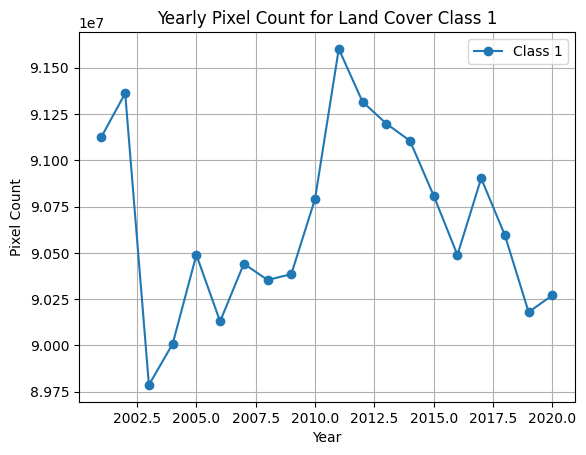

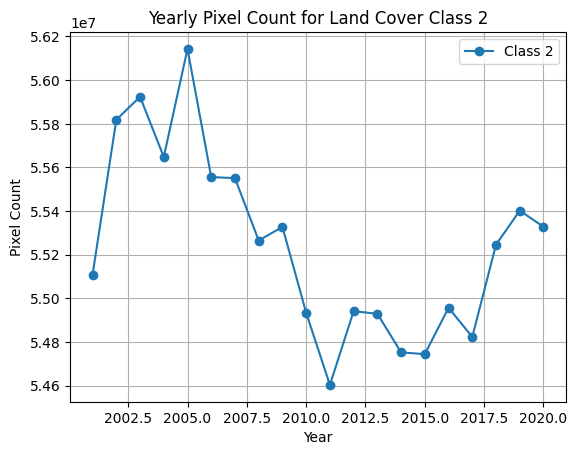

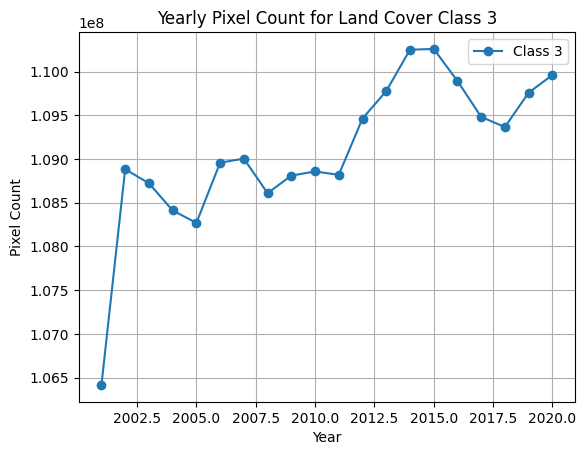

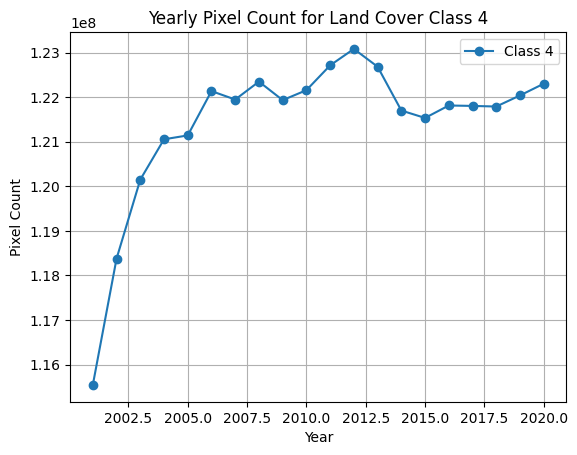

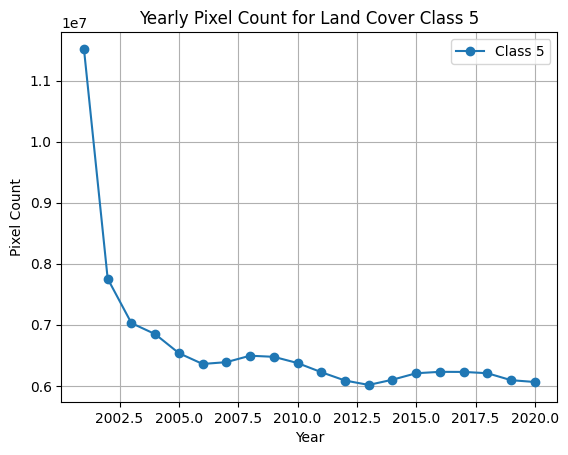

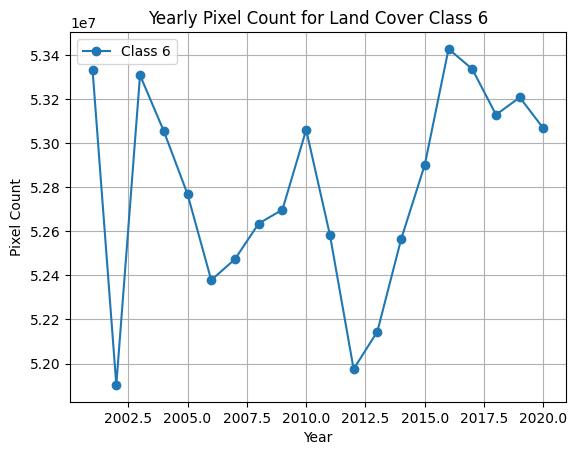

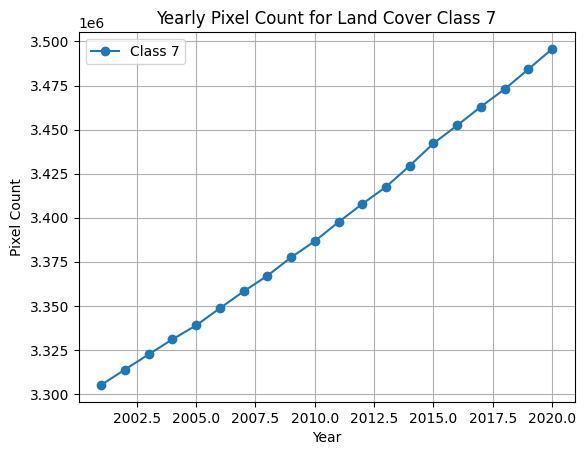

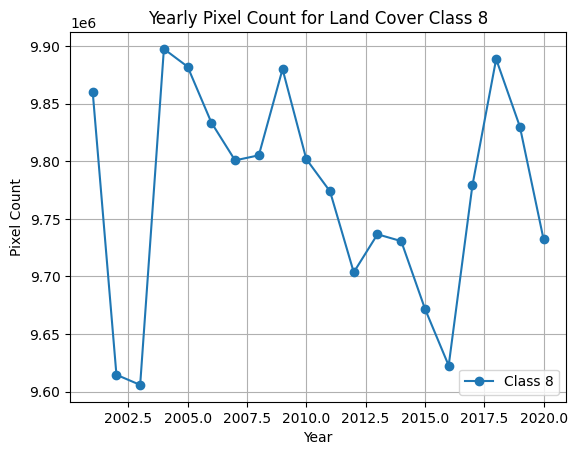

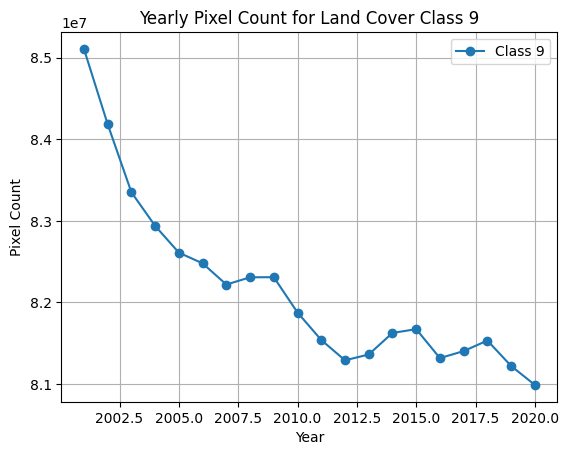

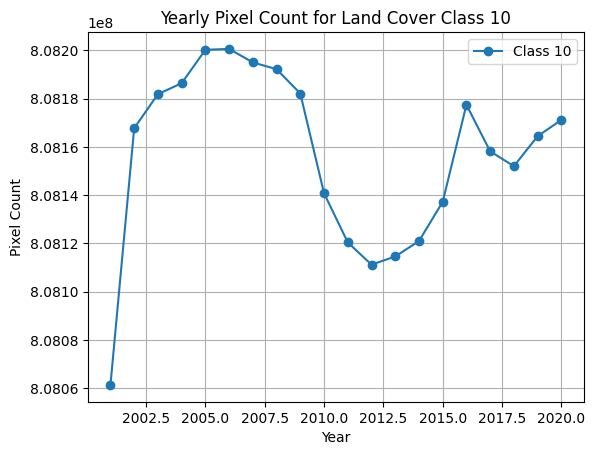

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Initialize Earth Engine (this might be required if disconnected)
ee.Initialize()

# Initialize a dictionary to hold pixel counts per class for each year
class_pixel_counts = {class_id: [] for class_id in range(1, 11)}
years = list(range(2001, 2021))

# Count pixels for each class and each year
for year, lc_image in zip(years, lc_images):
    # Calculate pixel counts for each class (1 to 10)
    for class_id in range(1, 11):
        class_count = lc_image.eq(class_id).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=roi_geometry,
            scale=500,
            maxPixels=1e13
        ).getInfo()

        # Store pixel count for the class for this year
        pixel_count = class_count.get('remapped', 0)  # Default to 0 if class not present
        class_pixel_counts[class_id].append(pixel_count)



# Convert to a DataFrame for easy plotting
df_pixel_counts = pd.DataFrame(class_pixel_counts, index=years)
df_pixel_counts.index.name = 'Year'

# Plot pixel counts over time for each class
for class_id in range(1, 11):
    plt.figure()
    plt.plot(df_pixel_counts.index, df_pixel_counts[class_id], marker='o', label=f'Class {class_id}')
    plt.title(f'Yearly Pixel Count for Land Cover Class {class_id}')
    plt.xlabel('Year')
    plt.ylabel('Pixel Count')
    plt.legend()
    plt.grid(True)
    plt.show()



In [ ]:
import ee
import pandas as pd
from google.colab import drive

# Initialize Earth Engine
ee.Initialize()

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to save the Excel file in your Google Drive
output_file = '/content/drive/My Drive/land_cover_pixel_counts.xlsx'

# Initialize a dictionary to hold pixel counts per class for each year
class_pixel_counts = {class_id: [] for class_id in range(1, 11)}
years = list(range(2001, 2021))

# Count pixels for each class and each year
for year, lc_image in zip(years, lc_images):
    # Calculate pixel counts for each class (1 to 10)
    for class_id in range(1, 11):
        class_count = lc_image.eq(class_id).reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=roi_geometry,
            scale=500,
            maxPixels=1e13
        ).getInfo()

        # Store pixel count for the class for this year
        pixel_count = class_count.get('remapped', 0)  # Default to 0 if class not present
        class_pixel_counts[class_id].append(pixel_count)

# Convert the dictionary to a pandas DataFrame
df_pixel_counts = pd.DataFrame(class_pixel_counts, index=years)
df_pixel_counts.index.name = 'Year'

# Save the DataFrame to an Excel file in Google Drive
df_pixel_counts.to_excel(output_file, sheet_name='Pixel Counts')

print(f"Pixel counts successfully exported to {output_file}")


Mounted at /content/drive
Pixel counts successfully exported to /content/drive/My Drive/land_cover_pixel_counts.xlsx


In [ ]:
import ee
import geemap
import ipywidgets as widgets
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180,-59], [0, -59], [-180,-59]],
    None,
    False
)

# Define visualization parameters for the revised LC_Type 1 categories
aggregated_visualization_parameters = {
    'min': 1,
    'max': 10,
    'palette': [
        '#05450a',  # Class 1
        '#c6b044',  # Class 2
        '#fbff13',  # Class 3
        '#b6ff05',  # Class 4
        '#27ff87',  # Class 5
        '#c24f44',  # Class 6
        '#a5a5a5',  # Class 7
        '#69fff8',  # Class 8
        '#f9ffa4',  # Class 9
        '#1c0dff'   # Class 10
    ]
}

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type1') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Function to aggregate LC_Type1 into the new classes
def aggregate_land_cover(lc_image):
    # Remap LC_Type1 values to the revised classes
    aggregated_lc = lc_image.remap(
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],  # Original LC_Type1 values
        [1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 6, 8, 9, 10]         # Revised classes
    )
    return aggregated_lc

# Function to detect and mask areas with a single land cover change
def detect_single_change(lc_images):
    combined_image = ee.Image.cat(lc_images)
    diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
    change_mask = diffs.abs().gt(0)
    change_count = change_mask.reduce(ee.Reducer.sum())
    single_change_mask = change_count.eq(1)  # Detect exactly one change
    return single_change_mask

# Function to detect and mask areas with no change throughout the period
def detect_no_change(lc_images):
    combined_image = ee.Image.cat(lc_images)
    diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
    change_mask = diffs.abs().gt(0)
    no_change_mask = change_mask.reduce(ee.Reducer.sum()).eq(0)  # Detect no changes
    return no_change_mask

# Function to detect the year of the first change where exactly one change occurred
def detect_change_year_from_disturbed(lc_images, disturbed_mask):
    change_years = ee.Image(0)  # Initialize with zeros
    for i in range(1, len(lc_images)):
        change = lc_images[i].neq(lc_images[i-1])  # Detect change
        change_years = change_years.where(change.And(change_years.eq(0)), i + 2001)  # Mark the year of change
    change_years = change_years.updateMask(disturbed_mask)  # Mask with the disturbed areas
    return change_years

# Function to create Before_Landcover and After_Landcover layers
def create_before_after_landcover_layers(lc_images, change_years):
    before_landcover = ee.Image(0)
    after_landcover = ee.Image(0)
    for i in range(1, len(lc_images)):
        current_year = i + 2001
        before_condition = change_years.eq(current_year)
        after_condition = change_years.eq(current_year)
        before_landcover = before_landcover.where(before_condition, lc_images[i-1])
        after_landcover = after_landcover.where(after_condition, lc_images[i])
    return before_landcover, after_landcover

# Initialize the ipyleaflet map with scroll zoom enabled and larger dimensions
m = Map(center=(0, 0), zoom=2, scroll_wheel_zoom=True, layout={'width': '1000px', 'height': '700px'})

# Function to add a specific year's aggregated land cover as a TileLayer
def add_land_cover_to_map(year):
    lc_image = load_land_cover(year)
    aggregated_lc_image = aggregate_land_cover(lc_image)
    if aggregated_lc_image:
        tile_layer = geemap.ee_tile_layer(aggregated_lc_image, aggregated_visualization_parameters, f'LC Cover {year}')
        m.add_layer(tile_layer)
    else:
        print(f"Failed to load land cover data for the year {year}.")

# Load and aggregate land cover data for years 2001 to 2020
lc_images = [aggregate_land_cover(load_land_cover(year)) for year in range(2001, 2021)]
for year in range(2001, 2021):
    add_land_cover_to_map(year)

# Add the disturbed mask layer to the map (single change detection)
disturbed_mask = detect_single_change(lc_images)
disturbed_mask_layer = geemap.ee_tile_layer(disturbed_mask.selfMask(), {'palette': ['red']}, 'Disturbed_Mask')
m.add_layer(disturbed_mask_layer)

# Add the "No Change" mask layer to the map
no_change_mask = detect_no_change(lc_images)
no_change_mask_layer = geemap.ee_tile_layer(no_change_mask.selfMask(), {'palette': ['green']}, 'No_Change_Mask')
m.add_layer(no_change_mask_layer)

# Add the "Change Detected" layer to the map (year of change detection based on disturbed areas)
change_year_mask = detect_change_year_from_disturbed(lc_images, disturbed_mask)
change_year_layer = geemap.ee_tile_layer(change_year_mask.selfMask(), {'min': 2001, 'max': 2020, 'palette': ['yellow', 'orange', 'red']}, 'Change_Year_Mask')
m.add_layer(change_year_layer)

# Create and add the Before_Landcover and After_Landcover layers
before_landcover, after_landcover = create_before_after_landcover_layers(lc_images, change_year_mask)
before_landcover_layer = geemap.ee_tile_layer(before_landcover.selfMask(), aggregated_visualization_parameters, 'Before Landcover')
after_landcover_layer = geemap.ee_tile_layer(after_landcover.selfMask(), aggregated_visualization_parameters, 'After Landcover')
m.add_layer(before_landcover_layer)
m.add_layer(after_landcover_layer)

# Add layer control to toggle layers on/off
layers_control = LayersControl(position='topright')
m.add_control(layers_control)

# Create a table (widget) to display the information
output_table = widgets.HTML(value="")
output_table.layout.margin = '0px 20px 20px 20px'
output_table.layout.width = '600px'

# Function to update the GUI table
def update_table(results, disturbed_value, change_year_value, no_change_value):
    html_content = "<table><tr><th>Year</th>"
    for year in results.keys():
        html_content += f"<th>{year}</th>"
    html_content += "</tr><tr><td>LC</td>"
    for value in results.values():
        html_content += f"<td>{value}</td>"
    html_content += f"</tr><tr><td>Disturbed_Mask</td><td colspan='{len(results)}'>{disturbed_value}</td></tr>"
    html_content += f"<tr><td>No_Change_Mask</td><td colspan='{len(results)}'>{no_change_value}</td></tr>"
    html_content += f"<tr><td>Change_Detected_Mask (Year)</td><td colspan='{len(results)}'>{change_year_value}</td></tr>"
    html_content += "</table>"
    output_table.value = html_content

# Function to handle map click event and retrieve aggregated land cover values
def handle_map_click(**kwargs):
    if kwargs.get('type') == 'click':
        lat = kwargs.get('coordinates')[0]
        lon = kwargs.get('coordinates')[1]

        # Check if coordinates are within valid bounds
        if -90 <= lat <= 90 and -180 <= lon <= 180:
            point = ee.Geometry.Point([lon, lat])

            # Extract aggregated land cover information from each year's image at the clicked point
            results = {}
            for year, image in zip(range(2001, 2021), lc_images):
                value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('remapped').getInfo()
                results[year] = value

            # Extract disturbed mask, no change mask, and change year values
            disturbed_value = disturbed_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('sum').getInfo()
            no_change_value = no_change_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('sum').getInfo()
            change_year_value = change_year_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('constant').getInfo()

            # Update the table with new information
            update_table(results, disturbed_value, change_year_value, no_change_value)

# Attach the click event handler to the map
m.on_interaction(handle_map_click)

# Display the map and the table below it
display(m)
display(output_table)


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

HTML(value='', layout=Layout(margin='0px 20px 20px 20px', width='600px'))

**====================== Exporting Starts from Here ======================**

In [ ]:
# Function to export disturbed and undisturbed masks
def export_disturbed_and_undisturbed(disturbed_mask, no_change_mask):
    # Export Disturbed Mask
    ee.batch.Export.image.toDrive(
        image=disturbed_mask,
        description='Disturbed_Mask',
        folder='Landcover_Exports',  # Folder name in Google Drive
        scale=500,
        region=roi_geometry,
        fileFormat='GeoTIFF',
        crs='EPSG:4326',
        maxPixels=1e13
    ).start()
    print("Exporting Disturbed_Mask to Landcover_Exports folder...")

    # Export Undisturbed (No Change) Mask
    ee.batch.Export.image.toDrive(
        image=no_change_mask,
        description='Undisturbed_Mask',
        folder='Landcover_Exports',
        scale=500,
        region=roi_geometry,
        fileFormat='GeoTIFF',
        crs='EPSG:4326',
        maxPixels=1e13
    ).start()
    print("Exporting Undisturbed_Mask to Landcover_Exports folder...")

# Call the function
export_disturbed_and_undisturbed(disturbed_mask, no_change_mask)


Exporting Disturbed_Mask to Landcover_Exports folder...
Exporting Undisturbed_Mask to Landcover_Exports folder...


In [ ]:
# Function to export transition masks
def export_transition_masks(before_landcover, after_landcover):
    # for before_class in range(1, 3):  # Classes 1 to 2
    # for before_class in range(3, 5):  # Classes 3 to 4
    # for before_class in range(5, 7):  # Classes 5 to 6
    # for before_class in range(7, 9):  # Classes 7 to 8
    # for before_class in range(9, 11):  # Classes 9 to 10
    for before_class in range(1, 11):
        for after_class in range(1, 11):  # Classes 1 to 10
            # Create a mask for each combination of before and after classes
            transition_mask = before_landcover.eq(before_class).And(after_landcover.eq(after_class))

            # Name the mask based on the transition (e.g., Class1_to_Class2_Mask)
            mask_name = f"Class{before_class}_to_Class{after_class}_Mask"

            # Export the mask to Google Drive in the specified folder "Disturbed_Mask"
            export_task = ee.batch.Export.image.toDrive(
                image=transition_mask,
                description=mask_name,
                folder='Disturbed_Mask',  # Folder in 'My Drive' > 'Disturbed_Mask'
                scale=500,
                region=roi_geometry,
                fileFormat='GeoTIFF',
                crs='EPSG:4326',  # Export to EPSG:4326
                maxPixels=1e13
            )
            export_task.start()
            print(f"Exporting {mask_name} to Disturbed_Mask folder...")

# Call the function to export all transition masks
export_transition_masks(before_landcover, after_landcover)


Exporting Class1_to_Class1_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class2_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class3_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class4_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class5_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class6_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class7_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class8_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class9_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class10_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class1_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class2_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class3_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class4_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class5_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class6_Mask to Disturbed_Mask folder...
Exporting Class2_to_Class7_Mask to Dist

In [ ]:
# Function to export before and after land cover images
def export_before_after_landcover(before_landcover, after_landcover):
    # Export Before Landcover
    ee.batch.Export.image.toDrive(
        image=before_landcover,
        description='Before_Landcover',
        folder='Landcover_Exports',  # Folder name in Google Drive
        scale=500,
        region=roi_geometry,
        fileFormat='GeoTIFF',
        crs='EPSG:4326',
        maxPixels=1e13
    ).start()
    print("Exporting Before_Landcover to Landcover_Exports folder...")

    # Export After Landcover
    ee.batch.Export.image.toDrive(
        image=after_landcover,
        description='After_Landcover',
        folder='Landcover_Exports',
        scale=500,
        region=roi_geometry,
        fileFormat='GeoTIFF',
        crs='EPSG:4326',
        maxPixels=1e13
    ).start()
    print("Exporting After_Landcover to Landcover_Exports folder...")

# Call the function
export_before_after_landcover(before_landcover, after_landcover)


Exporting Before_Landcover to Landcover_Exports folder...
Exporting After_Landcover to Landcover_Exports folder...


## **8. Final - 2001 to 2020 Original LC Type 1 Extraction**

In [ ]:
import ee
import geemap
import ipywidgets as widgets
from ipyleaflet import Map, LayersControl
from IPython.display import display

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (ROI) - global area of interest
roi_geometry = ee.Geometry.Polygon(
    [[-180, 84], [0, 84], [180, 84], [180, -59], [0, -59], [-180, -59]],
    None,
    False
)

# Define visualization parameters for the revised LC_Type 1 categories
aggregated_visualization_parameters = {
    'min': 1,
    'max': 10,
    'palette': [
        '#05450a',  # Class 1
        '#c6b044',  # Class 2
        '#fbff13',  # Class 3
        '#b6ff05',  # Class 4
        '#27ff87',  # Class 5
        '#c24f44',  # Class 6
        '#a5a5a5',  # Class 7
        '#69fff8',  # Class 8
        '#f9ffa4',  # Class 9
        '#1c0dff'   # Class 10
    ]
}

# Function to load MODIS land cover data for a specific year
def load_land_cover(year):
    period_start = f'{year}-01-01'
    period_end = f'{year}-12-31'

    lc_period = ee.ImageCollection('MODIS/061/MCD12Q1') \
        .filterDate(period_start, period_end) \
        .select('LC_Type1') \
        .filterBounds(roi_geometry) \
        .first()

    return lc_period

# Function to aggregate LC_Type1 into the new classes
def aggregate_land_cover(lc_image):
    # Remap LC_Type1 values to the revised classes
    aggregated_lc = lc_image.remap(
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
        [1, 1, 1, 1, 1, 2, 2, 3, 3, 4, 5, 6, 7, 6, 8, 9, 10]
    )
    return aggregated_lc

# Revised Function: Detect a single change between 2006-2015 with pre/post consistency
def detect_single_change_with_conditions(lc_images, start_year=2006, end_year=2015):
    start_idx = start_year - 2001
    end_idx = end_year - 2001

    combined_image = ee.Image.cat(lc_images)
    diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
    change_mask = diffs.abs().gt(0)
    change_count = change_mask.reduce(ee.Reducer.sum())

    pre_2006 = combined_image.select(list(range(0, start_idx)))
    post_2015 = combined_image.select(list(range(end_idx + 1, len(lc_images))))
    all_pre_equal = pre_2006.reduce(ee.Reducer.min()).eq(pre_2006.reduce(ee.Reducer.max()))
    all_post_equal = post_2015.reduce(ee.Reducer.min()).eq(post_2015.reduce(ee.Reducer.max()))
    pre_post_equal = all_pre_equal.And(all_post_equal)

    single_change_mask = change_count.eq(1).And(pre_post_equal)
    return single_change_mask

# Function to detect and mask areas with no change throughout the period
def detect_no_change(lc_images):
    combined_image = ee.Image.cat(lc_images)
    diffs = combined_image.select(list(range(1, len(lc_images)))).subtract(combined_image.select(list(range(len(lc_images) - 1))))
    change_mask = diffs.abs().gt(0)
    no_change_mask = change_mask.reduce(ee.Reducer.sum()).eq(0)  # Detect no changes
    return no_change_mask

# Function to detect the year of the first change where exactly one change occurred
def detect_change_year_from_disturbed(lc_images, disturbed_mask):
    change_years = ee.Image(0)  # Initialize with zeros
    for i in range(1, len(lc_images)):
        change = lc_images[i].neq(lc_images[i-1])  # Detect change
        change_years = change_years.where(change.And(change_years.eq(0)), i + 2001)  # Mark the year of change
    change_years = change_years.updateMask(disturbed_mask)  # Mask with the disturbed areas
    return change_years

# Function to create Before_Landcover and After_Landcover layers
def create_before_after_landcover_layers(lc_images, change_years):
    before_landcover = ee.Image(0)
    after_landcover = ee.Image(0)
    for i in range(1, len(lc_images)):
        current_year = i + 2001
        before_condition = change_years.eq(current_year)
        after_condition = change_years.eq(current_year)
        before_landcover = before_landcover.where(before_condition, lc_images[i-1])
        after_landcover = after_landcover.where(after_condition, lc_images[i])
    return before_landcover, after_landcover

# Initialize the ipyleaflet map
m = Map(center=(0, 0), zoom=2, scroll_wheel_zoom=True, layout={'width': '1000px', 'height': '700px'})

# Function to add a specific year's aggregated land cover as a TileLayer
def add_land_cover_to_map(year):
    lc_image = load_land_cover(year)
    aggregated_lc_image = aggregate_land_cover(lc_image)
    if aggregated_lc_image:
        tile_layer = geemap.ee_tile_layer(aggregated_lc_image, aggregated_visualization_parameters, f'LC Cover {year}')
        m.add_layer(tile_layer)
    else:
        print(f"Failed to load land cover data for the year {year}.")

# Load and aggregate land cover data for years 2001 to 2020
lc_images = [aggregate_land_cover(load_land_cover(year)) for year in range(2001, 2021)]
for year in range(2001, 2021):
    add_land_cover_to_map(year)

# Use the single change mask as the new disturbed_mask
disturbed_mask = detect_single_change_with_conditions(lc_images, start_year=2006, end_year=2015)
disturbed_mask_layer = geemap.ee_tile_layer(disturbed_mask.selfMask(), {'palette': ['red']}, 'Disturbed_Mask')
m.add_layer(disturbed_mask_layer)

# Add the "No Change" mask layer
no_change_mask = detect_no_change(lc_images)
no_change_mask_layer = geemap.ee_tile_layer(no_change_mask.selfMask(), {'palette': ['green']}, 'No_Change_Mask')
m.add_layer(no_change_mask_layer)

# Add the "Change Detected" layer to the map (year of change detection based on disturbed areas)
change_year_mask = detect_change_year_from_disturbed(lc_images, disturbed_mask)
change_year_layer = geemap.ee_tile_layer(change_year_mask.selfMask(), {'min': 2001, 'max': 2020, 'palette': ['yellow', 'orange', 'red']}, 'Change_Year_Mask')
m.add_layer(change_year_layer)

# Create and add the Before_Landcover and After_Landcover layers
before_landcover, after_landcover = create_before_after_landcover_layers(lc_images, change_year_mask)
before_landcover_layer = geemap.ee_tile_layer(before_landcover.selfMask(), aggregated_visualization_parameters, 'Before Landcover')
after_landcover_layer = geemap.ee_tile_layer(after_landcover.selfMask(), aggregated_visualization_parameters, 'After Landcover')
m.add_layer(before_landcover_layer)
m.add_layer(after_landcover_layer)

# Add layer control to toggle layers on/off
layers_control = LayersControl(position='topright')
m.add_control(layers_control)

# Create a table (widget) to display the information
output_table = widgets.HTML(value="")
output_table.layout.margin = '0px 20px 20px 20px'
output_table.layout.width = '600px'

# Function to update the GUI table
def update_table(results, disturbed_value, change_year_value, no_change_value):
    html_content = "<table><tr><th>Year</th>"
    for year in results.keys():
        html_content += f"<th>{year}</th>"
    html_content += "</tr><tr><td>LC</td>"
    for value in results.values():
        html_content += f"<td>{value}</td>"
    html_content += f"</tr><tr><td>Disturbed_Mask</td><td colspan='{len(results)}'>{disturbed_value}</td></tr>"
    html_content += f"<tr><td>No_Change_Mask</td><td colspan='{len(results)}'>{no_change_value}</td></tr>"
    html_content += f"<tr><td>Change_Detected_Mask (Year)</td><td colspan='{len(results)}'>{change_year_value}</td></tr>"
    html_content += "</table>"
    output_table.value = html_content

# Function to handle map click event and retrieve aggregated land cover values
def handle_map_click(**kwargs):
    if kwargs.get('type') == 'click':
        lat = kwargs.get('coordinates')[0]
        lon = kwargs.get('coordinates')[1]

        # Check if coordinates are within valid bounds
        if -90 <= lat <= 90 and -180 <= lon <= 180:
            point = ee.Geometry.Point([lon, lat])

            # Extract aggregated land cover information from each year's image at the clicked point
            results = {}
            for year, image in zip(range(2001, 2021), lc_images):
                value = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('remapped').getInfo()
                results[year] = value

            # Extract disturbed mask, no change mask, and change year values
            disturbed_value = disturbed_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('sum').getInfo()
            no_change_value = no_change_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('sum').getInfo()
            change_year_value = change_year_mask.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=30).get('constant').getInfo()

            # Update the table with new information
            update_table(results, disturbed_value, change_year_value, no_change_value)

# Attach the click event handler to the map
m.on_interaction(handle_map_click)

# Display the map and the table below it
display(m)
display(output_table)


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

HTML(value='', layout=Layout(margin='0px 20px 20px 20px', width='600px'))

In [ ]:
# Function to export disturbed and undisturbed masks
def export_disturbed_and_undisturbed(disturbed_mask, no_change_mask):
    # Export Disturbed Mask
    ee.batch.Export.image.toDrive(
        image=disturbed_mask,
        description='Disturbed_Mask',
        folder='Landcover_Exports',  # Folder name in Google Drive
        scale=500,
        region=roi_geometry,
        fileFormat='GeoTIFF',
        crs='EPSG:4326',
        maxPixels=1e13
    ).start()
    print("Exporting Disturbed_Mask to Landcover_Exports folder...")

    # Export Undisturbed (No Change) Mask
    ee.batch.Export.image.toDrive(
        image=no_change_mask,
        description='Undisturbed_Mask',
        folder='Landcover_Exports',
        scale=500,
        region=roi_geometry,
        fileFormat='GeoTIFF',
        crs='EPSG:4326',
        maxPixels=1e13
    ).start()
    print("Exporting Undisturbed_Mask to Landcover_Exports folder...")

# Call the function
export_disturbed_and_undisturbed(disturbed_mask, no_change_mask)


Exporting Disturbed_Mask to Landcover_Exports folder...
Exporting Undisturbed_Mask to Landcover_Exports folder...


In [ ]:
# Function to export transition masks
def export_transition_masks(before_landcover, after_landcover):
    for before_class in range(1, 18):
        for after_class in range(1, 18):  # Classes 1 to 17
            # Create a mask for each combination of before and after classes
            transition_mask = before_landcover.eq(before_class).And(after_landcover.eq(after_class))

            # Name the mask based on the transition (e.g., Class1_to_Class2_Mask)
            mask_name = f"Class{before_class}_to_Class{after_class}_Mask"

            # Export the mask to Google Drive in the specified folder "Disturbed_Mask"
            export_task = ee.batch.Export.image.toDrive(
                image=transition_mask,
                description=mask_name,
                folder='Disturbed_Mask',  # Folder in 'My Drive' > 'Disturbed_Mask'
                scale=500,
                region=roi_geometry,
                fileFormat='GeoTIFF',
                crs='EPSG:4326',  # Export to EPSG:4326
                maxPixels=1e13
            )
            export_task.start()
            print(f"Exporting {mask_name} to Disturbed_Mask folder...")

# Call the function to export all transition masks
export_transition_masks(before_landcover, after_landcover)


Exporting Class1_to_Class1_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class2_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class3_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class4_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class5_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class6_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class7_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class8_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class9_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class10_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class11_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class12_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class13_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class14_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class15_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class16_Mask to Disturbed_Mask folder...
Exporting Class1_to_Class17_Mask 

In [ ]:
# Function to export before and after land cover images
def export_before_after_landcover(before_landcover, after_landcover):
    # Export Before Landcover
    ee.batch.Export.image.toDrive(
        image=before_landcover,
        description='Before_Landcover',
        folder='Landcover_Exports',  # Folder name in Google Drive
        scale=500,
        region=roi_geometry,
        fileFormat='GeoTIFF',
        crs='EPSG:4326',
        maxPixels=1e13
    ).start()
    print("Exporting Before_Landcover to Landcover_Exports folder...")

    # Export After Landcover
    ee.batch.Export.image.toDrive(
        image=after_landcover,
        description='After_Landcover',
        folder='Landcover_Exports',
        scale=500,
        region=roi_geometry,
        fileFormat='GeoTIFF',
        crs='EPSG:4326',
        maxPixels=1e13
    ).start()
    print("Exporting After_Landcover to Landcover_Exports folder...")

# Call the function
export_before_after_landcover(before_landcover, after_landcover)


Exporting Before_Landcover to Landcover_Exports folder...
Exporting After_Landcover to Landcover_Exports folder...
